# Predicting Student Dropout and Academic Success



#### This notebook uses statistical and machine learning methods to predict the academic success of undergraduate students.

It is based on a Portuguese study, the work being published in the scientific paper:
M.V.Martins, D. Tolledo, J. Machado, L. M.T. Baptista, V.Realinho. (2021) "Early prediction of student’s performance in higher education: a case study" Trends and Applications in Information Systems and Technologies, vol.1, in Advances in Intelligent Systems and Computing series. Springer. DOI: 10.1007/978-3-030-72657-7_16

It requires download of the dataset available at: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

The notebook will address two research questions:
- RQ1) Can the prediction accuracy and F1-score of the Portuguese study be improved by incorporating first-year academic data?
- RQ2) Can the prediction accuracy and F1-score results of RQ1 be improved by modelling and predicting each of the target classes separately?

The best scores from the Portuguese study were: F1-scores of 0.83 (Success), 0.68 (Failure), 0.44 (Relative success) with an average of 0.65 and an Accuracy of 0.73. 



## 1) Import python libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as disp

from scipy import sparse
from scipy.stats import kruskal, chi2_contingency, boxcox, mannwhitneyu
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support as score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV


## 2) Data Preparation and Cleaning

#### Importing the dataset

In [2]:
# Import the data, handling the semi-colon value separator
data = pd.read_csv('students_dropout_and_academic_success.csv', sep=';')

#### Improve column naming

In [3]:
# - correct spelling mistake
data.rename(columns={'Nacionality': 'Nationality'}, inplace=True)
# - make uppercase
data.columns = data.columns.str.upper()
# - replace spaces with underscores
data.columns = data.columns.str.replace(' ', '_')
# - remove brackets and use of 's 
data.columns = data.columns.str.replace('(', '')
data.columns = data.columns.str.replace(')', '')
data.columns = data.columns.str.replace("'S", '')
# - remove tab character
data.columns = data.columns.str.replace('\t', '')
# - remove leading or trailing spaces
data.columns = data.columns.str.strip()
# abbreviate CURRICULAR
data.columns = data.columns.str.replace('CURRICULAR', 'CURR')

print('Column names and data types')
print('---------------------------')
print(data.dtypes)

Column names and data types
---------------------------
MARITAL_STATUS                              int64
APPLICATION_MODE                            int64
APPLICATION_ORDER                           int64
COURSE                                      int64
DAYTIME/EVENING_ATTENDANCE                  int64
PREVIOUS_QUALIFICATION                      int64
PREVIOUS_QUALIFICATION_GRADE              float64
NATIONALITY                                 int64
MOTHER_QUALIFICATION                        int64
FATHER_QUALIFICATION                        int64
MOTHER_OCCUPATION                           int64
FATHER_OCCUPATION                           int64
ADMISSION_GRADE                           float64
DISPLACED                                   int64
EDUCATIONAL_SPECIAL_NEEDS                   int64
DEBTOR                                      int64
TUITION_FEES_UP_TO_DATE                     int64
GENDER                                      int64
SCHOLARSHIP_HOLDER                          

In [4]:
# examine the size of the dataset
print("Data shape:", data.shape)

Data shape: (4424, 37)


#### Examine the distribution of Target classes and Gender in the data

In [5]:
# define a palette for use when displaying Target
target_palette = {
        'Dropout': 'red',      # Red for Dropout
        'Enrolled': 'orange',  # Orange for Enrolled
        'Graduate': 'green'    # Green for Graduate
}

# define a palette for use when displaying Gender
gender_palette = {0: (255/255, 182/255, 193/255), 1: (70/255, 130/255, 180/255)}  # 0: female/pink, 1: male/blue

In [6]:
def save_figure(fig, filename):
    # save the current figure 
    fig.savefig(filename, dpi=300, bbox_inches='tight')  # Save figure in high res png

Target Distribution
          Count  Percentage
TARGET                     
Graduate   2209   49.932188
Dropout    1421   32.120253
Enrolled    794   17.947559

Gender Distribution
        Count  Percentage
GENDER                   
Female   2868    64.82821
Male     1556    35.17179


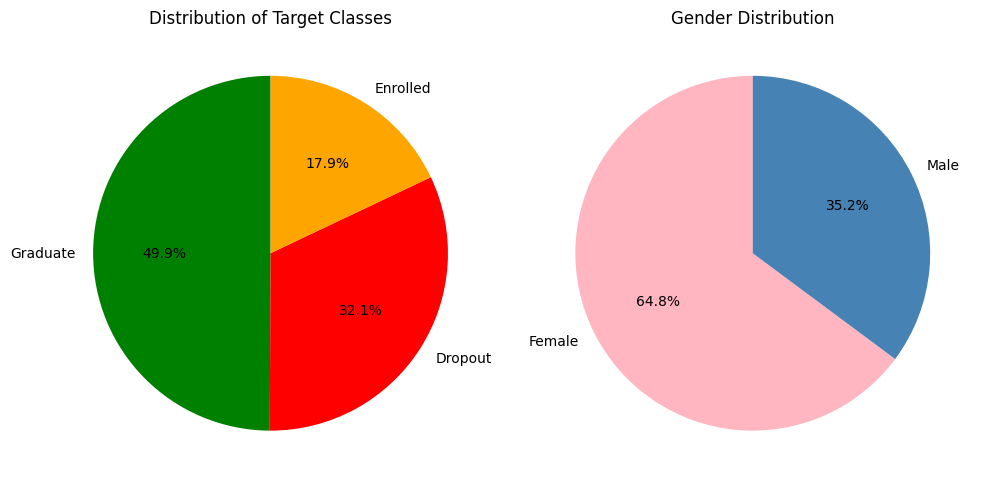

In [7]:
# Define the data for the pie charts
target_counts = data["TARGET"].value_counts()
target_counts_perc = data["TARGET"].value_counts(normalize=True) * 100
gender_counts = data["GENDER"].value_counts()
gender_counts_perc = data["GENDER"].value_counts(normalize=True) * 100

print("Target Distribution")
target_summary = pd.DataFrame({
    'Count': target_counts,
    'Percentage': target_counts_perc
})
print(target_summary)

print("\nGender Distribution")
gender_summary = pd.DataFrame({
    'Count': gender_counts,
    'Percentage': gender_counts_perc
}).rename(index={1: "Male", 0: "Female"})
print(gender_summary)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Pie chart for TARGET classes
axes[0].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', 
            colors=[target_palette[label] for label in target_counts.index], startangle=90)
axes[0].set_title("Distribution of Target Classes")

# Pie chart for Gender
axes[1].pie(gender_counts, labels=['Female', 'Male'], autopct='%1.1f%%', 
            colors=[gender_palette[key] for key in gender_counts.index], startangle=90)
axes[1].set_title("Gender Distribution")

# Save the image
save_figure(fig, "pie_charts.png")

# Adjust layout and display
plt.tight_layout()
plt.show()

#### Create columns to hold binary classification of each Target value

In [8]:

# create binary target features
data['TARGET_IS_DROPOUT'] = (data['TARGET'] == 'Dropout').astype(int)
data['TARGET_IS_ENROLLED'] = (data['TARGET'] == 'Enrolled').astype(int)
data['TARGET_IS_GRADUATE'] = (data['TARGET'] == 'Graduate').astype(int)

# Counts of each binary target category
dropout_count = (data['TARGET_IS_DROPOUT'] == 1).sum()
enrolled_count = (data['TARGET_IS_ENROLLED'] == 1).sum()
graduate_count = (data['TARGET_IS_GRADUATE'] == 1).sum()

print(f"{graduate_count} students graduated on time, {dropout_count} students dropped out, {enrolled_count} students still enrolled at end of course.")


2209 students graduated on time, 1421 students dropped out, 794 students still enrolled at end of course.


#### Build lists of column names of each type: 'categorical_columns', 'continuous_columns', and targets

In [9]:
categorical_columns = [
    'MARITAL_STATUS',
    'APPLICATION_MODE',
    'APPLICATION_ORDER',
    'COURSE',
    'DAYTIME/EVENING_ATTENDANCE',
    'PREVIOUS_QUALIFICATION',
    'NATIONALITY',
    'MOTHER_QUALIFICATION',
    'FATHER_QUALIFICATION',
    'MOTHER_OCCUPATION',
    'FATHER_OCCUPATION',
    'DISPLACED',
    'EDUCATIONAL_SPECIAL_NEEDS',
    'DEBTOR',
    'TUITION_FEES_UP_TO_DATE',
    'GENDER',
    'SCHOLARSHIP_HOLDER',
    'INTERNATIONAL',
    'TARGET'
]

categorical_columns_without_target = [col for col in categorical_columns if col != 'TARGET']

target_column = [
    'TARGET'
]

target_binary_columns = [
    'TARGET_IS_DROPOUT',
    'TARGET_IS_ENROLLED',
    'TARGET_IS_GRADUATE'
]

continuous_columns = [    
    'PREVIOUS_QUALIFICATION_GRADE',
    'ADMISSION_GRADE',
    'AGE_AT_ENROLLMENT',
    'CURR_UNITS_1ST_SEM_CREDITED',
    'CURR_UNITS_1ST_SEM_ENROLLED',
    'CURR_UNITS_1ST_SEM_EVALUATIONS',
    'CURR_UNITS_1ST_SEM_APPROVED',
    'CURR_UNITS_1ST_SEM_GRADE',
    'CURR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS',
    'CURR_UNITS_2ND_SEM_CREDITED',
    'CURR_UNITS_2ND_SEM_ENROLLED',
    'CURR_UNITS_2ND_SEM_EVALUATIONS',
    'CURR_UNITS_2ND_SEM_APPROVED',
    'CURR_UNITS_2ND_SEM_GRADE',
    'CURR_UNITS_2ND_SEM_WITHOUT_EVALUATIONS',
    'UNEMPLOYMENT_RATE',
    'INFLATION_RATE',
    'GDP'
]

#### Prepare Pre-cleaning Summary Information

In [10]:
def report_summary_of_categorical_columns(column_names):

    # Create a DataFrame summarising the columns
    summary_table = pd.DataFrame({
        "Column Name": column_names,
        "Unique Classes": [data[col].nunique() for col in column_names],
        "Data Type": [data[col].dtype for col in column_names]
    })

    return (summary_table)

In [11]:
def report_summary_of_continuous_columns(column_names):
    summary = []

    for col in column_names:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        summary.append({
            "Column": col,
            "Mean": round(data[col].mean(), 2),
            "Median": round(data[col].median(), 2),
            "Mode": round(data[col].mode()[0], 2),
            "Min": round(data[col].min(), 2),
            "Max": round(data[col].max(), 2),
            "Range": round(data[col].max() - data[col].min(), 2),
            "Q1 (25%)": round(Q1, 2),
            "Q3 (75%)": round(Q3, 2),
            "IQR": round(IQR, 2),
            "Std Dev": round(data[col].std(), 2),
            "Variance": round(data[col].var(), 2)
        })

    summary_table = pd.DataFrame(summary)
    return (summary_table)


In [12]:
print("Summary of Categorical columns")
print("------------------------------")
cat_summary = report_summary_of_categorical_columns(categorical_columns)
print (cat_summary)
cat_summary.to_csv('initial_data_summary_cat.csv', index=False)

Summary of Categorical columns
------------------------------
                   Column Name  Unique Classes Data Type
0               MARITAL_STATUS               6     int64
1             APPLICATION_MODE              18     int64
2            APPLICATION_ORDER               8     int64
3                       COURSE              17     int64
4   DAYTIME/EVENING_ATTENDANCE               2     int64
5       PREVIOUS_QUALIFICATION              17     int64
6                  NATIONALITY              21     int64
7         MOTHER_QUALIFICATION              29     int64
8         FATHER_QUALIFICATION              34     int64
9            MOTHER_OCCUPATION              32     int64
10           FATHER_OCCUPATION              46     int64
11                   DISPLACED               2     int64
12   EDUCATIONAL_SPECIAL_NEEDS               2     int64
13                      DEBTOR               2     int64
14     TUITION_FEES_UP_TO_DATE               2     int64
15                      GE

In [13]:
print("Summary of Continuous columns")
print("-----------------------------")
cont_summary = report_summary_of_continuous_columns(continuous_columns)
print (cont_summary)
cont_summary.to_csv('initial_data_summary_cont.csv', index=False)

Summary of Continuous columns
-----------------------------
                                    Column    Mean  Median    Mode    Min  \
0             PREVIOUS_QUALIFICATION_GRADE  132.61  133.10  133.10  95.00   
1                          ADMISSION_GRADE  126.98  126.10  130.00  95.00   
2                        AGE_AT_ENROLLMENT   23.27   20.00   18.00  17.00   
3              CURR_UNITS_1ST_SEM_CREDITED    0.71    0.00    0.00   0.00   
4              CURR_UNITS_1ST_SEM_ENROLLED    6.27    6.00    6.00   0.00   
5           CURR_UNITS_1ST_SEM_EVALUATIONS    8.30    8.00    8.00   0.00   
6              CURR_UNITS_1ST_SEM_APPROVED    4.71    5.00    6.00   0.00   
7                 CURR_UNITS_1ST_SEM_GRADE   10.64   12.29    0.00   0.00   
8   CURR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS    0.14    0.00    0.00   0.00   
9              CURR_UNITS_2ND_SEM_CREDITED    0.54    0.00    0.00   0.00   
10             CURR_UNITS_2ND_SEM_ENROLLED    6.23    6.00    6.00   0.00   
11          CURR

#### Validate and Clean Categorical data

##### Checking for NaN and listing unique values

In [14]:
# Look for NaN values
nans = data[categorical_columns].isnull().sum()
if (nans.sum()==0):
    print("Data validated: No NaN values found in the categorical data.")
else:
    print("Data Quality error: NaN values found in the categorical data.")

Data validated: No NaN values found in the categorical data.


In [15]:

# Report on unique values
print("Unique values by column")
print("-----------------------")
for col in categorical_columns:
    print(f"Unique values and counts for '{col}':")
    print(data[col].value_counts())
    print("\n") 

Unique values by column
-----------------------
Unique values and counts for 'MARITAL_STATUS':
MARITAL_STATUS
1    3919
2     379
4      91
5      25
6       6
3       4
Name: count, dtype: int64


Unique values and counts for 'APPLICATION_MODE':
APPLICATION_MODE
1     1708
17     872
39     785
43     312
44     213
7      139
18     124
42      77
51      59
16      38
53      35
15      30
5       16
10      10
2        3
57       1
26       1
27       1
Name: count, dtype: int64


Unique values and counts for 'APPLICATION_ORDER':
APPLICATION_ORDER
1    3026
2     547
3     309
4     249
5     154
6     137
9       1
0       1
Name: count, dtype: int64


Unique values and counts for 'COURSE':
COURSE
9500    766
9147    380
9238    355
9085    337
9773    331
9670    268
9991    268
9254    252
9070    226
171     215
8014    215
9003    210
9853    192
9119    170
9130    141
9556     86
33       12
Name: count, dtype: int64


Unique values and counts for 'DAYTIME/EVENING_ATTENDANCE

##### Visualise the categorical data with count plots to look for issues

In [16]:
# Plot a grid (num_cols wide) of count plots for 'cols' in 'data'
def plot_count_plot_grid(data, num_cols, cols):
    num_rows = -(-len(cols) // num_cols) # uses python technique to round up when cols isn't evenly divisible by num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 2*num_rows))

    #flatten the axs array
    axs = axs.flatten()

    for i, col in enumerate(cols):
        sns.countplot(x=data[col], data=data, ax=axs[i], legend=False)
        axs[i].set_title(col, fontsize=8)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Count')
        axs[i].set_xticklabels([])  # Hide x-axis labels
        axs[i].tick_params(axis='y', labelsize=6)  # Reduce y-axis tick label font size

    # Hide unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()
    return (fig)

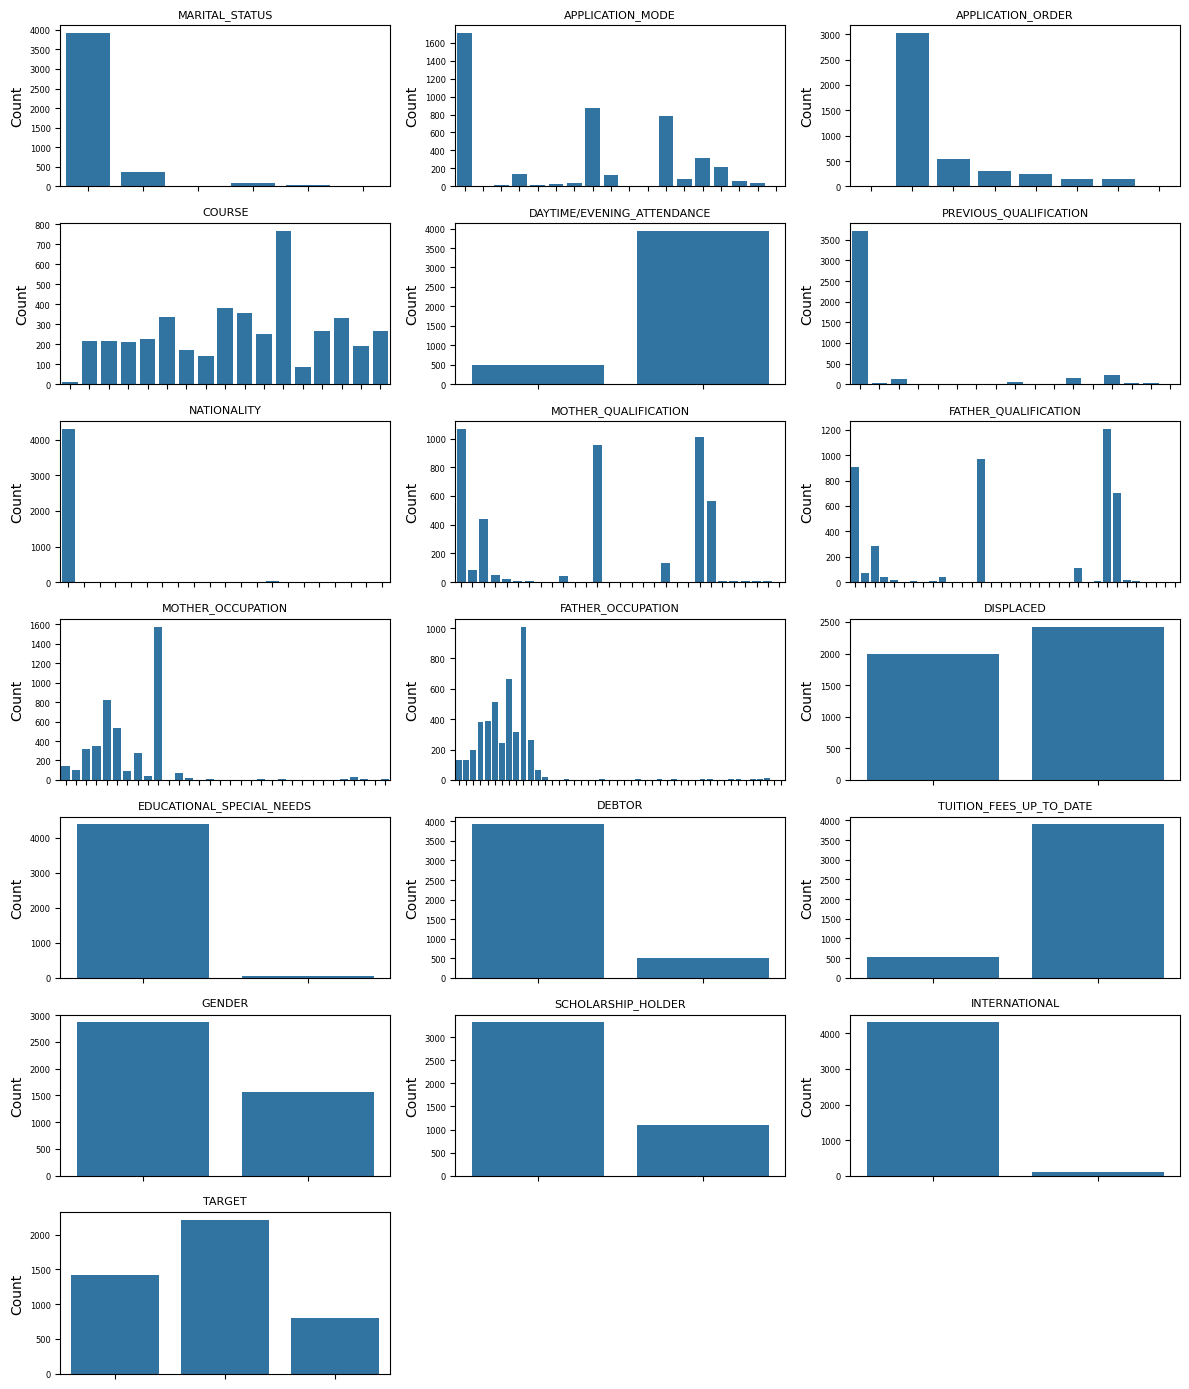

In [17]:
fig_count_plot_cat = plot_count_plot_grid(data, 3, categorical_columns)
save_figure(fig_count_plot_cat, "simple_count_plot_cat.png")

##### Validate International column

In [18]:
# check that every student with NATIONALITY of Portuguese has a INTERNATIONAL value set to 'no'
portuguese_students = data[data['NATIONALITY'] == 'Portuguese']
all_local = portuguese_students['INTERNATIONAL'].eq('no').all()

if all_local:
    print("Data validated: All Portuguese students have 'no' in the INTERNATIONAL column.")
else:
    print("Data Quality error: Not all Portuguese students have 'no' in the INTERNATIONAL column.")

Data validated: All Portuguese students have 'no' in the INTERNATIONAL column.


##### Identified issue with APPLICATION_ORDER

Although APPLICATION_ORDER was described as 0 for 'first choice', most of the rows have a value of 1, so 1 is likely to be the first choice.
- Action: Treating the '0' value an outlier and correcting it to '1'

In [19]:
# correct APPLICATION_ORDER outlier
data.loc[data['APPLICATION_ORDER'] == 0, 'APPLICATION_ORDER'] = 1
print(data['APPLICATION_ORDER'].value_counts()) 

APPLICATION_ORDER
1    3027
2     547
3     309
4     249
5     154
6     137
9       1
Name: count, dtype: int64


##### Identified minority categories

Many of the categories have minority categories that could cause issues with machine learning.
- Action: Process each feature and group classes containing less than 3% of the values into an 'Other' category

In [20]:
# Iterate each categorical column and find low-frequency 'under-represented' categories less than 3% 
# and give them a value higher than any existing category to represent 'Other'
for col in categorical_columns_without_target:

    # Get the highest number that has been assigned to a category and make 'Other' that value + 1
    max_category = data[col].max()
    other_category = max_category + 1

    # Get the frequency counts as percentage
    freq_counts_percentage = data[col].value_counts(normalize=True) * 100  # multiplied by 100 to get percentage
    
    # Find the items that represent less than 3% of the data 
    low_freq_items = freq_counts_percentage[freq_counts_percentage < 3]
    
    # Print low-frequency items as percentage if there are any
    if not low_freq_items.empty:
        print(f"{col} contained these low-frequency categories:")    
        print(low_freq_items)
        print("\n")

    # Replace low-frequency categories with 'other_category'
    low_freq_values = low_freq_items.index
    data[col] = data[col].replace(low_freq_values, other_category)


MARITAL_STATUS contained these low-frequency categories:
MARITAL_STATUS
4    2.056962
5    0.565099
6    0.135624
3    0.090416
Name: proportion, dtype: float64


APPLICATION_MODE contained these low-frequency categories:
APPLICATION_MODE
18    2.802893
42    1.740506
51    1.333635
16    0.858951
53    0.791139
15    0.678119
5     0.361664
10    0.226040
2     0.067812
57    0.022604
26    0.022604
27    0.022604
Name: proportion, dtype: float64


APPLICATION_ORDER contained these low-frequency categories:
APPLICATION_ORDER
9    0.022604
Name: proportion, dtype: float64


COURSE contained these low-frequency categories:
COURSE
9556    1.943942
33      0.271248
Name: proportion, dtype: float64


PREVIOUS_QUALIFICATION contained these low-frequency categories:
PREVIOUS_QUALIFICATION
3     2.848101
12    1.017179
40    0.904159
42    0.813743
2     0.519892
6     0.361664
9     0.248644
4     0.180832
38    0.158228
43    0.135624
10    0.090416
15    0.045208
5     0.022604
14    0.022

In [21]:
print("Summary of Categorical columns after grouping of minority classes")
print("-----------------------------------------------------------------")
cat_summary = report_summary_of_categorical_columns(categorical_columns)
print (cat_summary)
cat_summary.to_csv('processed_data_summary_cat.csv', index=False)

Summary of Categorical columns after grouping of minority classes
-----------------------------------------------------------------
                   Column Name  Unique Classes Data Type
0               MARITAL_STATUS               3     int64
1             APPLICATION_MODE               7     int64
2            APPLICATION_ORDER               7     int64
3                       COURSE              16     int64
4   DAYTIME/EVENING_ATTENDANCE               2     int64
5       PREVIOUS_QUALIFICATION               4     int64
6                  NATIONALITY               2     int64
7         MOTHER_QUALIFICATION               6     int64
8         FATHER_QUALIFICATION               6     int64
9            MOTHER_OCCUPATION               8     int64
10           FATHER_OCCUPATION              11     int64
11                   DISPLACED               2     int64
12   EDUCATIONAL_SPECIAL_NEEDS               2     int64
13                      DEBTOR               2     int64
14     TUITIO

##### Examine gender distribution

In [22]:
# get graduates
gender_counts = data["GENDER"].value_counts(normalize=True) * 100
grad_gender_counts = data[data["TARGET"] == "Graduate"]["GENDER"].value_counts(normalize=True) * 100
# Get the percentage that are females
female_percentage = gender_counts.get(0, 0)
female_grad_percentage = grad_gender_counts.get(0, 0)
print(f"Percentage of students that are female: {female_percentage:.2f}%")
print(f"Percentage of graduates that are female: {female_grad_percentage:.2f}%")

Percentage of students that are female: 64.83%
Percentage of graduates that are female: 75.19%


##### Reexamine NATIONALITY and INTERNATIONAL features

Following the grouping of the minority categories, NATIONALITY and INTERNATIONAL are likely to hold the same information
- check this and drop NATIONALITY if true

In [23]:
# use cross-tab to check if NATIONALITY and INTERNATIONAL hold the same information (display as percentage)
cross_tab = pd.crosstab(data['NATIONALITY'], data['INTERNATIONAL'], normalize=True) * 100
print(cross_tab)


INTERNATIONAL          0         2
NATIONALITY                       
1              97.513562  0.000000
110             0.000000  2.486438


Yes, NATIONALITY and INTERNATIONAL hold the same information

- Action: drop NATIONALITY

In [24]:
# Yes, NATIONALITY and INTERNATIONAL hold the same information, so drop NATIONALITY
categorical_columns.remove('NATIONALITY')
categorical_columns_without_target.remove('NATIONALITY')
data.drop(columns=['NATIONALITY'], inplace=True)



##### Validate DEBTOR and TUITION_FEES_UP_TO_DATE

Those features look similar, see how much of the data matches

In [25]:
# check if students classed as DEBTOR also don't have TUITION_FEES_UP_TO_DATE 
cross_tab = pd.crosstab(data['DEBTOR'], data['TUITION_FEES_UP_TO_DATE'], normalize=True) * 100
print(cross_tab)

# Result: No, about 5% of the students that are considered DEBTORs fall into each category of TUITION_FEES_UP_TO_DATE


TUITION_FEES_UP_TO_DATE         0          1
DEBTOR                                      
0                        6.374322  82.255877
1                        5.560579   5.809222


#### Comments about the categorical data 
- No null/NaN data values found
- APPLICATION_ORDER had a single value of 0 which is likely an outlier data error
  - Action taken: corrected the value to '1'
- Minority categories have been grouped as 'Other'
- Mostly Portuguese students, so after minority grouping, both NATIONALITY and INTERNATIONAL held the same information
  - Action taken: dropped NATIONALITY
  


#### Validate and Clean Continuous data

##### Check for NaN and infinite values

In [26]:
# Look for NaN values
nans = data[continuous_columns].isnull().sum()
if (nans.sum()==0):
    print("Data validated: No NaN values found in the continuous data.")
else:
    print("Data Quality error: NaN values found in the continuous data.")

# Look for +/- infinity
inf_rows_count = data[continuous_columns].isin([np.inf, -np.inf]).any(axis=1).sum()
if (inf_rows_count==0):
    print("Data validated: No infinite values found in the continuous data.")
else:
    print("Data Quality error: Infinite values found in the continuous data.")

Data validated: No NaN values found in the continuous data.
Data validated: No infinite values found in the continuous data.


##### Check GRADE values for out of range issues

In [27]:
# Check if all GRADE values fall in the range defined by the Dataset description
assert data['PREVIOUS_QUALIFICATION_GRADE'].between(0, 200).all(), "Data Error: PREVIOUS_QUALIFICATION_GRADE values are out of range."
assert data['ADMISSION_GRADE'].between(0, 200).all(), "Data Error: ADMISSION_GRADE values are out of range."
assert data['CURR_UNITS_1ST_SEM_GRADE'].between(0, 20).all(), "Data Error: CURR_UNITS_1ST_SEM_GRADE values are out of range."
assert data['CURR_UNITS_2ND_SEM_GRADE'].between(0, 20).all(), "Data Error: CURR_UNITS_2ND_SEM_GRADE values are out of range."

##### Validate the 1st and 2nd semester data

In [28]:
# Investigate the 'enrolled' unit counts
# Check if any students with 0 enrolled units had evaluations or were approved or given grades
data_no_units_enrolled_sem1 = data[(data['CURR_UNITS_1ST_SEM_ENROLLED'] == 0)]
data_no_units_enrolled_sem2 = data[(data['CURR_UNITS_2ND_SEM_ENROLLED'] == 0)]
data_enrolled_in_sem2_but_not_sem1 = data[(data['CURR_UNITS_1ST_SEM_ENROLLED'] == 0) & (data['CURR_UNITS_2ND_SEM_ENROLLED'] > 0)]

data_no_units_enrolled_sem1_but_with_evaluation = data[(data['CURR_UNITS_1ST_SEM_ENROLLED'] == 0) & 
    ( (data['CURR_UNITS_1ST_SEM_EVALUATIONS'] > 0) |
     (data['CURR_UNITS_1ST_SEM_APPROVED'] > 0) |
     (data['CURR_UNITS_1ST_SEM_GRADE'] > 0) |
     (data['CURR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS'] > 0))]

data_no_units_enrolled_sem2_but_with_evaluation = data[(data['CURR_UNITS_2ND_SEM_ENROLLED'] == 0) & 
    ( (data['CURR_UNITS_2ND_SEM_EVALUATIONS'] > 0) |
     (data['CURR_UNITS_2ND_SEM_APPROVED'] > 0) |
     (data['CURR_UNITS_2ND_SEM_GRADE'] > 0) |
     (data['CURR_UNITS_2ND_SEM_WITHOUT_EVALUATIONS'] > 0))]

print(f"Students with no enrollment in 1st Semester: {len(data_no_units_enrolled_sem1)}")
print(f"Students with no enrollment in 2nd Semester: {len(data_no_units_enrolled_sem2)}")
print(f"Students with enrollment in 2nd Semester, but not 1st: {len(data_enrolled_in_sem2_but_not_sem1)}")

print(f"Students with no enrollment in 1st Semester, but with further evaluation or grading: {len(data_no_units_enrolled_sem1_but_with_evaluation)}")
print(f"Students with no enrollment in 2nd Semester, but with further evaluation or grading: {len(data_no_units_enrolled_sem2_but_with_evaluation)}")

# check the Target value counts for those students
data_no_units_enrolled_sem1['TARGET'].value_counts()

Students with no enrollment in 1st Semester: 180
Students with no enrollment in 2nd Semester: 180
Students with enrollment in 2nd Semester, but not 1st: 0
Students with no enrollment in 1st Semester, but with further evaluation or grading: 0
Students with no enrollment in 2nd Semester, but with further evaluation or grading: 0


TARGET
Dropout     77
Graduate    75
Enrolled    28
Name: count, dtype: int64

In [29]:
# drop the rows with no unit enrollment in the 1st semester as that will drop all of the rows with missing curricular unit data
rows_count_before = data.shape[0]
data = data.drop(data[data['CURR_UNITS_1ST_SEM_ENROLLED'] == 0].index)
rows_count_after = data.shape[0]
print(f"Dropped {rows_count_before-rows_count_after} rows leaving {rows_count_after} rows of valid data")

Dropped 180 rows leaving 4244 rows of valid data


Function to cap outliers at upper and lower bounds

In [30]:
def cap_outliers_at_iqr_and_report(data, columns):
    report = {}
    
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # find outliers
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        
        # Calculate the percentage of the column's data that were outliers
        outlier_pct = (len(outliers) / len(data)) * 100
        
        # Cap the outliers at the upper/lower bounds
        data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
        
        # add to the report
        report[col] = round(outlier_pct, 2)

    return pd.DataFrame.from_dict(report, orient='index', columns=['Outlier %'])


Cap the outliers in the continuous columns at upper and lower bounds

In [31]:

# Cap the outliers and report
outlier_report = cap_outliers_at_iqr_and_report(data, continuous_columns)
print(outlier_report)

                                        Outlier %
PREVIOUS_QUALIFICATION_GRADE                 1.60
ADMISSION_GRADE                              2.92
AGE_AT_ENROLLMENT                           10.30
CURR_UNITS_1ST_SEM_CREDITED                 13.60
CURR_UNITS_1ST_SEM_ENROLLED                  8.77
CURR_UNITS_1ST_SEM_EVALUATIONS              10.79
CURR_UNITS_1ST_SEM_APPROVED                  4.24
CURR_UNITS_1ST_SEM_GRADE                    13.10
CURR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS       6.93
CURR_UNITS_2ND_SEM_CREDITED                 12.49
CURR_UNITS_2ND_SEM_ENROLLED                  4.45
CURR_UNITS_2ND_SEM_EVALUATIONS               2.57
CURR_UNITS_2ND_SEM_APPROVED                  2.97
CURR_UNITS_2ND_SEM_GRADE                    16.45
CURR_UNITS_2ND_SEM_WITHOUT_EVALUATIONS       6.64
UNEMPLOYMENT_RATE                            0.00
INFLATION_RATE                               0.00
GDP                                          0.00


#### Comments about the continuous data 
- No null/NaN/infinite data values found
- Grade values are inside defined boundaries
- There are 180 students with a mix of Target data results but with no curricular unit data. This could distort the analysis results.
  - Action taken: dropped those 180 rows.


#### Summarise Continuous data following data clean

In [32]:
print("Summary of Continuous columns after outlier removal/capping")
print("-----------------------------------------------------------")
cont_summary = report_summary_of_continuous_columns(continuous_columns)
print (cont_summary)
cont_summary.to_csv('processed_data_summary_cont.csv', index=False)

Summary of Continuous columns after outlier removal/capping
-----------------------------------------------------------
                                    Column    Mean  Median    Mode     Min  \
0             PREVIOUS_QUALIFICATION_GRADE  132.26  133.00  133.10  100.00   
1                          ADMISSION_GRADE  126.41  125.80  130.00   95.00   
2                        AGE_AT_ENROLLMENT   22.56   20.00   18.00   17.00   
3              CURR_UNITS_1ST_SEM_CREDITED    0.00    0.00    0.00    0.00   
4              CURR_UNITS_1ST_SEM_ENROLLED    6.23    6.00    6.00    4.50   
5           CURR_UNITS_1ST_SEM_EVALUATIONS    8.50    8.00    8.00    2.50   
6              CURR_UNITS_1ST_SEM_APPROVED    4.78    5.00    6.00    0.00   
7                 CURR_UNITS_1ST_SEM_GRADE   12.10   12.33    7.98    7.98   
8   CURR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS    0.00    0.00    0.00    0.00   
9              CURR_UNITS_2ND_SEM_CREDITED    0.00    0.00    0.00    0.00   
10             CURR_UN

## 3) Data Exploration

#### Plot the categorical data split by target result

In [33]:
# Plot a grid (num_cols wide) of bar plots for 'cols' in 'data' split by the target_col
def plot_bar_grid(data, num_cols, cols, target_col='TARGET', palette=target_palette, hue_order=['Dropout', 'Enrolled', 'Graduate']):
    num_rows = -(-len(cols) // num_cols) # uses python technique to round up when cols isn't evenly divisible by num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows))

    #flatten the axs array
    axs = axs.flatten()

    for i, col in enumerate(cols):
        sns.countplot(x=data[col], data=data, hue=data[target_col], ax=axs[i], legend=False,
                    hue_order=hue_order, palette=palette)
        axs[i].set_title(col, fontsize=8)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Count')
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].tick_params(axis='y', labelsize=6)  # Reduce y-axis tick label font size

    # Hide unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    #plt.legend(title=target_col, bbox_to_anchor=(1.05, 1), loc='upper left') 
    
    plt.show()
    return (fig)

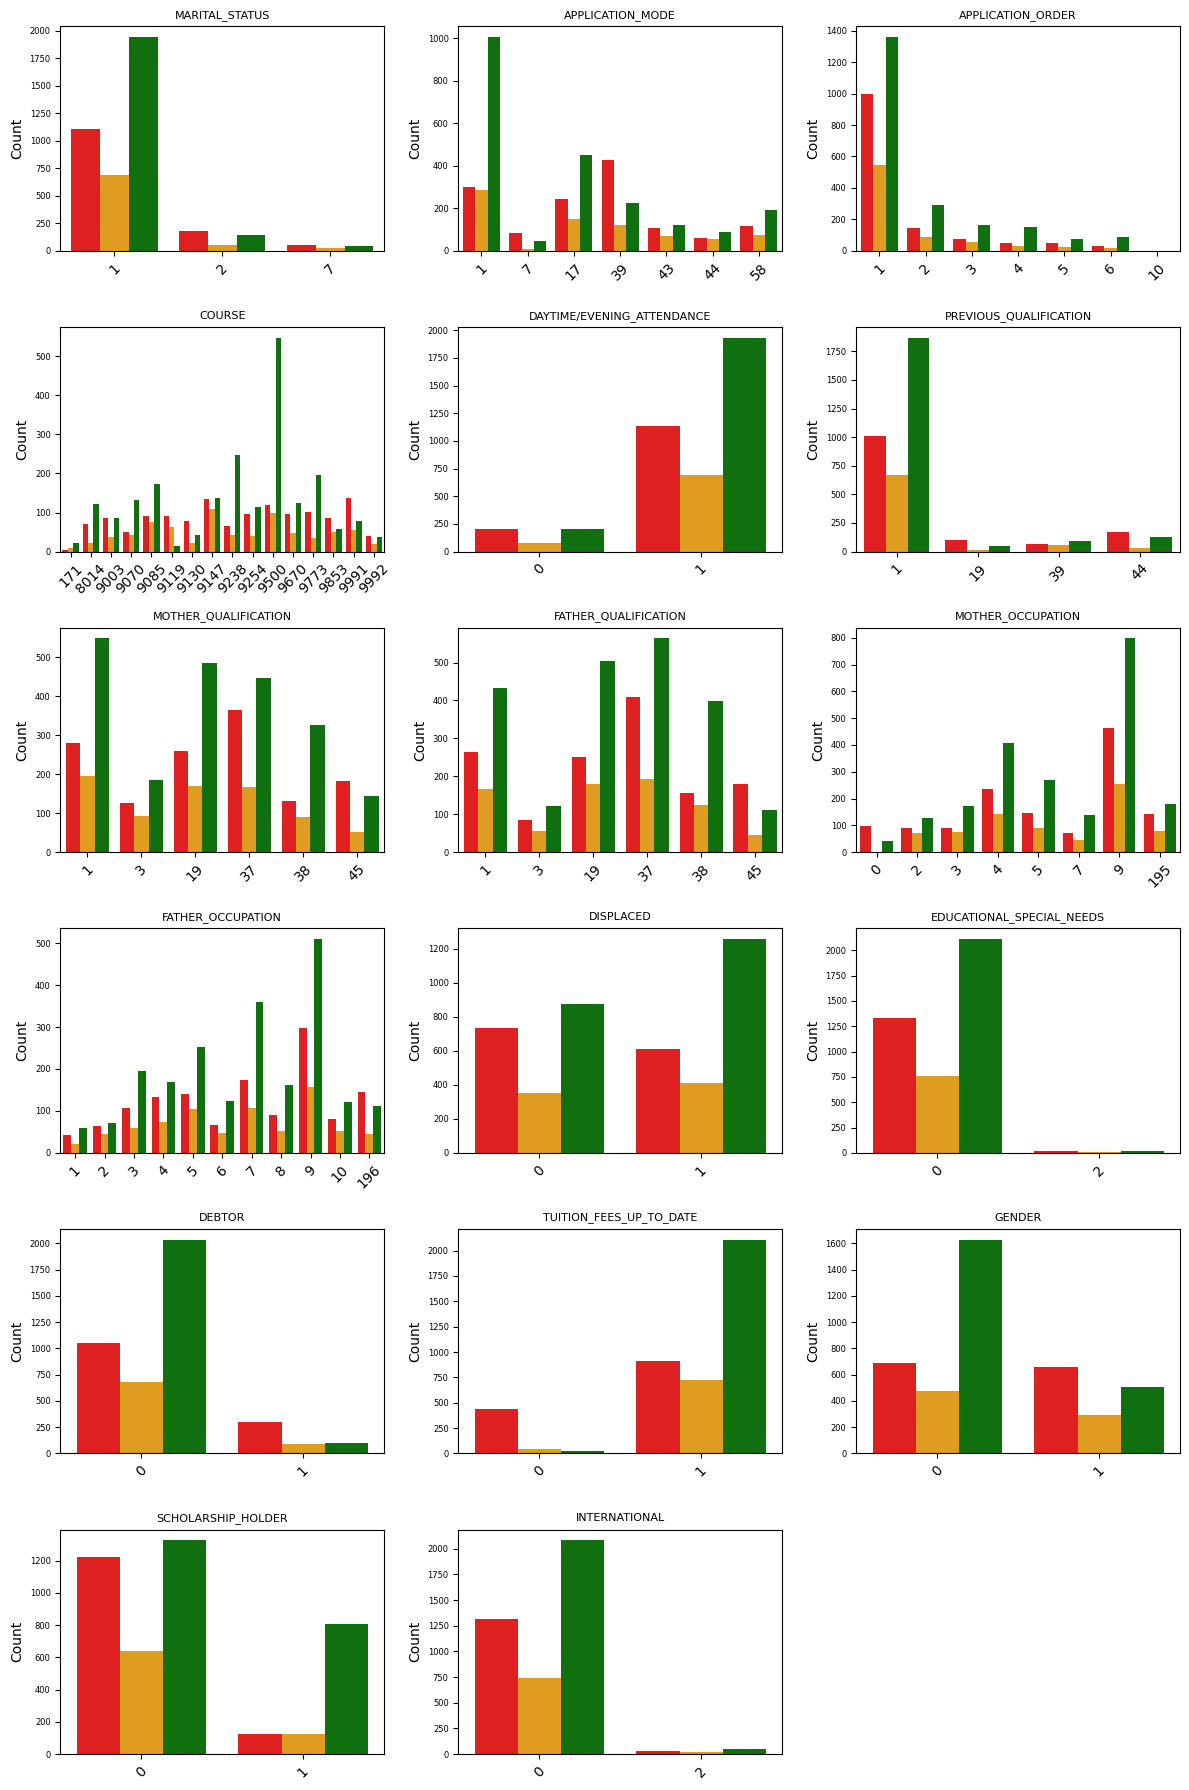

In [34]:
fig_bar_split_by_target_cat = plot_bar_grid(data, 3, categorical_columns_without_target)
save_figure(fig_bar_split_by_target_cat, "split_by_target_bar_cat.png")

#### Show the male/female split of each category

In [35]:
# Plot a grid (num_cols wide) of bar plots (as percentages) for 'cols' in 'data' split by the specified target_col
def plot_bar_as_percentage_grid(data, num_cols, cols, target_col='TARGET', palette=target_palette, hue_order=['Dropout', 'Enrolled', 'Graduate']):
    num_rows = -(-len(cols) // num_cols) # uses python technique to round up when cols isn't evenly divisible by num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows))

    #flatten the axs array
    axs = axs.flatten()

    for i, col in enumerate(cols):
        # Calculate percentages
        grouped = data.groupby([col, target_col]).size().unstack(fill_value=0)
        percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100  # Convert to percentage
        
        # Plot the stacked bar chart
        percentages.plot(kind='bar', stacked=True, ax=axs[i], color=[palette[hue] for hue in hue_order], legend=False)
        
        axs[i].set_title(col, fontsize=8)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Percentage')
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].tick_params(axis='y', labelsize=6)  # Reduce y-axis tick label font size

        # Set y-axis to percentage format
        axs[i].set_yticks(range(0, 101, 20))
        axs[i].set_yticklabels([f"{x}%" for x in range(0, 101, 20)])

    # Hide unused subplots
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    
    plt.show()
    return (fig)

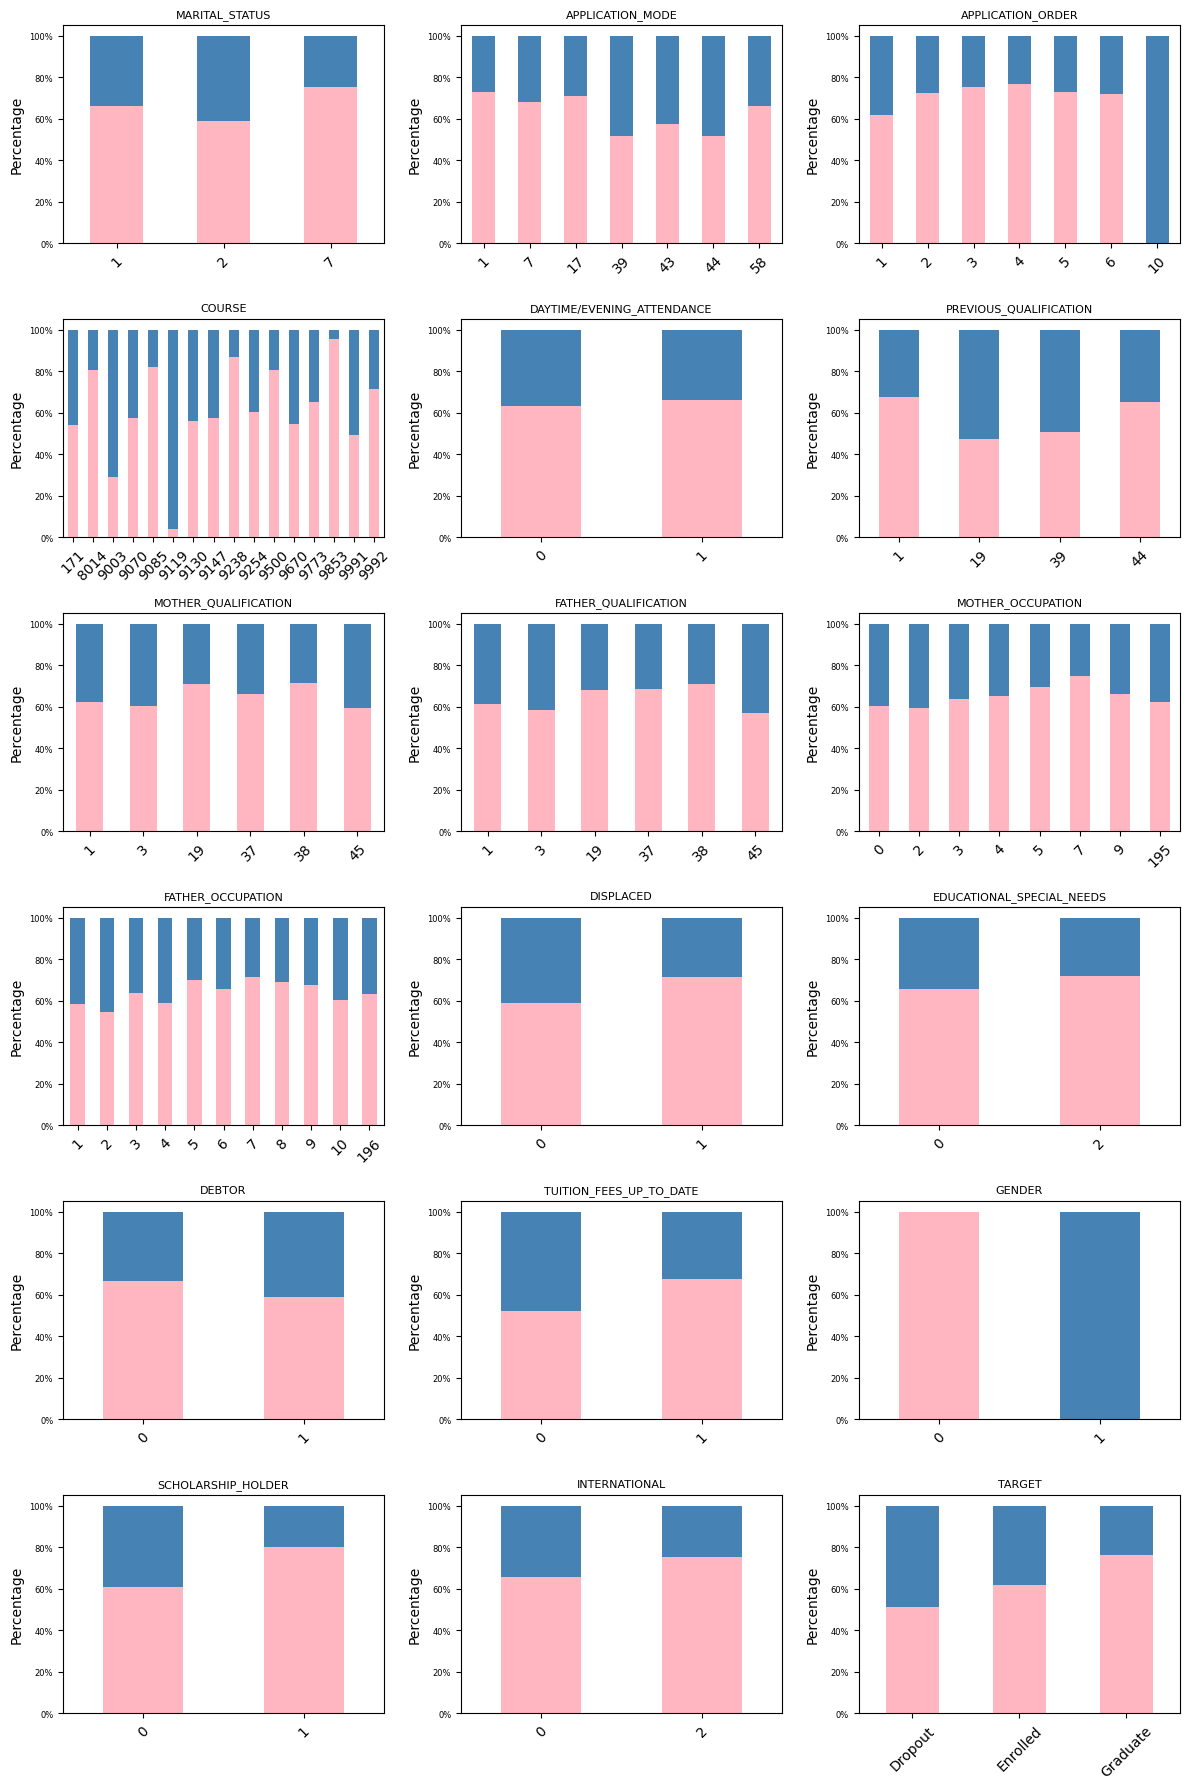

In [36]:
fig_percent_bar_split_by_gender_cat = plot_bar_as_percentage_grid(data, 3, categorical_columns, 'GENDER', gender_palette, hue_order=[0, 1])
save_figure(fig_percent_bar_split_by_gender_cat, "split_by_gender_percent_bar_cat.png")

#### Visualise continuous data with histogram boxplot pairs

In [37]:
def plot_hist_and_box(data, cols):
    # Set up grid size
    num_cols = 2  # Histogram (left) and Boxplot (right)
    num_rows = len(cols)

    target_order = ['Dropout', 'Enrolled', 'Graduate']

    # Create the figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, num_rows * 3))

    for i, col in enumerate(cols):
        # Histogram on the left
        sns.histplot(data[col], bins=30, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'{col}', fontsize=9)
        axes[i, 0].set_xlabel(f'{col}', fontsize=8)
        axes[i, 0].set_ylabel('Count', fontsize=8)
        axes[i, 0].tick_params(axis='both', labelsize=7)

        # Boxplot on the right (split by TARGET)
        sns.boxplot(x=data['TARGET'], 
                    y=data[col], 
                    order=target_order, 
                    hue=data['TARGET'],
                    palette=target_palette,
                    ax=axes[i, 1])
        axes[i, 1].set_title(f'{col} by TARGET', fontsize=9)
        axes[i, 1].set_xlabel('TARGET', fontsize=8)
        axes[i, 1].set_ylabel(f'{col}', fontsize=8)
        axes[i, 1].tick_params(axis='both', labelsize=7)

    plt.tight_layout()
    plt.show()
    return (fig)

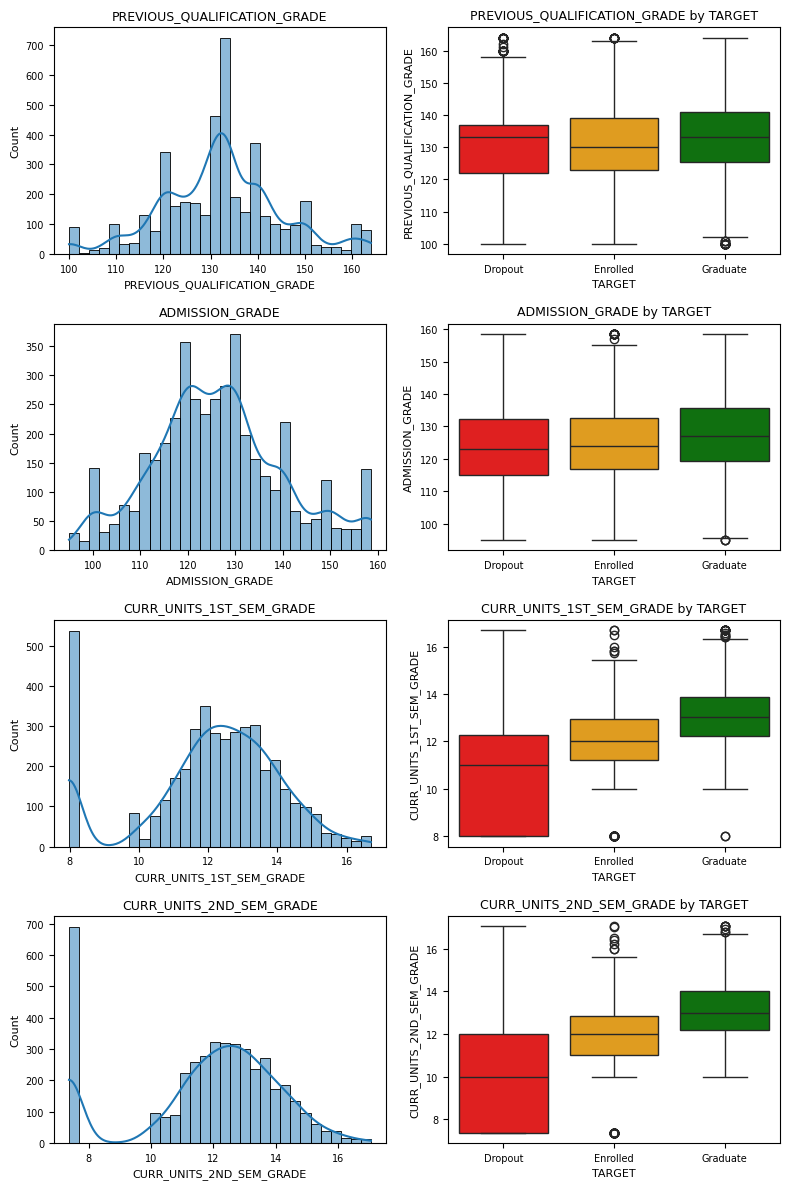

In [38]:
# define groups of columns for visualisation

continuous_columns_grades = [    
    'PREVIOUS_QUALIFICATION_GRADE',
    'ADMISSION_GRADE',
    'CURR_UNITS_1ST_SEM_GRADE',
    'CURR_UNITS_2ND_SEM_GRADE',
]

continuous_columns_units = [    
    'CURR_UNITS_1ST_SEM_CREDITED',
    'CURR_UNITS_2ND_SEM_CREDITED',
    'CURR_UNITS_1ST_SEM_ENROLLED',
    'CURR_UNITS_2ND_SEM_ENROLLED',
    'CURR_UNITS_1ST_SEM_EVALUATIONS',
    'CURR_UNITS_2ND_SEM_EVALUATIONS',
    'CURR_UNITS_1ST_SEM_APPROVED',
    'CURR_UNITS_2ND_SEM_APPROVED',
    'CURR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS',
    'CURR_UNITS_2ND_SEM_WITHOUT_EVALUATIONS',
]

continuous_columns_other = [    
    'AGE_AT_ENROLLMENT',
    'UNEMPLOYMENT_RATE',
    'INFLATION_RATE',
    'GDP'
]

fig_grades_box = plot_hist_and_box(data, continuous_columns_grades)
save_figure(fig_grades_box, "boxplot_grades.png")



Each grade shows normal distribution, but both 1st & 2nd Semester grades have a large count in the lowest grade bin. 
Looking at the boxplot by target, the lowest grades appear to be mostly due to students that will dropout, so that 
data point is likely to be useful for prediction.
In general, the box plots indicate that higher grades increase the chance of graduation (which makes sense). However the median line of PREVIOUS_QUALIFICATION_GRADE 'Enrolled' is lower than 'Dropout', so that feature is likely to be less useful.


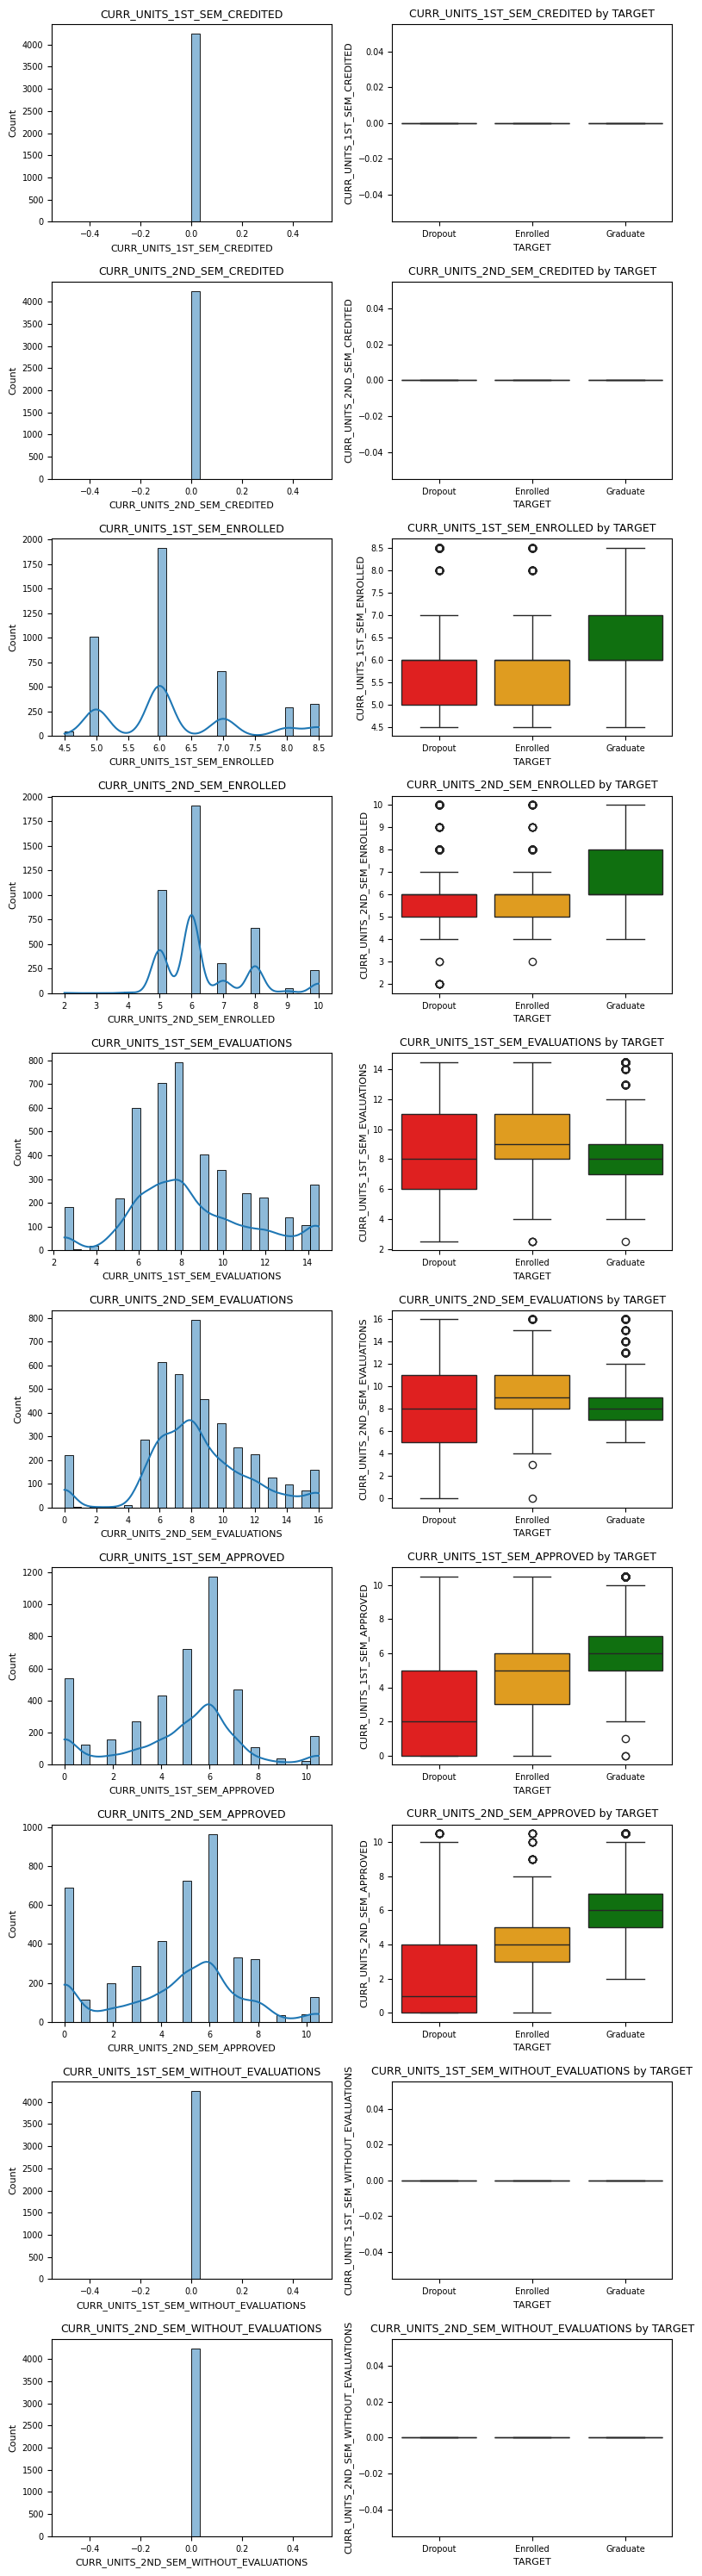

In [39]:

fig_units_box = plot_hist_and_box(data, continuous_columns_units)
save_figure(fig_units_box, "boxplot_units.png")


In [40]:

data[continuous_columns_units].describe()

CURR_UNITS_1ST_SEM_CREDITED  CURR_UNITS_2ND_SEM_CREDITED  \
count                       4244.0                       4244.0   
mean                           0.0                          0.0   
std                            0.0                          0.0   
min                            0.0                          0.0   
25%                            0.0                          0.0   
50%                            0.0                          0.0   
75%                            0.0                          0.0   
max                            0.0                          0.0   

       CURR_UNITS_1ST_SEM_ENROLLED  CURR_UNITS_2ND_SEM_ENROLLED  \
count                  4244.000000                  4244.000000   
mean                      6.230914                     6.372997   
std                       1.059251                     1.358326   
min                       4.500000                     2.000000   
25%                       6.000000                     5.000000   
50%                       6.000000                     6.000000   
75%                       7.000000                     7.000000   
max                       8.500000                    10.000000   

       CURR_UNITS_1ST_SEM_EVALUATIONS  CURR_UNITS_2ND_SEM_EVALUATIONS  \
count                     4244.000000                     4244.000000   
mean                         8.503534                        8.308671   
std                          2.927695                        3.363641   
min                          2.500000                        0.000000   
25%                          7.000000                        6.000000   
50%                          8.000000                        8.000000   
75%                         10.000000                       10.000000   
max                         14.500000                       16.000000   

       CURR_UNITS_1ST_SEM_APPROVED  CURR_UNITS_2ND_SEM_APPROVED  \
count                  4244.000000                  4244.000000   
mean                      4.778040                     4.560085   
std                       2.611362                     2.750707   
min                       0.000000                     0.000000   
25%                       3.000000                     3.000000   
50%                       5.000000                     5.000000   
75%                       6.000000                     6.000000   
max                      10.500000                    10.500000   

       CURR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS  \
count                                  4244.0   
mean                                      0.0   
std                                       0.0   
min                                       0.0   
25%                                       0.0   
50%                                       0.0   
75%                                       0.0   
max                                       0.0   

       CURR_UNITS_2ND_SEM_WITHOUT_EVALUATIONS  
count                                  4244.0  
mean                                      0.0  
std                                       0.0  
min                                       0.0  
25%                                       0.0  
50%                                       0.0  
75%                                       0.0  
max                                       0.0

The CREDITED and WITHOUT_EVALUATIONS features are all zero now that outliers have been removed, so will be dropped.

Of the remaining plots, UNITS_APPROVED for both semesters show higher boxes for Enrolled than Dropout and higher Graduate than Enrolled. A good indicator they will be predictive. 

In general 1st & 2nd Semester data is similar, so perhaps could be combined to carry less features into Machine Learning.

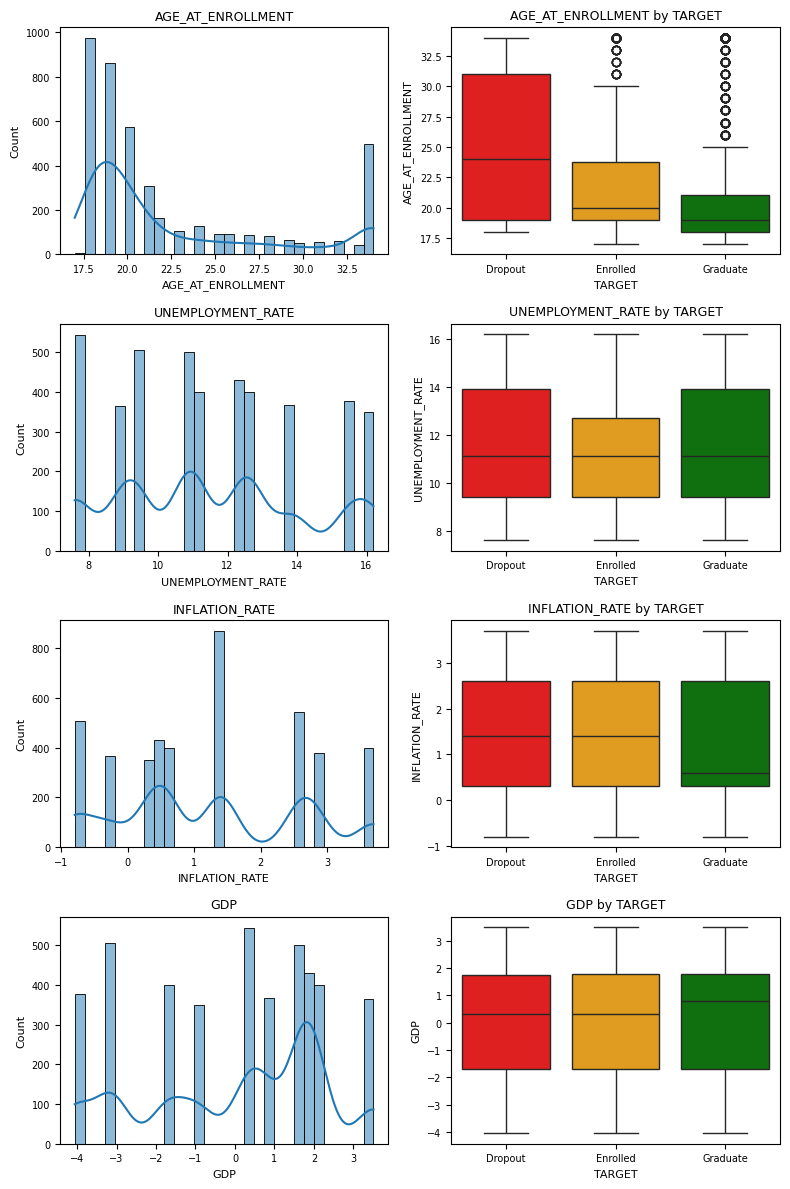

In [41]:

fig_age_box = plot_hist_and_box(data, continuous_columns_other)
save_figure(fig_age_box, "boxplot_age.png")


The distribution of Age at Enrollment is biased towards the lower ages with a long tail.
The box plots indicate that lower age groups are more likely to graduate.

The economic features do not appear to be that correlated to Target.

#### Drop _CREDITED and _WITHOUT_EVALUATIONS features

In [42]:
data = data.drop(columns=['CURR_UNITS_1ST_SEM_CREDITED', 'CURR_UNITS_2ND_SEM_CREDITED', 'CURR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS', 'CURR_UNITS_2ND_SEM_WITHOUT_EVALUATIONS'])
continuous_columns.remove('CURR_UNITS_1ST_SEM_CREDITED')
continuous_columns.remove('CURR_UNITS_2ND_SEM_CREDITED')
continuous_columns.remove('CURR_UNITS_1ST_SEM_WITHOUT_EVALUATIONS')
continuous_columns.remove('CURR_UNITS_2ND_SEM_WITHOUT_EVALUATIONS')


#### Feature Engineering

##### Create AGE_GROUP_AT_ENROLLMENT feature

In [43]:
# Create the age group at enrollment feature by binning the AGE_AT_ENROLLMENT values

# Define the bins
bins = [0, 20, 23, 28, float('inf')]  # age bins

# Create a new column for the binned age groups
data['AGE_GROUP_AT_ENROLLMENT'] = pd.cut(data['AGE_AT_ENROLLMENT'], bins=bins).astype(str)

# Add the column to the categorical columns
categorical_columns.append('AGE_GROUP_AT_ENROLLMENT')


##### Create Summary features of 1st and 2nd Semester data

In [44]:

# combine the 1st & 2nd semester as they information is highly correlated
# total the UNITS count
data['CURR_UNITS_TOTAL_ENROLLED'] = (
    data['CURR_UNITS_1ST_SEM_ENROLLED'] + data['CURR_UNITS_2ND_SEM_ENROLLED']
)

data['CURR_UNITS_TOTAL_EVALUATIONS'] = (
    data['CURR_UNITS_1ST_SEM_EVALUATIONS'] + data['CURR_UNITS_2ND_SEM_EVALUATIONS']
)

data['CURR_UNITS_TOTAL_APPROVED'] = (
    data['CURR_UNITS_1ST_SEM_APPROVED'] + data['CURR_UNITS_2ND_SEM_APPROVED']
)

# average the grades
data['CURR_UNITS_AVG_GRADE'] = (
    data['CURR_UNITS_1ST_SEM_GRADE'] + data['CURR_UNITS_2ND_SEM_GRADE']
) / 2


# Add them to the continuous columns
continuous_columns.append('CURR_UNITS_TOTAL_ENROLLED')
continuous_columns.append('CURR_UNITS_TOTAL_EVALUATIONS')
continuous_columns.append('CURR_UNITS_TOTAL_APPROVED')
continuous_columns.append('CURR_UNITS_AVG_GRADE')

#### Investigate the correlation between each of the continuous features and their correlation with the binary target features.

In [45]:
def plot_a_correlation_heatmap(data, cols, title):
    
    # Calculate Pearson correlation matrix
    corr_matrix = data[cols].corr()
    
    # Create a Heatmap with Seaborn
    # Set figure size
    fig = plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(title)

    # Show plot
    plt.show()
    return (fig)

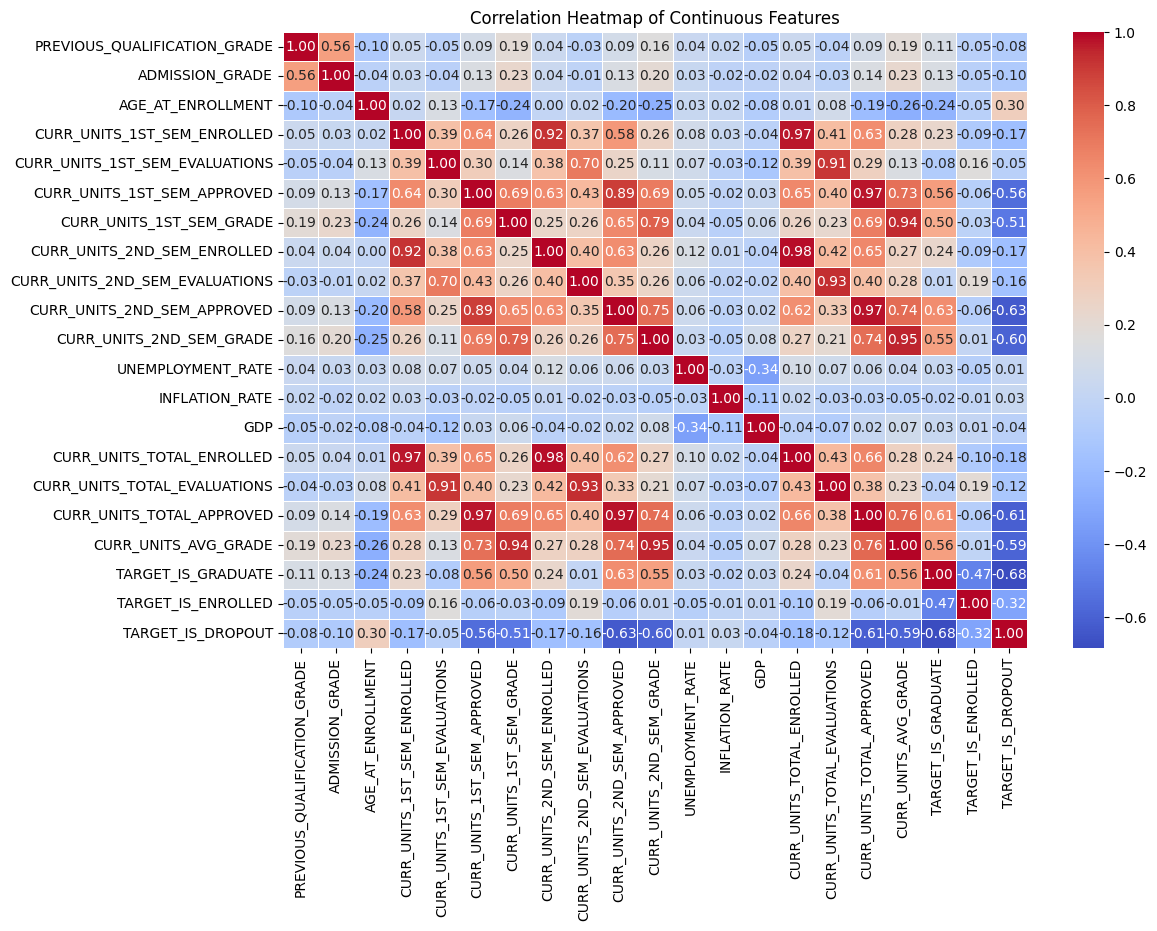

In [46]:
# Plot a correlation heatmap
cols_for_corr = continuous_columns + ["TARGET_IS_GRADUATE", "TARGET_IS_ENROLLED", "TARGET_IS_DROPOUT"]
fig_corr_heatmap = plot_a_correlation_heatmap(data, cols_for_corr, "Correlation Heatmap of Continuous Features")
save_figure(fig_corr_heatmap, "heatmap1.png")

Findings:

- 1st Sem Enrolled is highly correlated with 2nd Sem Enrolled and Total Enrolled
- 1st Sem Evaluations is highly correlated with 2nd Sem Evaluations and Total Evaluations
- 1st Sem Approved is highly correlated with 2nd Sem Approved, Total Approved and Average Grade 
- 1st Sem Grade is highly correlated with 2nd Sem Grade and Average Grade

- Only the TARGET_IS_DROPOUT feature has a high negative correlation with other values (1st & 2nd semester APPROVED and GRADE)

To avoid multicollinearity, likely to only to be able to chose one of each feature type between 1st, 2nd, and Summary


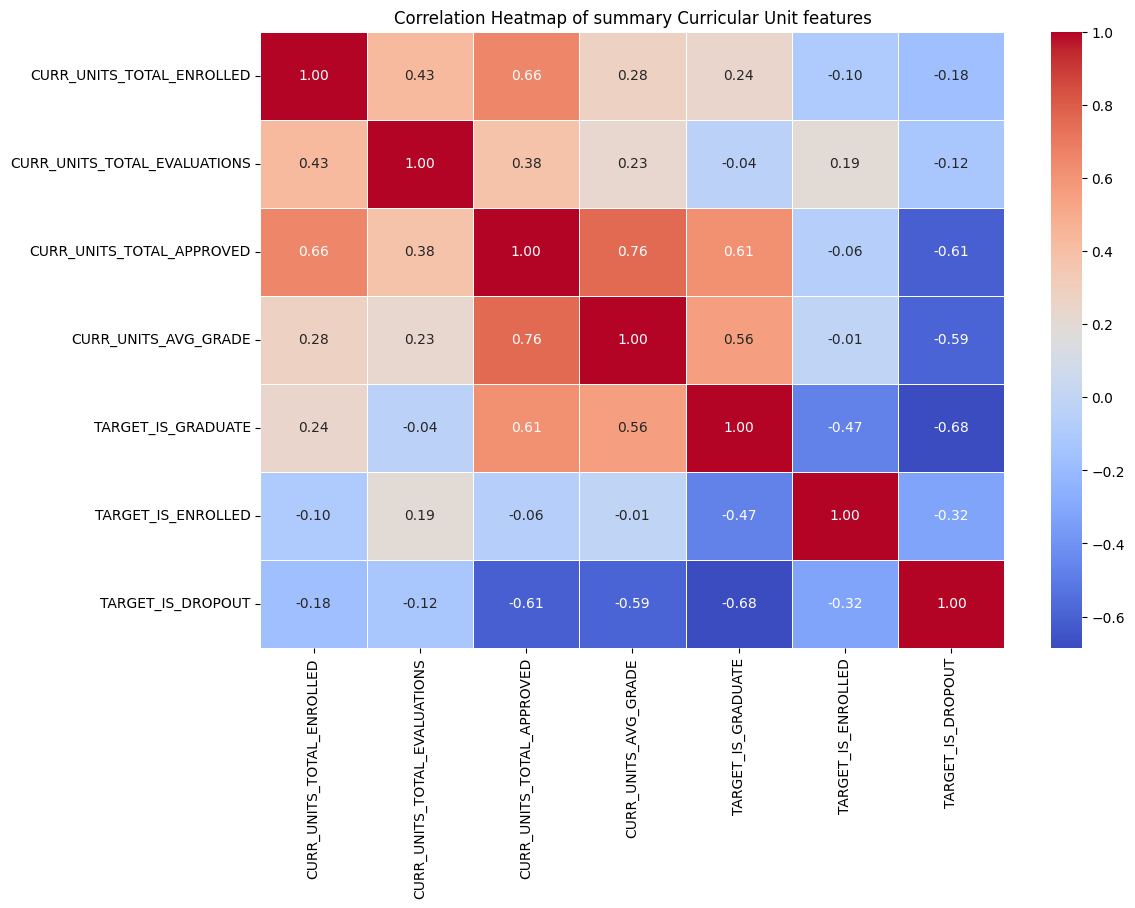

In [47]:
curr_unit_columns = [
    'CURR_UNITS_TOTAL_ENROLLED',
    'CURR_UNITS_TOTAL_EVALUATIONS',
    'CURR_UNITS_TOTAL_APPROVED',
    'CURR_UNITS_AVG_GRADE'
]

# Plot A correlation heatmap
cols_for_corr = curr_unit_columns + ["TARGET_IS_GRADUATE", "TARGET_IS_ENROLLED", "TARGET_IS_DROPOUT"]
fig_corr_heatmap_summary = plot_a_correlation_heatmap(data, cols_for_corr, "Correlation Heatmap of summary Curricular Unit features")

#### Visualise using Pair Plots

In [48]:
def show_pairplot(data, cols): 
    # Create the pair plot with Seaborn for three selected features
    pairplot = sns.pairplot(
        data = data,
        vars = cols,
        hue = "TARGET",
        palette=target_palette,
        #plot_kws = {"alpha": 0.2},
        #height = 3,
        diag_kind = "kde",
        #diag_kws = {"bins": 30}
    )

    # Adjust individual elements' font size
    for ax in pairplot.axes.flatten():
        ax.set_xlabel(ax.get_xlabel(), fontsize=8)  # Adjust x-axis label font size
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Adjust y-axis label font size
        ax.tick_params(axis='both', which='major', labelsize=6)  # Adjust tick label font size

    # Show the plot
    plt.show()
    return (pairplot)

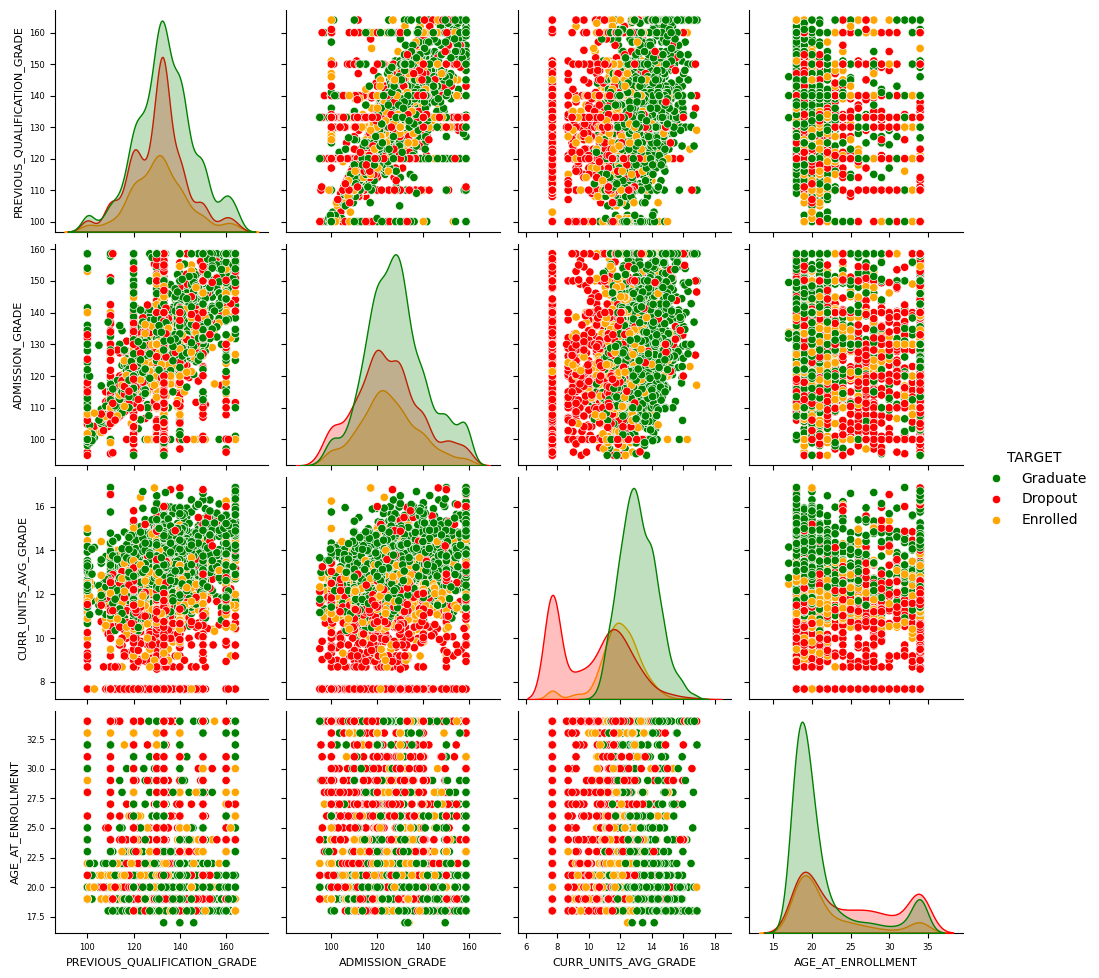

In [49]:
pairplot_grade_age = show_pairplot(data, ['PREVIOUS_QUALIFICATION_GRADE', 'ADMISSION_GRADE', 'CURR_UNITS_AVG_GRADE','AGE_AT_ENROLLMENT'])
save_figure(pairplot_grade_age, "pairplot_grade_age.png")

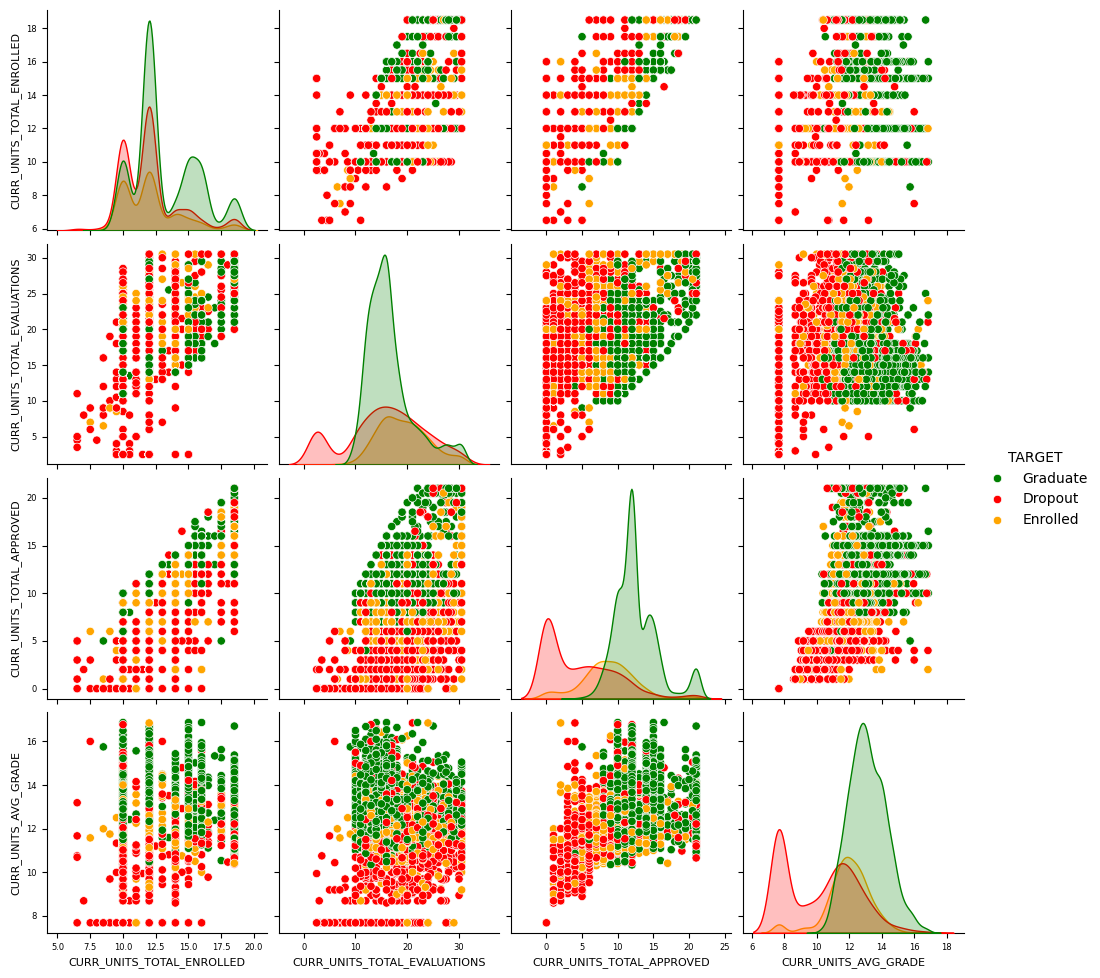

In [50]:
pairplot_unit_summary = show_pairplot(data, ['CURR_UNITS_TOTAL_ENROLLED', 'CURR_UNITS_TOTAL_EVALUATIONS', 'CURR_UNITS_TOTAL_APPROVED', 'CURR_UNITS_AVG_GRADE'])
save_figure(pairplot_unit_summary, "pairplot_unit_summary.png")


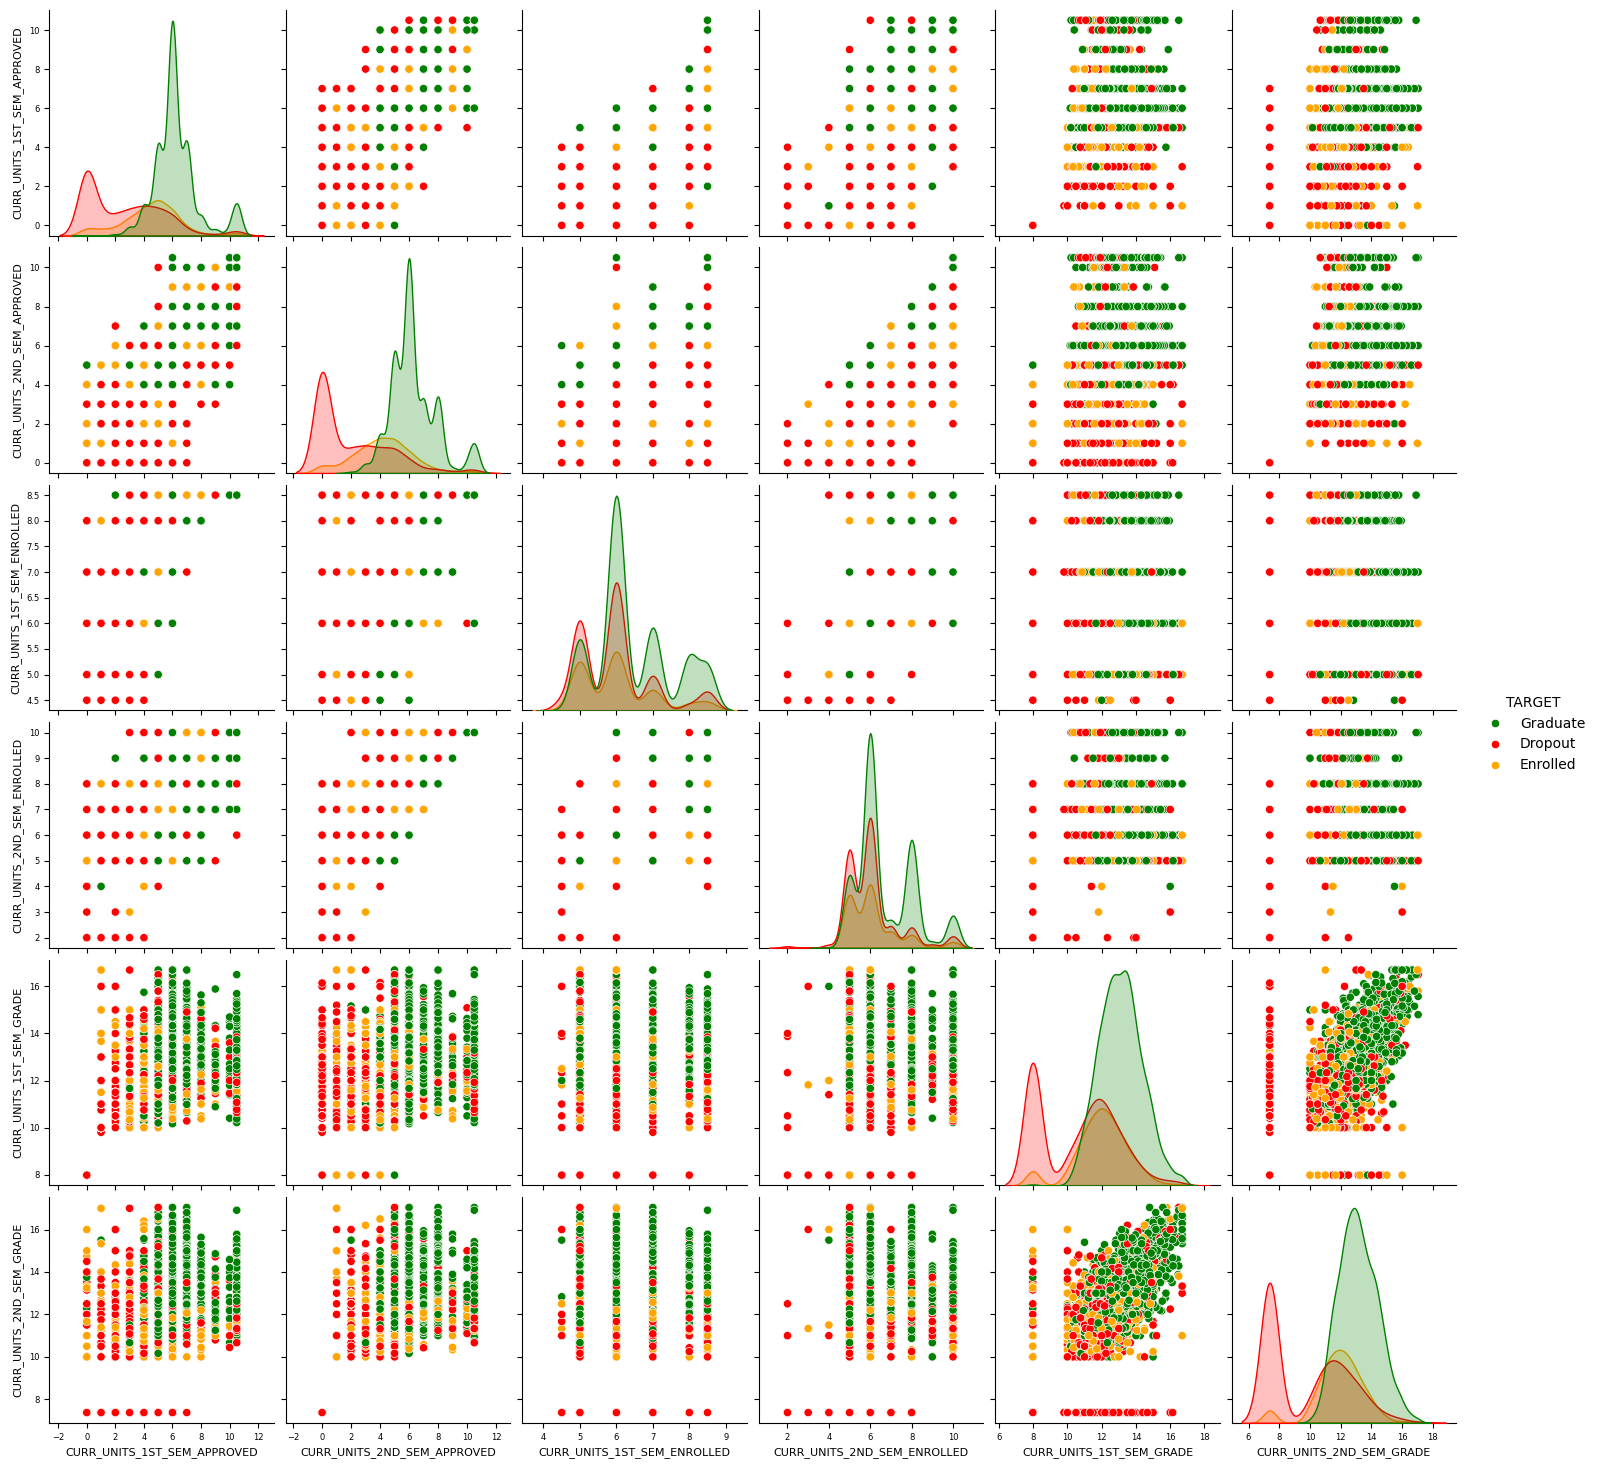

In [51]:
pairplot_unit_approved_enrolled_grades = show_pairplot(data, ['CURR_UNITS_1ST_SEM_APPROVED', 'CURR_UNITS_2ND_SEM_APPROVED', 
                     'CURR_UNITS_1ST_SEM_ENROLLED', 'CURR_UNITS_2ND_SEM_ENROLLED',
                     'CURR_UNITS_1ST_SEM_GRADE', 'CURR_UNITS_2ND_SEM_GRADE'])
save_figure(pairplot_unit_approved_enrolled_grades, "pairplot_app_enr_grades.png")

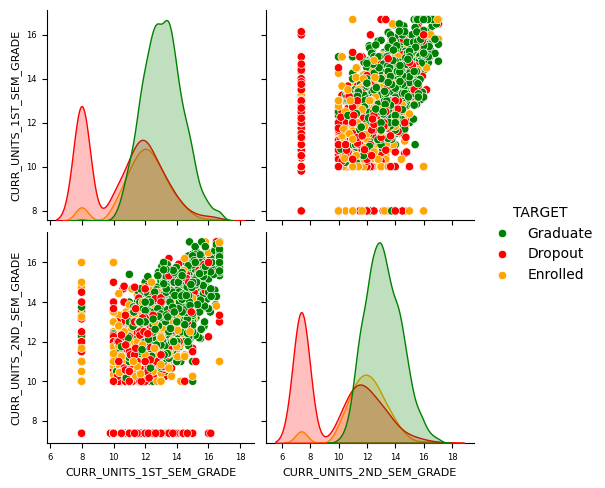

In [52]:
#Take a closer look at 1st & 2nd semester grades
pairplot_grades = show_pairplot(data, ['CURR_UNITS_1ST_SEM_GRADE', 'CURR_UNITS_2ND_SEM_GRADE'])
save_figure(pairplot_grades, "pairplot_grades.png")

#### Conclusions

Summarising the findings of the exploration:

Most students are: 

-	single
-   97.5% are not international
-	studying at their first choice university in the daytime
-	89.9% are not classed as educational special needs
-	not classed as DEBTOR
-	not late with tuition fee payments.
When looking in terms relative counts of each Target:
-	COURSE 9500 (Nursing) stands out as having a high proportion of Graduate students.
-	DEBTOR students and ones late with tuition fees have a relatively high proportion of Dropout.
-	Being a SCHOLARSHIP_HOLDER shows a high probability of graduating.
From the Gender percentage chart
-	There are more females (65.7%) than males (34.3%).
-	COURSE 9119 (Informatics Engineering) is primarily male and had a very low proportion of graduates.
-	76% of graduates are female.

Each grade shows normal distribution, but both 1st & 2nd Semester grades have a large count in the lowest grade bin. 
Looking at the boxplot by target, the lowest grades appear to be mostly due to students that will dropout, so that 
data point is likely to be useful for prediction.
In general, the box plots indicate that higher grades increase the chance of graduation (which makes sense). However the median line of PREVIOUS_QUALIFICATION_GRADE 'Enrolled' is lower than 'Dropout', so that feature is likely to be less useful.

The CREDITED and WITHOUT_EVALUATIONS features are all zero now that outliers have been removed, so will be dropped.

Of the remaining plots, UNITS_APPROVED for both semesters show higher boxes for Enrolled than Dropout and higher Graduate than Enrolled. A good indicator they will be predictive.

In general 1st & 2nd Semester data is similar, so perhaps could be combined to carry less features into Machine Learning.

- 1st Sem Enrolled is highly correlated with 2nd Sem Enrolled and Total Enrolled
- 1st Sem Evaluations is highly correlated with 2nd Sem Evaluations and Total Evaluations
- 1st Sem Approved is highly correlated with 2nd Sem Approved, Total Approved and Average Grade 
- 1st Sem Grade is highly correlated with 2nd Sem Grade and Average Grade

- Only the TARGET_IS_DROPOUT feature has a high negative correlation with other values (1st & 2nd semester APPROVED and GRADE)

- To avoid multicollinearity, likely only to be able to chose one of each feature type between 1st, 2nd, and Summary


The distribution of Age at Enrollment is biased towards the lower ages with a long tail.
The box plots indicate that lower age groups are more likely to graduate.

The economic features do not appear to be that correlated to Target.


## 4) Feature selection using Hypothesis testing 

#### Investigate correlation between categorical features and target

Chi-Squared tests will be used to correlate each categorical feature against:
- Graduate/Enrolled/Dropout target value (for RQ1)
- Individual binary categories of TARGET_IS_GRADUATE, TARGET_IS_ENROLLED, TARGET_IS_DROPOUT (for RQ2)

In each case the Null Hypothesis will be that the feature being tested is independent from the target feature.
If the p-value < = 0.05 then the null hypothesis will be rejected.


In [53]:
def run_chi_squared_tests_against_target(data, columns, target_column="TARGET" ):
    results = []  
    
    for col in columns:
        if (col != target_column):  # skip the target_column itself
            # Create a contingency table
            ct = pd.crosstab(data[col], data[target_column])
        
            # Chi-Square Test
            chi2, p, fr, ex = chi2_contingency(ct)
        
            if (p <= 0.05):
                relation = "Related"
                null_hypothesis = "Rejected"
            else:
                relation = "Not Related"
                null_hypothesis = "Not Rejected"


            # Store results
            results.append({"Column": col, "Chi-Square": chi2, "P-value": p, "Relation": relation, "Null Hypothesis": null_hypothesis})
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by p-value (ascending)
    results_df = results_df.sort_values(by="P-value", ascending=True)
    
    return results_df

In [54]:
# Perform Chi-Squared tests on each of the categorical columns to how dependant Target is on them
chi_results_table = run_chi_squared_tests_against_target(data, categorical_columns, "TARGET")
print("Use Chi-Squared to test a features assocation with TARGET")
print("---------------------------------------------------------")
print("Null Hypothesis: These is no relation between the Feature and TARGET")
chi_results_table

Use Chi-Squared to test a features assocation with TARGET
---------------------------------------------------------
Null Hypothesis: These is no relation between the Feature and TARGET


Column  Chi-Square        P-value     Relation  \
13     TUITION_FEES_UP_TO_DATE  807.250736  5.101876e-176      Related   
17     AGE_GROUP_AT_ENROLLMENT  468.294142   5.660779e-98      Related   
3                       COURSE  554.937028   6.080470e-98      Related   
15          SCHOLARSHIP_HOLDER  402.312967   4.353608e-88      Related   
1             APPLICATION_MODE  424.268064   2.726087e-83      Related   
12                      DEBTOR  251.147448   2.910882e-55      Related   
14                      GENDER  238.037257   2.045815e-52      Related   
5       PREVIOUS_QUALIFICATION  166.730709   2.219453e-33      Related   
7         FATHER_QUALIFICATION  119.476368   6.462400e-21      Related   
8            MOTHER_OCCUPATION  127.652302   1.974413e-20      Related   
6         MOTHER_QUALIFICATION  102.617220   1.629339e-17      Related   
10                   DISPLACED   60.780531   6.333960e-14      Related   
0               MARITAL_STATUS   61.397446   1.474877e-12      Related   
2            APPLICATION_ORDER   65.984314   1.792162e-09      Related   
9            FATHER_OCCUPATION   72.627170   6.745071e-08      Related   
4   DAYTIME/EVENING_ATTENDANCE   31.609155   1.368230e-07      Related   
16               INTERNATIONAL    2.252968   3.241711e-01  Not Related   
11   EDUCATIONAL_SPECIAL_NEEDS    0.562144   7.549738e-01  Not Related   

   Null Hypothesis  
13        Rejected  
17        Rejected  
3         Rejected  
15        Rejected  
1         Rejected  
12        Rejected  
14        Rejected  
5         Rejected  
7         Rejected  
8         Rejected  
6         Rejected  
10        Rejected  
0         Rejected  
2         Rejected  
9         Rejected  
4         Rejected  
16    Not Rejected  
11    Not Rejected

In [55]:
# Perform Chi-Squared tests on each of the categorical columns for each of the binary targets
chi_results_table = run_chi_squared_tests_against_target(data, categorical_columns_without_target, "TARGET_IS_GRADUATE")
print("Use Chi-Squared to test a features assocation with TARGET_IS_GRADUATE")
print("---------------------------------------------------------------------")
print("Null Hypothesis: These is no relation between the Feature and TARGET_IS_GRADUATE")
chi_results_table

Use Chi-Squared to test a features assocation with TARGET_IS_GRADUATE
---------------------------------------------------------------------
Null Hypothesis: These is no relation between the Feature and TARGET_IS_GRADUATE


Column  Chi-Square        P-value     Relation  \
13     TUITION_FEES_UP_TO_DATE  462.521302  1.358988e-102      Related   
3                       COURSE  486.175767   4.735034e-94      Related   
15          SCHOLARSHIP_HOLDER  387.217530   3.339103e-86      Related   
1             APPLICATION_MODE  276.163056   1.041084e-56      Related   
14                      GENDER  212.003448   5.020880e-48      Related   
12                      DEBTOR  194.456145   3.386169e-44      Related   
7         FATHER_QUALIFICATION   67.158952   3.993422e-13      Related   
5       PREVIOUS_QUALIFICATION   58.718533   1.104018e-12      Related   
10                   DISPLACED   47.178717   6.480028e-12      Related   
6         MOTHER_QUALIFICATION   59.130925   1.837662e-11      Related   
2            APPLICATION_ORDER   58.105779   1.090720e-10      Related   
0               MARITAL_STATUS   32.160730   1.038451e-07      Related   
9            FATHER_OCCUPATION   48.608522   4.804292e-07      Related   
8            MOTHER_OCCUPATION   40.060198   1.225833e-06      Related   
4   DAYTIME/EVENING_ATTENDANCE   15.991139   6.363965e-05      Related   
11   EDUCATIONAL_SPECIAL_NEEDS    0.233593   6.288726e-01  Not Related   
16               INTERNATIONAL    0.000000   1.000000e+00  Not Related   

   Null Hypothesis  
13        Rejected  
3         Rejected  
15        Rejected  
1         Rejected  
14        Rejected  
12        Rejected  
7         Rejected  
5         Rejected  
10        Rejected  
6         Rejected  
2         Rejected  
0         Rejected  
9         Rejected  
8         Rejected  
4         Rejected  
11    Not Rejected  
16    Not Rejected

In [56]:
chi_results_table = run_chi_squared_tests_against_target(data, categorical_columns_without_target, "TARGET_IS_ENROLLED")
print("Use Chi-Squared to test a features assocation with TARGET_IS_ENROLLED")
print("---------------------------------------------------------------------")
print("Null Hypothesis: These is no relation between the Feature and TARGET_IS_ENROLLED")
chi_results_table

Use Chi-Squared to test a features assocation with TARGET_IS_ENROLLED
---------------------------------------------------------------------
Null Hypothesis: These is no relation between the Feature and TARGET_IS_ENROLLED


Column  Chi-Square       P-value     Relation  \
3                       COURSE  133.924959  3.613579e-21      Related   
13     TUITION_FEES_UP_TO_DATE   37.039783  1.157435e-09      Related   
15          SCHOLARSHIP_HOLDER   35.940033  2.034846e-09      Related   
5       PREVIOUS_QUALIFICATION   39.339099  1.471032e-08      Related   
8            MOTHER_OCCUPATION   45.330422  1.179764e-07      Related   
1             APPLICATION_MODE   36.177124  2.546502e-06      Related   
6         MOTHER_QUALIFICATION   14.712735  1.166295e-02      Related   
14                      GENDER    5.900083  1.514017e-02      Related   
2            APPLICATION_ORDER   13.944868  3.025811e-02      Related   
7         FATHER_QUALIFICATION   10.570249  6.059880e-02  Not Related   
0               MARITAL_STATUS    5.053018  7.993758e-02  Not Related   
9            FATHER_OCCUPATION   15.814381  1.050707e-01  Not Related   
4   DAYTIME/EVENING_ATTENDANCE    2.153570  1.422388e-01  Not Related   
16               INTERNATIONAL    1.490315  2.221676e-01  Not Related   
11   EDUCATIONAL_SPECIAL_NEEDS    0.213052  6.443855e-01  Not Related   
10                   DISPLACED    0.000251  9.873588e-01  Not Related   
12                      DEBTOR    0.000000  1.000000e+00  Not Related   

   Null Hypothesis  
3         Rejected  
13        Rejected  
15        Rejected  
5         Rejected  
8         Rejected  
1         Rejected  
6         Rejected  
14        Rejected  
2         Rejected  
7     Not Rejected  
0     Not Rejected  
9     Not Rejected  
4     Not Rejected  
16    Not Rejected  
11    Not Rejected  
10    Not Rejected  
12    Not Rejected

In [57]:
chi_results_table = run_chi_squared_tests_against_target(data, categorical_columns_without_target, "TARGET_IS_DROPOUT")
print("Use Chi-Squared to test a features assocation with TARGET_IS_DROPOUT")
print("--------------------------------------------------------------------")
print("Null Hypothesis: These is no relation between the Feature and TARGET_IS_DROPOUT")
chi_results_table

Use Chi-Squared to test a features assocation with TARGET_IS_DROPOUT
--------------------------------------------------------------------
Null Hypothesis: These is no relation between the Feature and TARGET_IS_DROPOUT


Column  Chi-Square        P-value     Relation  \
13     TUITION_FEES_UP_TO_DATE  795.148198  6.122577e-175      Related   
1             APPLICATION_MODE  376.574338   3.027931e-78      Related   
15          SCHOLARSHIP_HOLDER  261.007400   1.034972e-58      Related   
3                       COURSE  297.769266   1.625049e-54      Related   
12                      DEBTOR  223.509594   1.551953e-50      Related   
14                      GENDER  185.148190   3.642897e-42      Related   
5       PREVIOUS_QUALIFICATION  154.099186   3.438892e-33      Related   
7         FATHER_QUALIFICATION  113.306548   8.193022e-23      Related   
8            MOTHER_OCCUPATION  103.300050   2.243339e-19      Related   
6         MOTHER_QUALIFICATION   89.507012   8.528582e-18      Related   
0               MARITAL_STATUS   60.392146   7.691520e-14      Related   
10                   DISPLACED   53.823786   2.193017e-13      Related   
4   DAYTIME/EVENING_ATTENDANCE   30.950970   2.646297e-08      Related   
9            FATHER_OCCUPATION   51.952866   1.164271e-07      Related   
2            APPLICATION_ORDER   37.563442   1.367127e-06      Related   
16               INTERNATIONAL    0.895934   3.438743e-01  Not Related   
11   EDUCATIONAL_SPECIAL_NEEDS    0.000000   1.000000e+00  Not Related   

   Null Hypothesis  
13        Rejected  
1         Rejected  
15        Rejected  
3         Rejected  
12        Rejected  
14        Rejected  
5         Rejected  
7         Rejected  
8         Rejected  
6         Rejected  
0         Rejected  
10        Rejected  
4         Rejected  
9         Rejected  
2         Rejected  
16    Not Rejected  
11    Not Rejected

##### Conclusion: INTERNATIONAL and EDUCATIONAL_SPECIAL_NEEDS are not related to any target category
- The following features help classify Graduate and Dropout, but not Enrolled:
  - FATHER_QUALIFICATION
  - MARITAL_STATUS
  - FATHER_OCCUPATION
  - DAYTIME/EVENING_ATTENDANCE
  - DISPLACED
  - DEBTOR

#### Investigate correlation between continuous features and target

Kruskall-Wallis and Mann-Whitney tests will be used to correlate each continuous feature against:
- Graduate/Enrolled/Dropout target value (for RQ1)
- Individual binary categories of TARGET_IS_GRADUATE, TARGET_IS_ENROLLED, TARGET_IS_DROPOUT (for RQ2)

In each case the Null Hypothesis will be that the feature being tested is independent from the target feature.
If the p-value < = 0.05 then the null hypothesis will be rejected.

In [58]:
# use Kruskall-Wallis H-test, to find to find the features in cont_columns most correlated to the target column
def run_KW_test(data, cont_columns, target_column):
    # Create a list to store the results (feature name and p-value)
    KW_results = []

    for feature in cont_columns:
        # Group the continuous feature values based on the different target categories
        groups = [data[data['TARGET'] == label][feature] for label in data['TARGET'].unique()]
    
        # Perform Kruskal-Wallis H Test
        h_stat, p_value = kruskal(*groups)

        if (p_value <= 0.05):
            relation = "Related"
            null_hypothesis = "Rejected"
        else:
            relation = "Not Related"
            null_hypothesis = "Not Rejected"

        # Store the feature and p-value in the results list
        KW_results.append((feature, h_stat, p_value, relation, null_hypothesis))

    # Convert the results to a DataFrame for easy sorting
    KW_results_df = pd.DataFrame(KW_results, columns=['Feature', 'h_stat', 'p-value', 'Relation', 'Null Hypothesis'])

    # Sort by p-value (ascending order)
    KW_results_df_sorted = KW_results_df.sort_values(by='p-value')

    return (KW_results_df_sorted)


In [59]:
# use a non parametric Analysis of Variance (ANOVA) test, called Kruskall-Wallis H-test, to find to find the continuous features mostly correlated to the THREE target groups
kw_results = run_KW_test(data, continuous_columns, 'TARGET')
# Display sorted results
print("Use Kruskall-Wallis to test a features assocation with TARGET")
print("-------------------------------------------------------------")
print("Null Hypothesis: These is no relation between the Feature and TARGET")

kw_results

Use Kruskall-Wallis to test a features assocation with TARGET
-------------------------------------------------------------
Null Hypothesis: These is no relation between the Feature and TARGET


Feature       h_stat        p-value     Relation  \
5      CURR_UNITS_1ST_SEM_APPROVED  1640.730971   0.000000e+00      Related   
9      CURR_UNITS_2ND_SEM_APPROVED  1981.023607   0.000000e+00      Related   
17            CURR_UNITS_AVG_GRADE  1531.665546   0.000000e+00      Related   
16       CURR_UNITS_TOTAL_APPROVED  1929.037466   0.000000e+00      Related   
10        CURR_UNITS_2ND_SEM_GRADE  1432.113226  1.048490e-311      Related   
6         CURR_UNITS_1ST_SEM_GRADE  1128.753228  7.840628e-246      Related   
2                AGE_AT_ENROLLMENT   384.325213   3.506229e-84      Related   
7      CURR_UNITS_2ND_SEM_ENROLLED   278.470015   3.396288e-61      Related   
14       CURR_UNITS_TOTAL_ENROLLED   277.060755   6.871026e-61      Related   
3      CURR_UNITS_1ST_SEM_ENROLLED   250.524547   3.974530e-55      Related   
15    CURR_UNITS_TOTAL_EVALUATIONS   196.123706   2.583916e-43      Related   
8   CURR_UNITS_2ND_SEM_EVALUATIONS   186.181927   3.724845e-41      Related   
4   CURR_UNITS_1ST_SEM_EVALUATIONS   141.301498   2.073812e-31      Related   
1                  ADMISSION_GRADE    70.395428   5.174007e-16      Related   
0     PREVIOUS_QUALIFICATION_GRADE    58.063063   2.464711e-13      Related   
11               UNEMPLOYMENT_RATE    13.147484   1.396562e-03      Related   
13                             GDP    11.907042   2.596682e-03      Related   
12                  INFLATION_RATE     2.596731   2.729776e-01  Not Related   

   Null Hypothesis  
5         Rejected  
9         Rejected  
17        Rejected  
16        Rejected  
10        Rejected  
6         Rejected  
2         Rejected  
7         Rejected  
14        Rejected  
3         Rejected  
15        Rejected  
8         Rejected  
4         Rejected  
1         Rejected  
0         Rejected  
11        Rejected  
13        Rejected  
12    Not Rejected

In [60]:
# use Mann-Whitney t-test, to find to find the features in cont_columns most correlated to one of the binary target columns
def run_MW_test(data, cont_columns, target_column):
    # Prepare a list to store the results of the Mann-Whitney U test
    mann_whitney_results = []

    # Perform the Mann-Whitney U Test for each continuous feature
    for col in cont_columns:

        # Split the data by target_column's binary value
        group_0 = data[data[target_column] == 0][col]
        group_1 = data[data[target_column] == 1][col]
   
        # Perform the Mann-Whitney U test
        stat, p_value = mannwhitneyu(group_0, group_1)
            
        if (p_value <= 0.05):
            relation = "Related"
            null_hypothesis = "Rejected"
        else:
            relation = "Not Related"
            null_hypothesis = "Not Rejected"

        # Store the results
        mann_whitney_results.append((col, stat, p_value, relation, null_hypothesis))

    # Convert the results into a DataFrame
    mann_whitney_results_df = pd.DataFrame(mann_whitney_results, columns=['Feature', 'U-statistic', 'p-value', 'Relation', 'Null Hypothesis'])

    # Sort the results by p-value to see the most significant features first
    mann_whitney_results_sorted = mann_whitney_results_df.sort_values(by='p-value')

    return (mann_whitney_results_sorted)

In [61]:
# use a non-parametric t-test (Mann-Whitney) to focus on the 'graduate' target category
mw_results = run_MW_test(data, continuous_columns, "TARGET_IS_GRADUATE")
print("Use Mann-Whitney to test a features assocation with TARGET_IS_GRADUATE")
print("----------------------------------------------------------------------")
print("Null Hypothesis: These is no relation between the Feature and TARGET_IS_GRADUATE")
mw_results

Use Mann-Whitney to test a features assocation with TARGET_IS_GRADUATE
----------------------------------------------------------------------
Null Hypothesis: These is no relation between the Feature and TARGET_IS_GRADUATE


Feature  U-statistic        p-value     Relation  \
5      CURR_UNITS_1ST_SEM_APPROVED     734405.5   0.000000e+00      Related   
9      CURR_UNITS_2ND_SEM_APPROVED     588561.5   0.000000e+00      Related   
16       CURR_UNITS_TOTAL_APPROVED     590495.5   0.000000e+00      Related   
17            CURR_UNITS_AVG_GRADE     788168.0  9.927626e-295      Related   
10        CURR_UNITS_2ND_SEM_GRADE     847733.0  3.492342e-272      Related   
6         CURR_UNITS_1ST_SEM_GRADE     982566.5  2.660836e-222      Related   
2                AGE_AT_ENROLLMENT    2919141.5   2.065606e-64      Related   
7      CURR_UNITS_2ND_SEM_ENROLLED    1625120.0   3.334285e-62      Related   
14       CURR_UNITS_TOTAL_ENROLLED    1622709.5   7.510636e-62      Related   
3      CURR_UNITS_1ST_SEM_ENROLLED    1656666.5   3.816817e-56      Related   
1                  ADMISSION_GRADE    1919047.5   8.255736e-17      Related   
0     PREVIOUS_QUALIFICATION_GRADE    1947821.0   2.586643e-14      Related   
15    CURR_UNITS_TOTAL_EVALUATIONS    2529311.5   2.918686e-12      Related   
4   CURR_UNITS_1ST_SEM_EVALUATIONS    2520421.0   1.074858e-11      Related   
8   CURR_UNITS_2ND_SEM_EVALUATIONS    2399433.5   1.860288e-04      Related   
13                             GDP    2149251.0   1.009573e-02      Related   
11               UNEMPLOYMENT_RATE    2161455.0   2.350690e-02      Related   
12                  INFLATION_RATE    2295857.0   2.609069e-01  Not Related   

   Null Hypothesis  
5         Rejected  
9         Rejected  
16        Rejected  
17        Rejected  
10        Rejected  
6         Rejected  
2         Rejected  
7         Rejected  
14        Rejected  
3         Rejected  
1         Rejected  
0         Rejected  
15        Rejected  
4         Rejected  
8         Rejected  
13        Rejected  
11        Rejected  
12    Not Rejected

In [62]:
# use a non-parametric t-test (Mann-Whitney) to focus on the 'enrolled' target category, considered the hardest to predict
mw_results = run_MW_test(data, continuous_columns, "TARGET_IS_ENROLLED")
print("Use Mann-Whitney to test a features assocation with TARGET_IS_ENROLLED")
print("----------------------------------------------------------------------")
print("Null Hypothesis: These is no relation between the Feature and TARGET_IS_ENROLLED")
mw_results

Use Mann-Whitney to test a features assocation with TARGET_IS_ENROLLED
----------------------------------------------------------------------
Null Hypothesis: These is no relation between the Feature and TARGET_IS_ENROLLED


Feature  U-statistic       p-value     Relation  \
15    CURR_UNITS_TOTAL_EVALUATIONS     903423.0  1.604638e-44      Related   
8   CURR_UNITS_2ND_SEM_EVALUATIONS     925749.0  1.480357e-40      Related   
4   CURR_UNITS_1ST_SEM_EVALUATIONS     972570.0  3.651095e-32      Related   
16       CURR_UNITS_TOTAL_APPROVED    1576626.5  1.132137e-15      Related   
5      CURR_UNITS_1ST_SEM_APPROVED    1556401.0  1.148357e-13      Related   
9      CURR_UNITS_2ND_SEM_APPROVED    1553997.5  2.576976e-13      Related   
7      CURR_UNITS_2ND_SEM_ENROLLED    1528800.5  1.065986e-11      Related   
14       CURR_UNITS_TOTAL_ENROLLED    1527306.0  2.082203e-11      Related   
3      CURR_UNITS_1ST_SEM_ENROLLED    1518941.5  1.125691e-10      Related   
6         CURR_UNITS_1ST_SEM_GRADE    1501859.5  3.077398e-08      Related   
17            CURR_UNITS_AVG_GRADE    1495051.0  1.077814e-07      Related   
10        CURR_UNITS_2ND_SEM_GRADE    1469826.5  6.880982e-06      Related   
0     PREVIOUS_QUALIFICATION_GRADE    1447455.0  1.670683e-04      Related   
11               UNEMPLOYMENT_RATE    1440935.5  3.635309e-04      Related   
1                  ADMISSION_GRADE    1425017.5  2.463123e-03      Related   
13                             GDP    1307237.5  4.159960e-01  Not Related   
2                AGE_AT_ENROLLMENT    1353064.0  4.886463e-01  Not Related   
12                  INFLATION_RATE    1346902.5  6.261410e-01  Not Related   

   Null Hypothesis  
15        Rejected  
8         Rejected  
4         Rejected  
16        Rejected  
5         Rejected  
9         Rejected  
7         Rejected  
14        Rejected  
3         Rejected  
6         Rejected  
17        Rejected  
10        Rejected  
0         Rejected  
11        Rejected  
1         Rejected  
13    Not Rejected  
2     Not Rejected  
12    Not Rejected

In [63]:
# use a non-parametric t-test (Mann-Whitney) to focus on the 'dropout' target category
mw_results = run_MW_test(data, continuous_columns, "TARGET_IS_DROPOUT")
print("Use Mann-Whitney to test a features assocation with TARGET_IS_DROPOUT")
print("---------------------------------------------------------------------")
print("Null Hypothesis: These is no relation between the Feature and TARGET_IS_DROPOUT")
mw_results

Use Mann-Whitney to test a features assocation with TARGET_IS_DROPOUT
---------------------------------------------------------------------
Null Hypothesis: These is no relation between the Feature and TARGET_IS_DROPOUT


Feature  U-statistic        p-value     Relation  \
9      CURR_UNITS_2ND_SEM_APPROVED    3389685.0   0.000000e+00      Related   
16       CURR_UNITS_TOTAL_APPROVED    3365122.0   0.000000e+00      Related   
5      CURR_UNITS_1ST_SEM_APPROVED    3241437.5  6.627757e-274      Related   
17            CURR_UNITS_AVG_GRADE    3249025.0  4.712028e-269      Related   
10        CURR_UNITS_2ND_SEM_GRADE    3214684.5  6.988728e-256      Related   
6         CURR_UNITS_1ST_SEM_GRADE    3047818.0  5.815797e-193      Related   
2                AGE_AT_ENROLLMENT    1260038.5   9.755097e-79      Related   
14       CURR_UNITS_TOTAL_ENROLLED    2382228.5   9.294277e-35      Related   
7      CURR_UNITS_2ND_SEM_ENROLLED    2378323.5   1.313897e-34      Related   
3      CURR_UNITS_1ST_SEM_ENROLLED    2356636.0   2.684083e-31      Related   
8   CURR_UNITS_2ND_SEM_EVALUATIONS    2207061.5   2.441991e-12      Related   
1                  ADMISSION_GRADE    2188179.0   1.138228e-10      Related   
0     PREVIOUS_QUALIFICATION_GRADE    2136968.0   3.867362e-07      Related   
15    CURR_UNITS_TOTAL_EVALUATIONS    2099509.5   4.722920e-05      Related   
13                             GDP    2075755.5   5.870518e-04      Related   
4   CURR_UNITS_1ST_SEM_EVALUATIONS    2039253.0   1.405855e-02      Related   
12                  INFLATION_RATE    1889484.5   1.071445e-01  Not Related   
11               UNEMPLOYMENT_RATE    1929853.5   6.079542e-01  Not Related   

   Null Hypothesis  
9         Rejected  
16        Rejected  
5         Rejected  
17        Rejected  
10        Rejected  
6         Rejected  
2         Rejected  
14        Rejected  
7         Rejected  
3         Rejected  
8         Rejected  
1         Rejected  
0         Rejected  
15        Rejected  
13        Rejected  
4         Rejected  
12    Not Rejected  
11    Not Rejected

##### Conclusion: 
- INFLATION_RATE is not related to any target category using Mann-Whitney test.

#### Chosen Features for Machine Learning 

Selected features for machine learning based on correlation tests and aiming to avoid multicollinearity

In [64]:
# Selected features for baseline experiment without first year academic information
baseline_categorical_columns = [
    'COURSE',
    'TUITION_FEES_UP_TO_DATE',
    'SCHOLARSHIP_HOLDER',
    'PREVIOUS_QUALIFICATION',
    'MOTHER_OCCUPATION',
    'APPLICATION_MODE',
    'GENDER',
    'DEBTOR',
    'AGE_GROUP_AT_ENROLLMENT',
]

baseline_continuous_columns = [    
    'PREVIOUS_QUALIFICATION_GRADE',
    'ADMISSION_GRADE',
    'UNEMPLOYMENT_RATE',
    'GDP'
]

# Selected features
selected_categorical_columns = [
    'COURSE',
    'TUITION_FEES_UP_TO_DATE',
    'SCHOLARSHIP_HOLDER',
    'PREVIOUS_QUALIFICATION',
    'MOTHER_OCCUPATION',
    'APPLICATION_MODE',
    'GENDER',
    'DEBTOR',
    'AGE_GROUP_AT_ENROLLMENT',
]

selected_continuous_columns = [    
    'PREVIOUS_QUALIFICATION_GRADE',
    'ADMISSION_GRADE',
    'CURR_UNITS_1ST_SEM_ENROLLED',
    'CURR_UNITS_1ST_SEM_GRADE',
    'CURR_UNITS_2ND_SEM_APPROVED',
    'CURR_UNITS_TOTAL_EVALUATIONS',
    'UNEMPLOYMENT_RATE',
    'GDP'
]

In [65]:
##### Re-Test correlation of selected continuous columns

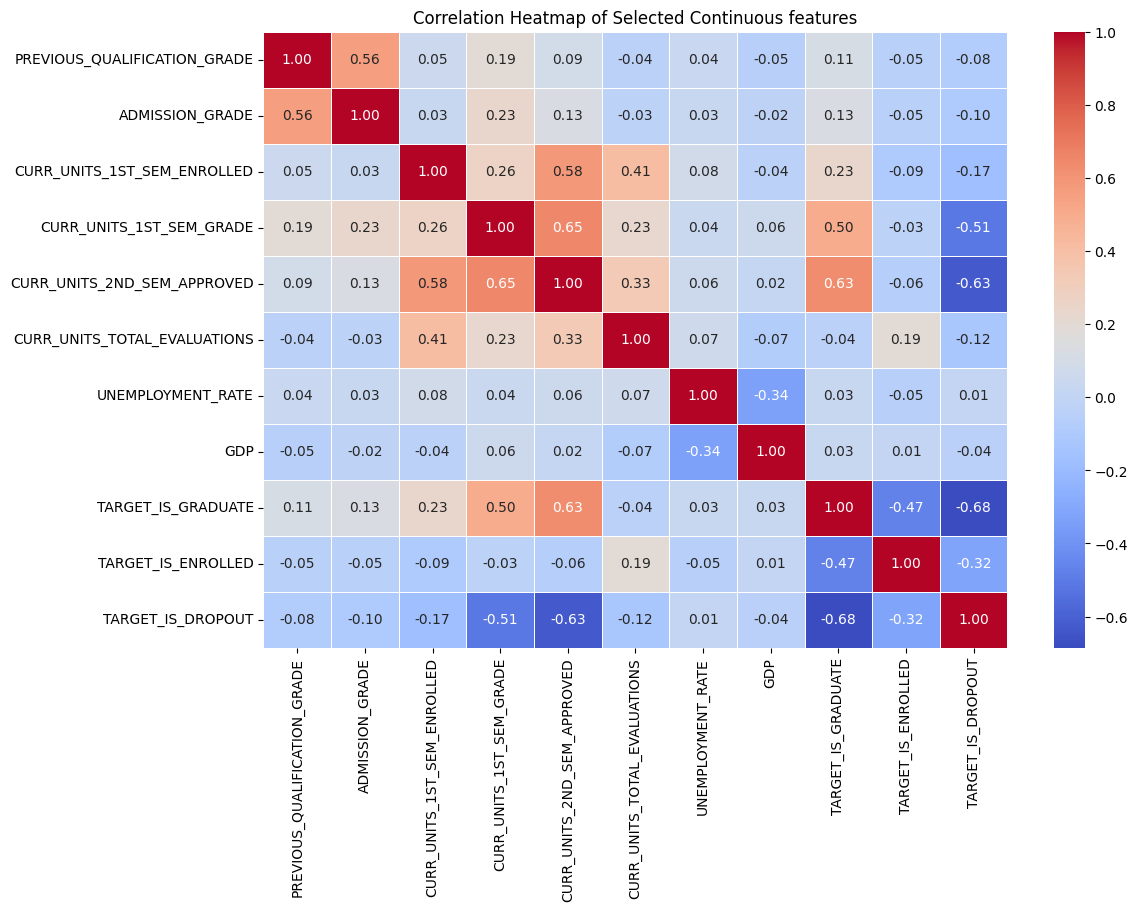

In [66]:
columns_to_correlate = selected_continuous_columns + [
    'TARGET_IS_GRADUATE', 
    'TARGET_IS_ENROLLED', 
    'TARGET_IS_DROPOUT',
]

fig_corr_heatmap_selected_features = plot_a_correlation_heatmap(data, columns_to_correlate, "Correlation Heatmap of Selected Continuous features")

Validated for Multicollinearity, none of the chosen columns have more than 70% correlation

## 5) Machine Learning

#### Define functions to prepare for and run Machine Learning Models


In [67]:
def add_results_to_report(res_list, res_dict, title, avg_accuracy, avg_precision, avg_recall, avg_fscore):
    #print ("Finished: ", title)
    res_list += [title]
    res_dict["Accuracy"].append(round(avg_accuracy,3))
    res_dict["Precision"].append(round(avg_precision,3))
    res_dict["Recall"].append(round(avg_recall,3))
    res_dict["F1-score"].append(round(avg_fscore,3))

In [68]:
def preprocess_data_for_classifier(X_train_data, X_test_data, continuous_col_names, categorical_col_names, scaler=None):
    X_train_cont = X_train_data[continuous_col_names]
    X_train_cat = X_train_data[categorical_col_names]
    X_test_cont = X_test_data[continuous_col_names]
    X_test_cat = X_test_data[categorical_col_names]

    ### Preprocessing continuous columns
    # There are no NaN values in the data so no need to use an Imputer

    # a scaler won't be required for tree based classifiers, but if a scaler is provided, apply it
    if scaler:  
        # scale both training and test data
        X_train_cont_scaled = scaler.fit_transform(X_train_cont)
        X_test_cont_scaled = scaler.transform(X_test_cont)
    else:  # skip the scaling step
        X_train_cont_scaled = X_train_cont
        X_test_cont_scaled = X_test_cont

    ### Preprocessing categorical columns
    # There are no NaN values in the data so no need to use an Imputer
    # Transform categorical columns using OneHotEncoder
    encoder_cat = OneHotEncoder(handle_unknown='ignore')
    X_train_cat_encoded = encoder_cat.fit_transform(X_train_cat)
    
    # Apply the same transformation to the test data
    X_test_cat_encoded = encoder_cat.transform(X_test_cat)

    ### Combine continuous and categorical preprocessed columns
    X_train_preprocessed = sparse.hstack((X_train_cont_scaled, X_train_cat_encoded))
    X_test_preprocessed = sparse.hstack((X_test_cont_scaled, X_test_cat_encoded))

    feature_names = continuous_col_names + list(encoder_cat.get_feature_names_out(categorical_col_names))

    return (X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names)

##### Dummy Classifier

In [69]:
def run_dummy_classifier(X_train_data, X_test_data, y_train_data, y_test_data):
    # use a Dummy classifier to predict the most frequent class to get a baseline
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(X_train_data, y_train_data)
    y_pred = dummy_clf.predict(X_test_data)

    #test_acc = accuracy_score(y_test_data, y_pred)
    #test_balanced_acc = balanced_accuracy_score(y_test_data, y_pred)
    accuracy = accuracy_score(y_test_data, y_pred)
    precision, recall, fscore, _ = score(y_test_data, y_pred, average='macro', zero_division=0.0)
    return (accuracy, precision, recall, fscore)

##### Logistic Regression

In [70]:
def run_logistic_regression(X_train_data, y_train_data, continuous_col_names, categorical_col_names, sampler=None):

    # Use Stratified K-Fold cross-validation to use a portion of the training data for validation
    # ('stratified' makes sure there are the same original proportions of classes in each fold)
    skf = StratifiedKFold(n_splits=5) # use 5 splits as it's a good balance between performance and variance

    # Initialise lists to store the results for each fold
    accuracy_scores_for_fold = []
    precision_scores_for_fold = []
    recall_scores_for_fold = []
    fscore_scores_for_fold = []

    for train_index, test_index in skf.split(X_train_data, y_train_data):
        ### Splitting the training data into training and test sets for this fold
        X_train_for_fold, X_test_for_fold = X_train_data.iloc[train_index], X_train_data.iloc[test_index]
        y_train_for_fold, y_test_for_fold = y_train_data.iloc[train_index], y_train_data.iloc[test_index]
    
        # Logistic regression requires the continuous columns to be scaled
        # Note: have tested RobustScaler and MinMaxScaler, but StandardScaler gives slightly better F1 scores
        scaler = StandardScaler()

        # Pre-process the data
        X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names = preprocess_data_for_classifier(X_train_for_fold, X_test_for_fold, continuous_col_names, categorical_col_names, scaler)

        if sampler:  # If a sampler is provided, apply it
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train_for_fold)
        else:  # skip the resampling step
            X_train_resampled, y_train_resampled = X_train_preprocessed, y_train_for_fold

        ### Fit Logistic Regression model
        lr_clf = LogisticRegression(random_state=1, max_iter=500)
        lr_clf.fit(X_train_resampled, y_train_resampled)

        ### Predict and evaluate on the test set for the fold
        y_pred_for_fold = lr_clf.predict(X_test_preprocessed)
        accuracy_scores_for_fold.append(accuracy_score(y_test_for_fold, y_pred_for_fold))
        precision, recall, fscore, _ = score(y_test_for_fold, y_pred_for_fold, average='macro', zero_division=0.0)
        precision_scores_for_fold.append(precision)
        recall_scores_for_fold.append(recall)
        fscore_scores_for_fold.append(fscore)

    # Calculating average scores across all folds
    avg_accuracy = np.mean(accuracy_scores_for_fold)
    avg_precision = np.mean(precision_scores_for_fold)
    avg_recall = np.mean(recall_scores_for_fold)
    avg_fscore = np.mean(fscore_scores_for_fold)
    
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [71]:
def run_logistic_regression_with_under_sampling(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    under_sampler = RandomUnderSampler(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_logistic_regression(X_train_data, y_train_data, continuous_col_names, categorical_col_names, under_sampler)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [72]:
def run_logistic_regression_with_over_sampling(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    over_sampler = RandomOverSampler(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_logistic_regression(X_train_data, y_train_data, continuous_col_names, categorical_col_names, over_sampler)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [73]:
def run_logistic_regression_with_SMOTE(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    smote = SMOTE(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_logistic_regression(X_train_data, y_train_data, continuous_col_names, categorical_col_names, smote)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [74]:
def run_logistic_regression_with_ADASYN(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    adasyn = ADASYN(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_logistic_regression(X_train_data, y_train_data, continuous_col_names, categorical_col_names, adasyn)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

##### Random Forest

In [75]:
def run_random_forest(X_train_data, y_train_data, continuous_col_names, categorical_col_names, sampler=None):   

    # Use Stratified K-Fold cross-validation to use a portion of the training data for validation
    # ('stratified' makes sure there are the same original proportions of classes in each fold)
    skf = StratifiedKFold(n_splits=5) # use 5 splits as it's a good balance between performance and variance

    # Initialise lists to store the results for each fold
    accuracy_scores_for_fold = []
    precision_scores_for_fold = []
    recall_scores_for_fold = []
    fscore_scores_for_fold = []
    
    for train_index, test_index in skf.split(X_train_data, y_train_data):
        ### Splitting the training data into training and test sets for this fold
        X_train_for_fold, X_test_for_fold = X_train_data.iloc[train_index], X_train_data.iloc[test_index]
        y_train_for_fold, y_test_for_fold = y_train_data.iloc[train_index], y_train_data.iloc[test_index]
    
        # Pre-process the data - no need for a scaler
        X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names = preprocess_data_for_classifier(X_train_for_fold, X_test_for_fold, continuous_col_names, categorical_col_names)

        if sampler:  # If a sampler is provided, apply it
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train_for_fold)
        else:  # skip the resampling step
            X_train_resampled, y_train_resampled = X_train_preprocessed, y_train_for_fold

        ### Fit Random Forest model
        rf_clf = RandomForestClassifier(random_state=1, n_jobs=-1)
        rf_clf.fit(X_train_resampled, y_train_resampled)

        ### Predict and evaluate on the test set for the fold
        y_pred_for_fold = rf_clf.predict(X_test_preprocessed)
        accuracy_scores_for_fold.append(accuracy_score(y_test_for_fold, y_pred_for_fold))
        precision, recall, fscore, _ = score(y_test_for_fold, y_pred_for_fold, average='macro', zero_division=0.0)
        precision_scores_for_fold.append(precision)
        recall_scores_for_fold.append(recall)
        fscore_scores_for_fold.append(fscore)

    # Calculating average scores across all folds
    avg_accuracy = np.mean(accuracy_scores_for_fold)
    avg_precision = np.mean(precision_scores_for_fold)
    avg_recall = np.mean(recall_scores_for_fold)
    avg_fscore = np.mean(fscore_scores_for_fold)
    
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)


In [76]:
def run_random_forest_with_under_sampling(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    under_sampler = RandomUnderSampler(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_random_forest(X_train_data, y_train_data, continuous_col_names, categorical_col_names, under_sampler)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [77]:
def run_random_forest_with_over_sampling(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    over_sampler = RandomOverSampler(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_random_forest(X_train_data, y_train_data, continuous_col_names, categorical_col_names, over_sampler)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [78]:
def run_random_forest_with_SMOTE(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    smote = SMOTE(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore,  encoder_cat = run_random_forest(X_train_data, y_train_data, continuous_col_names, categorical_col_names, smote)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)


In [79]:
def run_random_forest_with_ADASYN(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    adasyn = ADASYN(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_random_forest(X_train_data, y_train_data, continuous_col_names, categorical_col_names, adasyn)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

##### Decision Tree

In [80]:
def run_decision_tree(X_train_data, y_train_data, continuous_col_names, categorical_col_names, sampler=None):   

    # Use Stratified K-Fold cross-validation to use a portion of the training data for validation
    # ('stratified' makes sure there are the same original proportions of classes in each fold)
    skf = StratifiedKFold(n_splits=5) # use 5 splits as it's a good balance between performance and variance

    # Initialise lists to store the results for each fold
    accuracy_scores_for_fold = []
    precision_scores_for_fold = []
    recall_scores_for_fold = []
    fscore_scores_for_fold = []
   
    for train_index, test_index in skf.split(X_train_data, y_train_data):
        ### Splitting the training data into training and test sets for this fold
        X_train_for_fold, X_test_for_fold = X_train_data.iloc[train_index], X_train_data.iloc[test_index]
        y_train_for_fold, y_test_for_fold = y_train_data.iloc[train_index], y_train_data.iloc[test_index]
    
        # Pre-process the data - no need for a scaler
        X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names = preprocess_data_for_classifier(X_train_for_fold, X_test_for_fold, continuous_col_names, categorical_col_names)

        if sampler:  # If a sampler is provided, apply it
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train_for_fold)
        else:  # skip the resampling step
            X_train_resampled, y_train_resampled = X_train_preprocessed, y_train_for_fold

        ### Fit Decision Tree model - use some reasonable parameters - they will hyper tuned at a later stage of the notebook 
        dt_clf = DecisionTreeClassifier(max_depth=4, criterion='entropy', random_state=1)
        dt_clf.fit(X_train_resampled, y_train_resampled)

        ### Predict and evaluate on the test set for the fold
        y_pred_for_fold = dt_clf.predict(X_test_preprocessed)
        accuracy_scores_for_fold.append(accuracy_score(y_test_for_fold, y_pred_for_fold))
        precision, recall, fscore, _ = score(y_test_for_fold, y_pred_for_fold, average='macro', zero_division=0.0)
        precision_scores_for_fold.append(precision)
        recall_scores_for_fold.append(recall)
        fscore_scores_for_fold.append(fscore)

    # Calculating average scores across all folds
    avg_accuracy = np.mean(accuracy_scores_for_fold)
    avg_precision = np.mean(precision_scores_for_fold)
    avg_recall = np.mean(recall_scores_for_fold)
    avg_fscore = np.mean(fscore_scores_for_fold)
    
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [81]:
def run_decision_tree_with_under_sampling(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    under_sampler = RandomUnderSampler(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_decision_tree(X_train_data, y_train_data, continuous_col_names, categorical_col_names, under_sampler)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [82]:

def run_decision_tree_with_over_sampling(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    over_sampler = RandomOverSampler(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_decision_tree(X_train_data, y_train_data, continuous_col_names, categorical_col_names, over_sampler)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [83]:

def run_decision_tree_with_SMOTE(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    smote = SMOTE(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_decision_tree(X_train_data, y_train_data, continuous_col_names, categorical_col_names, smote)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [84]:

def run_decision_tree_with_ADASYN(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    adasyn = ADASYN(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_decision_tree(X_train_data, y_train_data, continuous_col_names, categorical_col_names, adasyn)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

##### Gradient Boosting

In [85]:
def run_gradient_boosting(X_train_data, y_train_data, continuous_col_names, categorical_col_names, sampler=None):   

    # Use Stratified K-Fold cross-validation to use a portion of the training data for validation
    # ('stratified' makes sure there are the same original proportions of classes in each fold)
    skf = StratifiedKFold(n_splits=5) # use 5 splits as it's a good balance between performance and variance

    # Initialise lists to store the results for each fold
    accuracy_scores_for_fold = []
    precision_scores_for_fold = []
    recall_scores_for_fold = []
    fscore_scores_for_fold = []
    
    for train_index, test_index in skf.split(X_train_data, y_train_data):
        ### Splitting the training data into training and test sets for this fold
        X_train_for_fold, X_test_for_fold = X_train_data.iloc[train_index], X_train_data.iloc[test_index]
        y_train_for_fold, y_test_for_fold = y_train_data.iloc[train_index], y_train_data.iloc[test_index]
    
        # Pre-process the data - no need for a scaler
        X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names = preprocess_data_for_classifier(X_train_for_fold, X_test_for_fold, continuous_col_names, categorical_col_names)

        if sampler:  # If a sampler is provided, apply it
            X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train_for_fold)
        else:  # skip the resampling step
            X_train_resampled, y_train_resampled = X_train_preprocessed, y_train_for_fold

        ### Fit Gradient Boosting model
        gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=4, min_samples_leaf=2, random_state=1)
        gb_clf.fit(X_train_resampled, y_train_resampled)

        ### Predict and evaluate on the test set for the fold
        y_pred_for_fold = gb_clf.predict(X_test_preprocessed)
        accuracy_scores_for_fold.append(accuracy_score(y_test_for_fold, y_pred_for_fold))
        precision, recall, fscore, _ = score(y_test_for_fold, y_pred_for_fold, average='macro', zero_division=0.0)
        precision_scores_for_fold.append(precision)
        recall_scores_for_fold.append(recall)
        fscore_scores_for_fold.append(fscore)

    # Calculating average scores across all folds
    avg_accuracy = np.mean(accuracy_scores_for_fold)
    avg_precision = np.mean(precision_scores_for_fold)
    avg_recall = np.mean(recall_scores_for_fold)
    avg_fscore = np.mean(fscore_scores_for_fold)
    
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)


In [86]:
def run_gradient_boosting_with_under_sampling(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    under_sampler = RandomUnderSampler(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_gradient_boosting(X_train_data, y_train_data, continuous_col_names, categorical_col_names, under_sampler)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [87]:
def run_gradient_boosting_with_over_sampling(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    over_sampler = RandomOverSampler(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_gradient_boosting(X_train_data, y_train_data, continuous_col_names, categorical_col_names, over_sampler)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

In [88]:
def run_gradient_boosting_with_SMOTE(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    smote = SMOTE(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_gradient_boosting(X_train_data, y_train_data, continuous_col_names, categorical_col_names, smote)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)    

In [89]:
def run_gradient_boosting_with_ADASYN(X_train_data, y_train_data, continuous_col_names, categorical_col_names):

    adasyn = ADASYN(random_state=1)
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_gradient_boosting(X_train_data, y_train_data, continuous_col_names, categorical_col_names, adasyn)
    return (avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat)

#### Define function to create the 70:30 split of data for training and testing

In [90]:
def split_train_test_data(data, target_columns, display_distribution=False):
    # move the target columns from X to Y datasets
    X = data.drop(columns = target_columns)
    Y = data[target_columns]

    # Split the data into training & testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 1, stratify = Y)

    if (display_distribution):
        print ("Training data percentage distribution")
        print (y_train.value_counts(normalize=True) * 100)

        print ("Test data percentage distribution")
        print (y_test.value_counts(normalize=True) * 100)

    return (X, Y, X_train, X_test, y_train, y_test)

#### Define function to prepare the chosen target feature

In [91]:
# extracts the chosen target column from the y target data
def prepare_train_test_data_for_target(y_train, y_test, target):
    y_train_processed = y_train[target]
    y_test_processed = y_test[target]

    return (y_train_processed, y_test_processed)

#### Define function to run each machine learning model in turn on the supplied data and features

In [92]:
def run_all_ML_for_features( X_train, X_test, y_train, y_test, continuous_columns_for_ML, categorical_columns_for_ML, use_ADASYN):
                            
    # Initialise dictionary and list to store the experiment results
    results_list = []
    results_dict = {"Accuracy": [], "Precision": [], "Recall": [], "F1-score": [],}
    ########### Run Dummy Classifier ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore = run_dummy_classifier(X_train, X_test, y_train, y_test)
    add_results_to_report(results_list, results_dict, "Dummy classifier", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run Logistic Regression ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_logistic_regression(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Logistic regression", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run under-sampling with Logistic Regression ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_logistic_regression_with_under_sampling(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Logistic regression (Random Under-sampling)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run over-sampling with Logistic regression ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_logistic_regression_with_over_sampling(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Logistic regression (Random Over-sampling)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run SMOTE with Logistic regression ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_logistic_regression_with_SMOTE(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Logistic regression (SMOTE)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run ADASYN with Logistic regression ############
    # Note: ADASYN can't be used if the data is already well balanced (gives an error) so added the ability to skip it
    if (use_ADASYN):
        avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_logistic_regression_with_ADASYN(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
        add_results_to_report(results_list, results_dict, "Logistic regression (ADASYN)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run Random Forest ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_random_forest(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Random forest", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run under-sampling with Random Forest ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_random_forest_with_under_sampling(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Random forest (Random Under-sampling)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run over-sampling with Random Forest ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_random_forest_with_over_sampling(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Random Forest (Random Over-sampling)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run SMOTE with Random Forest ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_random_forest_with_SMOTE(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Random Forest (SMOTE)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run ADASYN with Random Forest ############
    if (use_ADASYN):
    # Note: ADASYN can't be used if the data is already well balanced (gives an error) so added the ability to skip it
        avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_random_forest_with_ADASYN(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
        add_results_to_report(results_list, results_dict, "Random Forest (ADASYN)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run Decision Tree ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_decision_tree(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Decision Tree", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run under-sampling with Decision Tree ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_decision_tree_with_under_sampling(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Decision Tree (Random Under-sampling)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run over-sampling with Decision Tree ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_decision_tree_with_over_sampling(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Decision Tree (Random Over-sampling)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run SMOTE with Decision Tree ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_decision_tree_with_SMOTE(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Decision Tree (SMOTE)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run ADASYN with Decision Tree ############
    if (use_ADASYN):
    # Note: ADASYN can't be used if the data is already well balanced (gives an error) so added the ability to skip it
        avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_decision_tree_with_ADASYN(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
        add_results_to_report(results_list, results_dict, "Decision Tree (ADASYN)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run Gradient Boosting ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_gradient_boosting(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Gradient Boosting", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run under-sampling with Gradient Boosting ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_gradient_boosting_with_under_sampling(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Gradient Boosting (Random Under-sampling)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run over-sampling with Gradient Boosting ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_gradient_boosting_with_over_sampling(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Gradient Boosting (Random Over-sampling)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run SMOTE with Gradient Boosting ############
    avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_gradient_boosting_with_SMOTE(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
    add_results_to_report(results_list, results_dict, "Gradient Boosting (SMOTE)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    ########### Run ADASYN with Gradient Boosting ############
    if (use_ADASYN):
    # Note: ADASYN can't be used if the data is already well balanced (gives an error) so added the ability to skip it
        avg_accuracy, avg_precision, avg_recall, avg_fscore, encoder_cat = run_gradient_boosting_with_ADASYN(X_train, y_train, continuous_columns_for_ML, categorical_columns_for_ML)
        add_results_to_report(results_list, results_dict, "Gradient Boosting (ADASYN)", avg_accuracy, avg_precision, avg_recall, avg_fscore)

    # display report
    df = pd.DataFrame(results_dict, results_list)
    return(df)

#### Create training and test data 
- Split the data into training (70%) and test (30%) sets
- For initial investigation into ML classifiers, only the training data will be used with Cross Validation methods to extract validation data
- using 'stratify' to ensure the same target distribution applies to both the training and test datasets

In [93]:
target_columns = ['TARGET', 'TARGET_IS_DROPOUT', 'TARGET_IS_ENROLLED', 'TARGET_IS_GRADUATE']
X, Y, X_train, X_test, y_train_all_targets, y_test_all_targets = split_train_test_data(data, target_columns, True)

Training data percentage distribution
TARGET    TARGET_IS_DROPOUT  TARGET_IS_ENROLLED  TARGET_IS_GRADUATE
Graduate  0                  0                   1                     50.269360
Dropout   1                  0                   0                     31.683502
Enrolled  0                  1                   0                     18.047138
Name: proportion, dtype: float64
Test data percentage distribution
TARGET    TARGET_IS_DROPOUT  TARGET_IS_ENROLLED  TARGET_IS_GRADUATE
Graduate  0                  0                   1                     50.313972
Dropout   1                  0                   0                     31.632653
Enrolled  0                  1                   0                     18.053375
Name: proportion, dtype: float64


#### Run Machine Learning on Baseline features for TARGET (to compare against RQ1)

In [94]:
# Run Machine Learning on baseline features for TARGET
y_train, y_test = prepare_train_test_data_for_target(y_train_all_targets, y_test_all_targets, 'TARGET')

df_baseline_results_Target = run_all_ML_for_features(X_train, X_test, y_train, y_test, baseline_continuous_columns, baseline_categorical_columns, True)
print ("\nBaseline - (no first year academic features) targeting three classes (Graduate, Enrolled, Dropout)")
df_baseline_results_Target


Baseline - (no first year academic features) targeting three classes (Graduate, Enrolled, Dropout)


Accuracy  Precision  Recall  \
Dummy classifier                                0.503      0.168   0.333   
Logistic regression                             0.651      0.578   0.536   
Logistic regression (Random Under-sampling)     0.595      0.579   0.579   
Logistic regression (Random Over-sampling)      0.605      0.580   0.580   
Logistic regression (SMOTE)                     0.600      0.575   0.574   
Logistic regression (ADASYN)                    0.603      0.569   0.571   
Random forest                                   0.646      0.584   0.547   
Random forest (Random Under-sampling)           0.585      0.577   0.581   
Random Forest (Random Over-sampling)            0.636      0.569   0.558   
Random Forest (SMOTE)                           0.642      0.575   0.549   
Random Forest (ADASYN)                          0.640      0.574   0.551   
Decision Tree                                   0.625      0.504   0.490   
Decision Tree (Random Under-sampling)           0.500      0.543   0.513   
Decision Tree (Random Over-sampling)            0.475      0.575   0.507   
Decision Tree (SMOTE)                           0.555      0.589   0.477   
Decision Tree (ADASYN)                          0.522      0.596   0.481   
Gradient Boosting                               0.649      0.575   0.542   
Gradient Boosting (Random Under-sampling)       0.584      0.576   0.577   
Gradient Boosting (Random Over-sampling)        0.620      0.579   0.579   
Gradient Boosting (SMOTE)                       0.647      0.579   0.558   
Gradient Boosting (ADASYN)                      0.647      0.574   0.556   

                                             F1-score  
Dummy classifier                                0.223  
Logistic regression                             0.531  
Logistic regression (Random Under-sampling)     0.565  
Logistic regression (Random Over-sampling)      0.570  
Logistic regression (SMOTE)                     0.565  
Logistic regression (ADASYN)                    0.564  
Random forest                                   0.550  
Random forest (Random Under-sampling)           0.563  
Random Forest (Random Over-sampling)            0.560  
Random Forest (SMOTE)                           0.553  
Random Forest (ADASYN)                          0.554  
Decision Tree                                   0.454  
Decision Tree (Random Under-sampling)           0.486  
Decision Tree (Random Over-sampling)            0.467  
Decision Tree (SMOTE)                           0.463  
Decision Tree (ADASYN)                          0.464  
Gradient Boosting                               0.542  
Gradient Boosting (Random Under-sampling)       0.559  
Gradient Boosting (Random Over-sampling)        0.575  
Gradient Boosting (SMOTE)                       0.562  
Gradient Boosting (ADASYN)                      0.558

#### Run Machine Learning for RQ1 using selected features predicting TARGET

In [95]:
# Run Machine Learning for TARGET
y_train, y_test = prepare_train_test_data_for_target(y_train_all_targets, y_test_all_targets, 'TARGET')

df_results_Target = run_all_ML_for_features(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, True)
print ("\nRQ1 - Targeting: All three categories (Graduate, Enrolled, Dropout)")
df_results_Target



RQ1 - Targeting: All three categories (Graduate, Enrolled, Dropout)


Accuracy  Precision  Recall  \
Dummy classifier                                0.503      0.168   0.333   
Logistic regression                             0.771      0.710   0.677   
Logistic regression (Random Under-sampling)     0.740      0.706   0.712   
Logistic regression (Random Over-sampling)      0.746      0.710   0.712   
Logistic regression (SMOTE)                     0.753      0.716   0.720   
Logistic regression (ADASYN)                    0.745      0.703   0.710   
Random forest                                   0.770      0.717   0.676   
Random forest (Random Under-sampling)           0.744      0.720   0.722   
Random Forest (Random Over-sampling)            0.774      0.725   0.701   
Random Forest (SMOTE)                           0.776      0.729   0.697   
Random Forest (ADASYN)                          0.775      0.724   0.699   
Decision Tree                                   0.753      0.716   0.643   
Decision Tree (Random Under-sampling)           0.707      0.691   0.682   
Decision Tree (Random Over-sampling)            0.721      0.711   0.696   
Decision Tree (SMOTE)                           0.723      0.701   0.685   
Decision Tree (ADASYN)                          0.721      0.704   0.677   
Gradient Boosting                               0.776      0.725   0.696   
Gradient Boosting (Random Under-sampling)       0.737      0.711   0.715   
Gradient Boosting (Random Over-sampling)        0.766      0.725   0.721   
Gradient Boosting (SMOTE)                       0.781      0.734   0.711   
Gradient Boosting (ADASYN)                      0.780      0.730   0.709   

                                             F1-score  
Dummy classifier                                0.223  
Logistic regression                             0.683  
Logistic regression (Random Under-sampling)     0.701  
Logistic regression (Random Over-sampling)      0.704  
Logistic regression (SMOTE)                     0.712  
Logistic regression (ADASYN)                    0.702  
Random forest                                   0.685  
Random forest (Random Under-sampling)           0.710  
Random Forest (Random Over-sampling)            0.710  
Random Forest (SMOTE)                           0.708  
Random Forest (ADASYN)                          0.708  
Decision Tree                                   0.644  
Decision Tree (Random Under-sampling)           0.673  
Decision Tree (Random Over-sampling)            0.686  
Decision Tree (SMOTE)                           0.682  
Decision Tree (ADASYN)                          0.673  
Gradient Boosting                               0.706  
Gradient Boosting (Random Under-sampling)       0.702  
Gradient Boosting (Random Over-sampling)        0.719  
Gradient Boosting (SMOTE)                       0.719  
Gradient Boosting (ADASYN)                      0.717

#### Run Machine Learning for RQ2 using selected features predicting TARGET_IS_GRADUATE

In [96]:

# Run Machine Learning for TARGET_IS_GRADUATE
y_train, y_test = prepare_train_test_data_for_target(y_train_all_targets, y_test_all_targets, 'TARGET_IS_GRADUATE')

df_results_Target_Is_Graduate = run_all_ML_for_features(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, False)
print ("\nRQ2 - Targeting: Is Graduate")
df_results_Target_Is_Graduate


RQ2 - Targeting: Is Graduate


Accuracy  Precision  Recall  \
Dummy classifier                                0.503      0.252   0.500   
Logistic regression                             0.856      0.858   0.856   
Logistic regression (Random Under-sampling)     0.856      0.858   0.855   
Logistic regression (Random Over-sampling)      0.856      0.858   0.855   
Logistic regression (SMOTE)                     0.857      0.859   0.856   
Random forest                                   0.852      0.854   0.852   
Random forest (Random Under-sampling)           0.854      0.856   0.854   
Random Forest (Random Over-sampling)            0.853      0.854   0.852   
Random Forest (SMOTE)                           0.857      0.859   0.857   
Decision Tree                                   0.834      0.841   0.833   
Decision Tree (Random Under-sampling)           0.833      0.841   0.833   
Decision Tree (Random Over-sampling)            0.834      0.841   0.833   
Decision Tree (SMOTE)                           0.835      0.842   0.835   
Gradient Boosting                               0.857      0.860   0.857   
Gradient Boosting (Random Under-sampling)       0.859      0.861   0.858   
Gradient Boosting (Random Over-sampling)        0.855      0.857   0.854   
Gradient Boosting (SMOTE)                       0.859      0.862   0.859   

                                             F1-score  
Dummy classifier                                0.335  
Logistic regression                             0.856  
Logistic regression (Random Under-sampling)     0.855  
Logistic regression (Random Over-sampling)      0.855  
Logistic regression (SMOTE)                     0.856  
Random forest                                   0.852  
Random forest (Random Under-sampling)           0.854  
Random Forest (Random Over-sampling)            0.852  
Random Forest (SMOTE)                           0.857  
Decision Tree                                   0.833  
Decision Tree (Random Under-sampling)           0.832  
Decision Tree (Random Over-sampling)            0.833  
Decision Tree (SMOTE)                           0.834  
Gradient Boosting                               0.857  
Gradient Boosting (Random Under-sampling)       0.858  
Gradient Boosting (Random Over-sampling)        0.854  
Gradient Boosting (SMOTE)                       0.859

#### Run Machine Learning for RQ2 using selected features predicting TARGET_IS_ENROLLED

In [97]:
# Run Machine Learning for TARGET_IS_ENROLLED
y_train, y_test = prepare_train_test_data_for_target(y_train_all_targets, y_test_all_targets, 'TARGET_IS_ENROLLED')

df_results_Target_Is_Enrolled = run_all_ML_for_features(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, True)
print ("\nRQ2 - Targeting: Is Enrolled")
df_results_Target_Is_Enrolled


RQ2 - Targeting: Is Enrolled


Accuracy  Precision  Recall  \
Dummy classifier                                0.819      0.410   0.500   
Logistic regression                             0.814      0.648   0.553   
Logistic regression (Random Under-sampling)     0.704      0.630   0.705   
Logistic regression (Random Over-sampling)      0.719      0.635   0.708   
Logistic regression (SMOTE)                     0.714      0.631   0.701   
Logistic regression (ADASYN)                    0.718      0.634   0.706   
Random forest                                   0.827      0.701   0.563   
Random forest (Random Under-sampling)           0.733      0.655   0.740   
Random Forest (Random Over-sampling)            0.827      0.699   0.635   
Random Forest (SMOTE)                           0.832      0.718   0.609   
Random Forest (ADASYN)                          0.829      0.708   0.604   
Decision Tree                                   0.820      0.410   0.500   
Decision Tree (Random Under-sampling)           0.678      0.624   0.698   
Decision Tree (Random Over-sampling)            0.672      0.631   0.713   
Decision Tree (SMOTE)                           0.702      0.621   0.686   
Decision Tree (ADASYN)                          0.703      0.627   0.693   
Gradient Boosting                               0.820      0.678   0.596   
Gradient Boosting (Random Under-sampling)       0.732      0.656   0.742   
Gradient Boosting (Random Over-sampling)        0.786      0.679   0.741   
Gradient Boosting (SMOTE)                       0.827      0.702   0.651   
Gradient Boosting (ADASYN)                      0.830      0.708   0.657   

                                             F1-score  
Dummy classifier                                0.450  
Logistic regression                             0.556  
Logistic regression (Random Under-sampling)     0.629  
Logistic regression (Random Over-sampling)      0.639  
Logistic regression (SMOTE)                     0.634  
Logistic regression (ADASYN)                    0.638  
Random forest                                   0.568  
Random forest (Random Under-sampling)           0.661  
Random Forest (Random Over-sampling)            0.655  
Random Forest (SMOTE)                           0.631  
Random Forest (ADASYN)                          0.624  
Decision Tree                                   0.450  
Decision Tree (Random Under-sampling)           0.611  
Decision Tree (Random Over-sampling)            0.613  
Decision Tree (SMOTE)                           0.620  
Decision Tree (ADASYN)                          0.623  
Gradient Boosting                               0.613  
Gradient Boosting (Random Under-sampling)       0.660  
Gradient Boosting (Random Over-sampling)        0.696  
Gradient Boosting (SMOTE)                       0.668  
Gradient Boosting (ADASYN)                      0.674

#### Run Machine Learning for RQ2 using selected features predicting TARGET_IS_DROPOUT

In [98]:
# Run Machine Learning for TARGET_IS_DROPOUT
y_train, y_test = prepare_train_test_data_for_target(y_train_all_targets, y_test_all_targets, 'TARGET_IS_DROPOUT')

df_results_Target_Is_Dropout = run_all_ML_for_features(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, True)
print ("\nRQ2 - Targeting: Is Dropout")
df_results_Target_Is_Dropout


RQ2 - Targeting: Is Dropout


Accuracy  Precision  Recall  \
Dummy classifier                                0.684      0.342   0.500   
Logistic regression                             0.881      0.875   0.844   
Logistic regression (Random Under-sampling)     0.866      0.843   0.854   
Logistic regression (Random Over-sampling)      0.866      0.843   0.854   
Logistic regression (SMOTE)                     0.864      0.841   0.853   
Logistic regression (ADASYN)                    0.847      0.822   0.850   
Random forest                                   0.879      0.875   0.839   
Random forest (Random Under-sampling)           0.864      0.841   0.851   
Random Forest (Random Over-sampling)            0.874      0.861   0.843   
Random Forest (SMOTE)                           0.876      0.866   0.841   
Random Forest (ADASYN)                          0.877      0.867   0.843   
Decision Tree                                   0.868      0.864   0.826   
Decision Tree (Random Under-sampling)           0.860      0.837   0.848   
Decision Tree (Random Over-sampling)            0.867      0.851   0.839   
Decision Tree (SMOTE)                           0.862      0.846   0.836   
Decision Tree (ADASYN)                          0.855      0.832   0.835   
Gradient Boosting                               0.880      0.874   0.844   
Gradient Boosting (Random Under-sampling)       0.863      0.840   0.849   
Gradient Boosting (Random Over-sampling)        0.873      0.856   0.850   
Gradient Boosting (SMOTE)                       0.882      0.874   0.847   
Gradient Boosting (ADASYN)                      0.878      0.868   0.845   

                                             F1-score  
Dummy classifier                                0.406  
Logistic regression                             0.857  
Logistic regression (Random Under-sampling)     0.848  
Logistic regression (Random Over-sampling)      0.848  
Logistic regression (SMOTE)                     0.846  
Logistic regression (ADASYN)                    0.832  
Random forest                                   0.853  
Random forest (Random Under-sampling)           0.846  
Random Forest (Random Over-sampling)            0.850  
Random Forest (SMOTE)                           0.851  
Random Forest (ADASYN)                          0.853  
Decision Tree                                   0.839  
Decision Tree (Random Under-sampling)           0.841  
Decision Tree (Random Over-sampling)            0.843  
Decision Tree (SMOTE)                           0.838  
Decision Tree (ADASYN)                          0.833  
Gradient Boosting                               0.856  
Gradient Boosting (Random Under-sampling)       0.844  
Gradient Boosting (Random Over-sampling)        0.852  
Gradient Boosting (SMOTE)                       0.858  
Gradient Boosting (ADASYN)                      0.855

#### Conclusion
For RQ1:
- The models that included the first-year academic data significantly outperformed the Baseline models
  (which excluded first-year academic data)
- The best versions of each model classifier were:
  - Logistic Regression with SMOTE
  - Decision tree with Random Over Sampler
  - Random Forest with Random Under Sampler
  - Gradient Boosting with SMOTE
- They will be taken forward to Hyperparameter Tuning

For RQ2:
- The binary models accuracy and F1-score when targeting Graduate or Dropout targets outperformed the three class classification of RQ1
- With regard to the Enrolled class, the accuracy of many models outperforms RQ1, but F1-score does not. This is not surprising considering the minority class of Enrolled is known to be hard to predict and the RQ1 results are an average for all three classes. A better comparision can be made after hyperparameter tuning when the full classification report will be displayed.


### Hyperparameter Tuning

#### Define functions to help with hyperparameter tuning, prediction and evaluation

##### Pre-process the data, applying a scaler and sampler if required and one-hot encoding the categorical features

In [99]:
def preprocess_for_hyperparam_tuning(X_train, X_test, y_train, continuous_col_names, categorical_col_names, sampler=None, scaler=None):
    X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names = preprocess_data_for_classifier(X_train, X_test, continuous_col_names, categorical_col_names, scaler)
    
    if sampler:
        X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train_preprocessed, y_train

    return (X_train_resampled, y_train_resampled, X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names)

##### Run a grid search using the specified classifier and parameters (using 5 fold cross-validation)

In [100]:
def run_grid_search(classifier, params, x_train, y_train):
    gs = GridSearchCV(classifier, params, cv = 5, scoring = 'f1_macro', n_jobs = -1, return_train_score=True) # also store training scores for later checks
    gs_fit = gs.fit(x_train, y_train)

    # Convert to a DataFrame for easy analysis
    gs_results = pd.DataFrame({
        'params': gs_fit.cv_results_['params'],
        'mean_train_score': gs_fit.cv_results_['mean_train_score'],  # Training score
        'mean_test_score': gs_fit.cv_results_['mean_test_score'],  # Validation score
        'score_difference': gs_fit.cv_results_['mean_train_score'] - gs_fit.cv_results_['mean_test_score']  # Difference to check for overfitting check
    })

    gs_results_best_test_score = gs_results.sort_values(by='mean_test_score',ascending=False)
    gs_results_worst_score_diff = gs_results.sort_values(by='score_difference',ascending=False)

    return (gs, gs_fit, gs_results_best_test_score, gs_results_worst_score_diff)

##### Plot the decision tree

In [101]:
def plot_decision_tree(dt_clf, feature_names, depth):
    # use plot_tree() to visualise the tree and interpret the result.
    fig = plt.figure(figsize = (30, 15))
    _ = plot_tree(dt_clf, 
                feature_names = feature_names,  
                class_names = dt_clf.classes_,
                filled = True,
                fontsize=6,
                max_depth=depth,  # limit the amount of the tree displayed
                impurity=False) # reduce clutter from display

    # use this to save as a png
    #fig.savefig("decision_tree.png", dpi=300, bbox_inches="tight")

    return (fig)

##### Predict using a classification report and a confusion matrix

In [102]:
def show_predictions(classifier, X_test, y_test):
    # Make predictions with test data
    y_pred = classifier.predict(X_test)
    # Create a classification report
    report = classification_report(y_test, y_pred)   
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    macro_avg_f1 = float(report_dict["macro avg"]["f1-score"])

    print(report)
    '''
    # convert report into a figure in case of need to save as image
    fig, ax = plt.subplots(figsize=(6, 2))  
    ax.text(0, 1, report, fontsize=10, family='monospace', verticalalignment='top')

    # Remove axes
    ax.axis('off')
    plt.show()'
    '''

    # Generate a confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot()
    plt.show()

    return (macro_avg_f1, cm_display.figure_)

##### Report feature importance

In [103]:
def report_feature_importances(best_classifier, feature_names):
    # Get feature importances from the best model
    feature_importances = best_classifier.feature_importances_

    # Convert to DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Display the top features
    print(feature_importance_df.head(20))  # Top 20 most important features

    # Plot feature importance
    fig = plt.figure(figsize=(10,6))
    plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='royalblue')
    plt.gca().invert_yaxis()  # Most important feature at the top
    plt.xlabel("Importance Score")
    plt.ylabel("Feature Name")
    plt.title("Top 20 Feature Importances")
    plt.show()

    return (fig)

##### Calculate differences between training and test results in an attempt to spot over-fitting

In [104]:
def show_difference_between_train_and_test(classifier, X_train_resampled, y_train_resampled, X_test_preprocessed, y_test):
    train_pred = classifier.predict(X_train_resampled)
    test_pred = classifier.predict(X_test_preprocessed)

    # Accuracy scores
    train_acc = accuracy_score(y_train_resampled, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    train_balanced_acc = balanced_accuracy_score(y_train_resampled, train_pred)
    test_balanced_acc = balanced_accuracy_score(y_test, test_pred)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Training Balanced Accuracy: {train_balanced_acc:.4f}")
    print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")

#### Hyperparameter Tune against TARGET (RQ1)

##### Prepare data for Hyperparameter Tuning against TARGET (RQ1)

In [105]:
y_train, y_test = prepare_train_test_data_for_target(y_train_all_targets, y_test_all_targets, 'TARGET')


##### Hyperparameter Tune Logistic Regression with SMOTE

In [106]:
def hpt_logistic_regression(X_train, X_test, y_train, y_test, continuous_col_names, categorical_col_names, sampler=None):
    params = { 
        "C": [0.01, 0.1, 1, 10, 100],  # Regularisation strength
        "penalty": ["l2"],        # regularisation type
        "solver": ["lbfgs", "liblinear", "saga"]  # solvers that support L1/L2
    }

    # initialise the model
    lr_clf = LogisticRegression(random_state=1, max_iter=1000)
    scaler = RobustScaler()
    X_train_resampled, y_train_resampled, X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names = preprocess_for_hyperparam_tuning(X_train, X_test, y_train, continuous_col_names, categorical_col_names, sampler, scaler)

    # Grid search
    gs_lr, gs_lr_fit, gs_lr_results, gs_lr_results_worst_score_diff = run_grid_search(lr_clf, params, X_train_resampled, y_train_resampled)

    print(f"Parameters used for best score: {gs_lr.best_params_}")
    print(f"Best test score during validation: {gs_lr_results.mean_test_score.values[0]}")
    print(f"Difference between training and validation scores: {gs_lr_results.score_difference.values[0]}")

    best_lr = gs_lr_fit.best_estimator_

    macro_avg_f1, cm_display  = show_predictions(best_lr, X_test_preprocessed, y_test)
 
    show_difference_between_train_and_test(best_lr, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
    return (cm_display)

Parameters used for best score: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best test score during validation: 0.7417053093463499
Difference between training and validation scores: 0.010555866049417273
              precision    recall  f1-score   support

     Dropout       0.83      0.69      0.75       403
    Enrolled       0.43      0.60      0.50       230
    Graduate       0.85      0.82      0.84       641

    accuracy                           0.74      1274
   macro avg       0.70      0.70      0.70      1274
weighted avg       0.77      0.74      0.75      1274



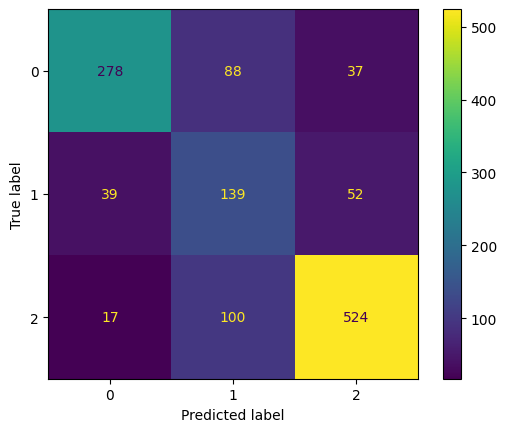

Training Accuracy: 0.7646
Test Accuracy: 0.7386
Training Balanced Accuracy: 0.7348
Test Balanced Accuracy: 0.7039


In [107]:
cm_display = hpt_logistic_regression(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, SMOTE(random_state=1))
save_figure(cm_display, "RQ1_HPT_LR_SMOTE_CM.png")

##### Hyperparameter Tune Decision tree with Random Over Sampler

In [108]:
def hpt_decision_tree(X_train, X_test, y_train, y_test, continuous_col_names, categorical_col_names, sampler=None):
    params = { 
        'max_depth': [3, 5, 7], # Tree depth
        'min_samples_split': [4, 5, 7], # Minimum samples to split a node
        'min_samples_leaf': [2, 3, 5, 7, 10], # Minimum samples per leaf
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced']
    }

    # initialise the model
    dt_clf = DecisionTreeClassifier(random_state=1)     
    X_train_resampled, y_train_resampled, X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names = preprocess_for_hyperparam_tuning(X_train, X_test, y_train, continuous_col_names, categorical_col_names, sampler)

    # Grid search
    gs_tree, gs_tree_fit, gs_tree_results, gs_tree_results_worst_score_diff = run_grid_search(dt_clf, params, X_train_resampled, y_train_resampled)

    print(f"Parameters used for best score: {gs_tree.best_params_}")
    print(f"Best test score during validation: {gs_tree_results.mean_test_score.values[0]}")
    print(f"Difference between training and validation scores: {gs_tree_results.score_difference.values[0]}")

    best_dt = gs_tree_fit.best_estimator_

    plot_decision_tree(best_dt, feature_names, 3)
    macro_avg_f1, cm_display = show_predictions(best_dt, X_test_preprocessed, y_test)
    fi_chart = report_feature_importances(best_dt, feature_names)

    show_difference_between_train_and_test(best_dt, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
    return (cm_display, fi_chart)

Parameters used for best score: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best test score during validation: 0.740857360062377
Difference between training and validation scores: 0.032365608357521114
              precision    recall  f1-score   support

     Dropout       0.85      0.61      0.71       403
    Enrolled       0.38      0.50      0.43       230
    Graduate       0.80      0.85      0.82       641

    accuracy                           0.71      1274
   macro avg       0.68      0.65      0.65      1274
weighted avg       0.74      0.71      0.71      1274



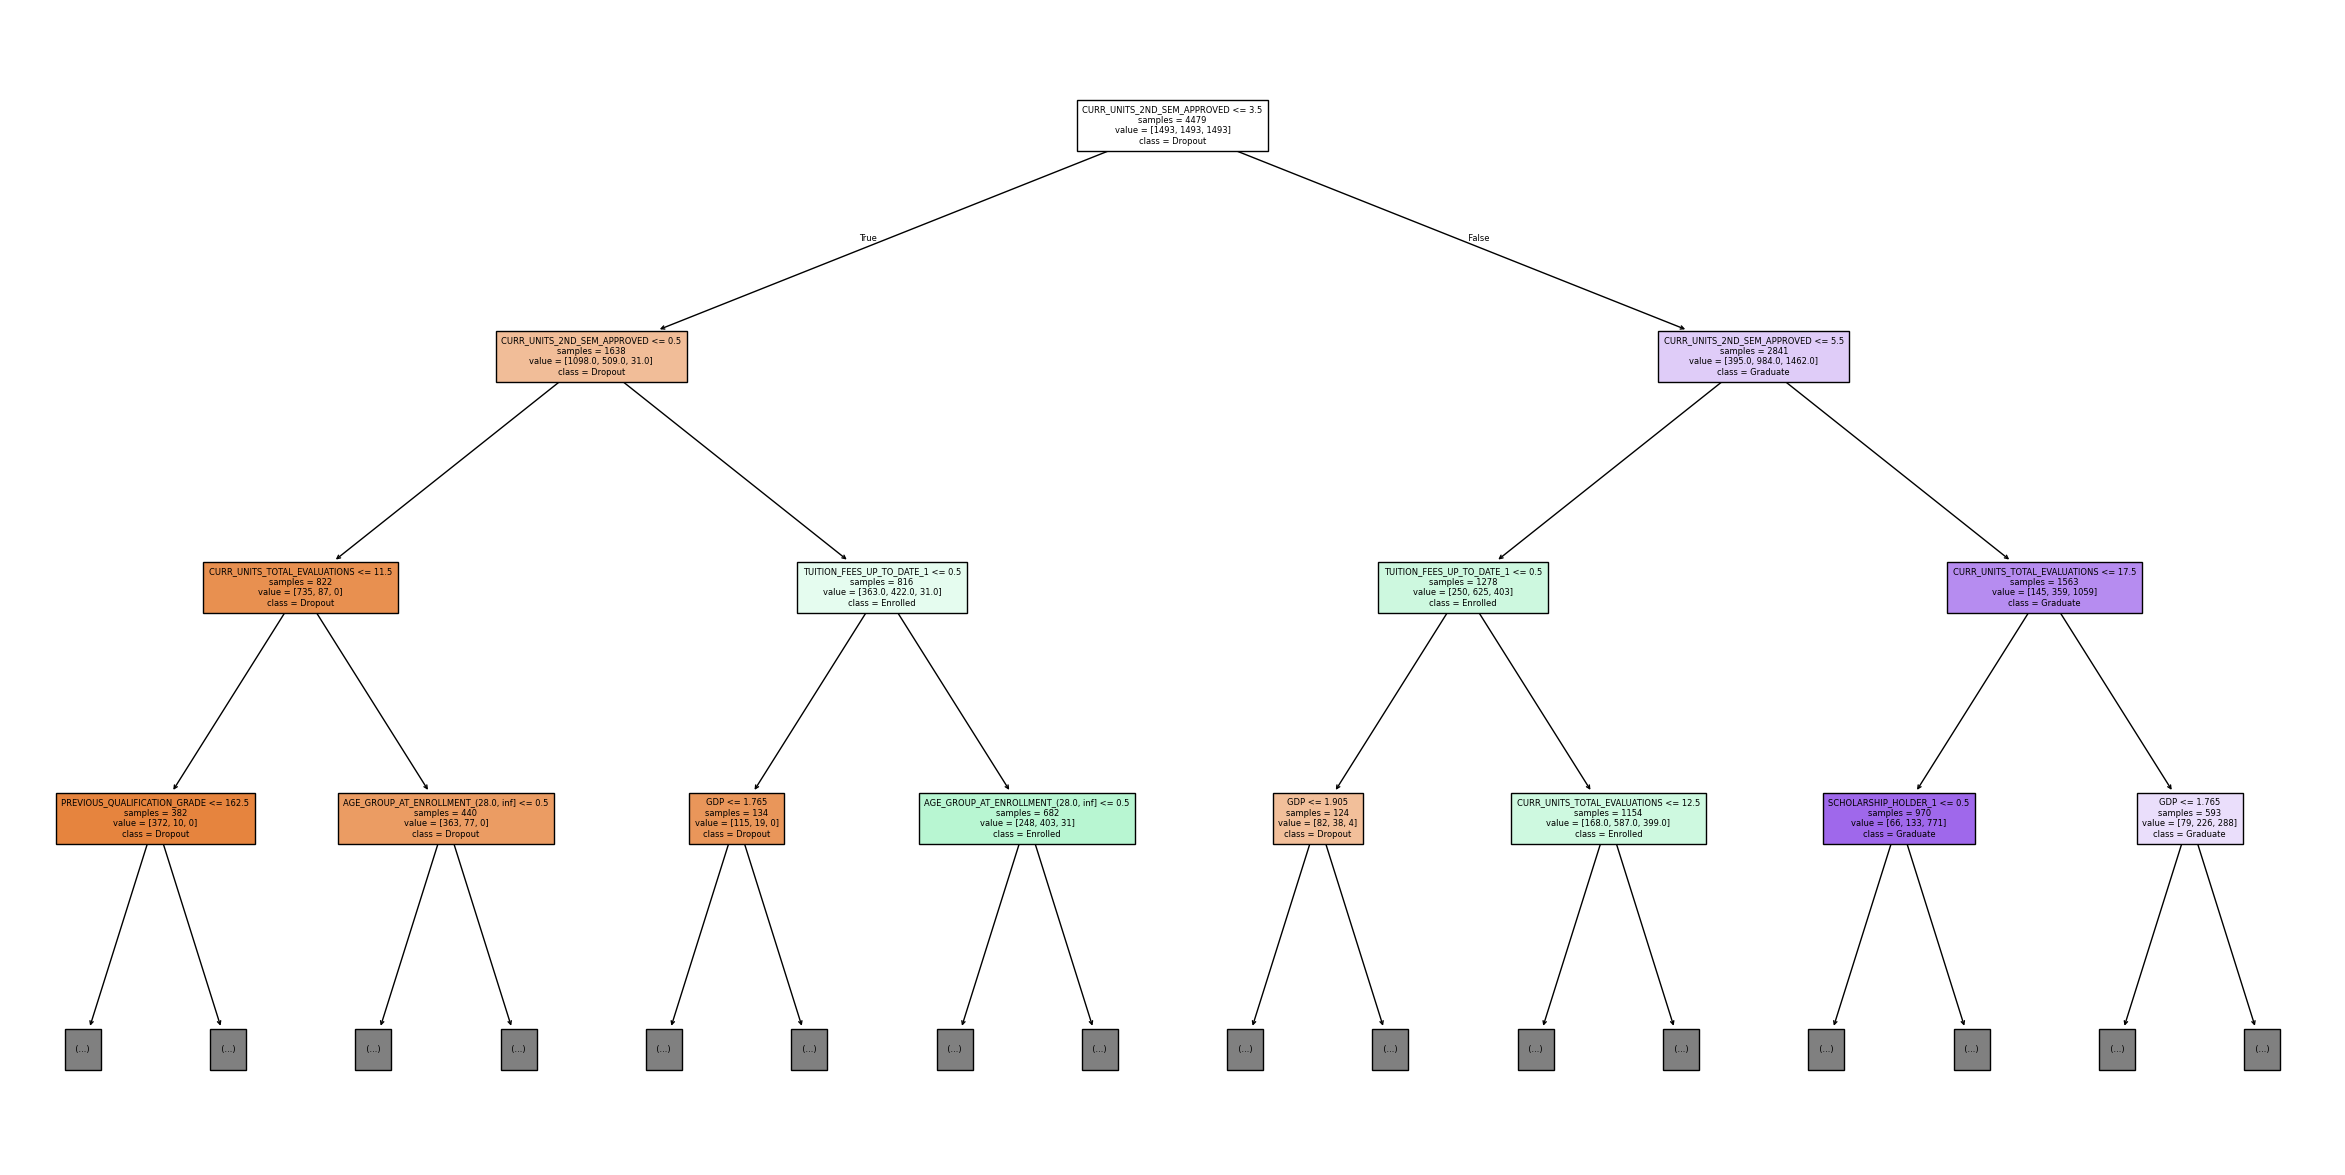

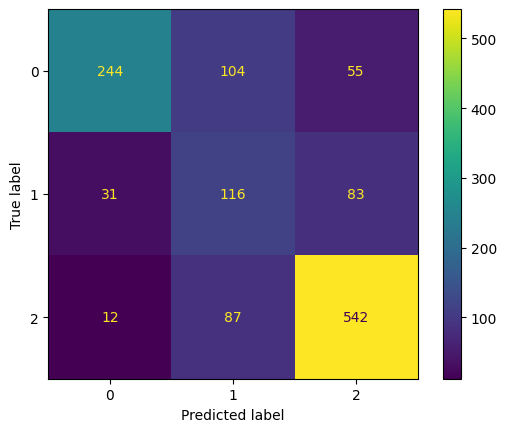

                                 Feature  Importance
4            CURR_UNITS_2ND_SEM_APPROVED    0.569221
5           CURR_UNITS_TOTAL_EVALUATIONS    0.082222
25             TUITION_FEES_UP_TO_DATE_1    0.073201
7                                    GDP    0.049229
3               CURR_UNITS_1ST_SEM_GRADE    0.029049
1                        ADMISSION_GRADE    0.022659
2            CURR_UNITS_1ST_SEM_ENROLLED    0.022441
54   AGE_GROUP_AT_ENROLLMENT_(28.0, inf]    0.016271
0           PREVIOUS_QUALIFICATION_GRADE    0.014195
18                           COURSE_9500    0.013211
21                           COURSE_9853    0.011721
35                   MOTHER_OCCUPATION_4    0.010299
39                 MOTHER_OCCUPATION_195    0.009329
6                      UNEMPLOYMENT_RATE    0.008442
27                  SCHOLARSHIP_HOLDER_1    0.007295
53  AGE_GROUP_AT_ENROLLMENT_(23.0, 28.0]    0.006990
13                           COURSE_9119    0.006640
14                           COURSE_9130    0.

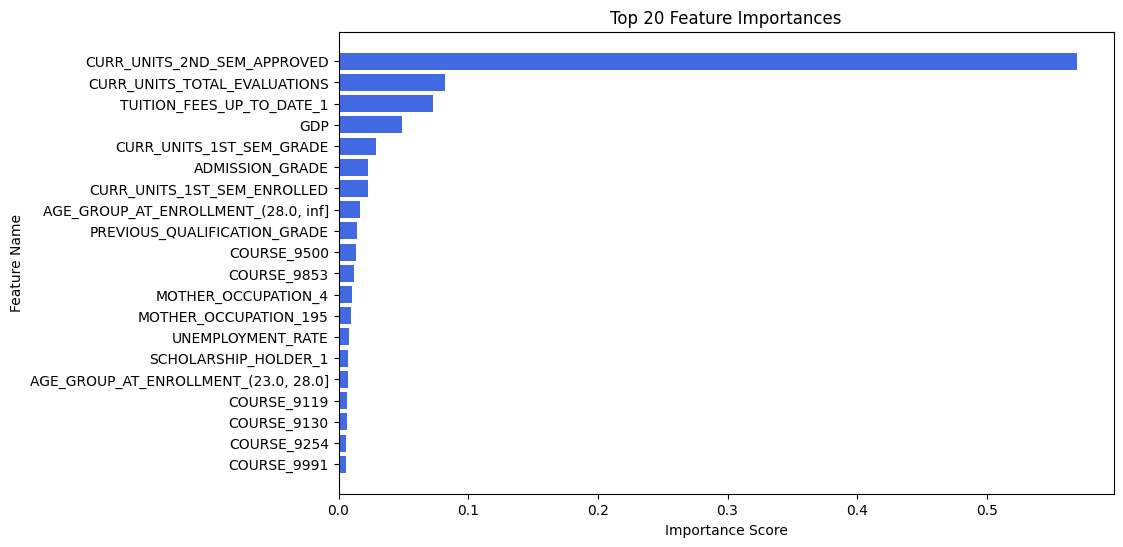

Training Accuracy: 0.7923
Test Accuracy: 0.7080
Training Balanced Accuracy: 0.7688
Test Balanced Accuracy: 0.6518


In [109]:
cm_display, fi_chart = hpt_decision_tree(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, RandomOverSampler(random_state=1))
save_figure(cm_display, "RQ1_HPT_DT_OS_CM.png")
save_figure(fi_chart, "RQ1_HPT_DT_OS_FI.png")

##### Hyperparameter Tune Random Forest with Random Under Sampler

In [110]:
def hpt_random_forest(X_train, X_test, y_train, y_test, continuous_col_names, categorical_col_names, sampler=None):
    params = {
        'n_estimators': [100, 200],      # Number of trees
        'max_depth': [5, 6, 7],      # Tree depth
        'min_samples_split': [4, 5, 7],     # Minimum samples to split a node
        'min_samples_leaf': [5, 7, 10],       # Minimum samples per leaf
        'max_features': ['sqrt'],    # Number of features per split
        'criterion': ['gini', 'entropy'] 
                # bootstrapping will be left at the default parameter of true
    }

    # initialise the model
    rf_clf = RandomForestClassifier(random_state=1, n_jobs=-1)
    X_train_resampled, y_train_resampled, X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names = preprocess_for_hyperparam_tuning(X_train, X_test, y_train, continuous_col_names, categorical_col_names, sampler)

    # Grid search
    gs_rf, gs_rf_fit, gs_rf_results, gs_rf_results_worst_score_diff = run_grid_search(rf_clf, params, X_train_resampled, y_train_resampled)

    print(f"Parameters used for best score: {gs_rf.best_params_}")
    print(f"Best test score during validation: {gs_rf_results.mean_test_score.values[0]}")
    print(f"Difference between training and validation scores: {gs_rf_results.score_difference.values[0]}")

    best_rf = gs_rf_fit.best_estimator_

    macro_avg_f1, cm_display = show_predictions(best_rf, X_test_preprocessed, y_test)
    fi_chart = report_feature_importances(best_rf, feature_names)

    show_difference_between_train_and_test(best_rf, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
    return (cm_display, fi_chart)

Parameters used for best score: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 200}
Best test score during validation: 0.7200119959667
Difference between training and validation scores: 0.056705962277158406
              precision    recall  f1-score   support

     Dropout       0.86      0.58      0.69       403
    Enrolled       0.38      0.56      0.45       230
    Graduate       0.82      0.84      0.83       641

    accuracy                           0.71      1274
   macro avg       0.69      0.66      0.66      1274
weighted avg       0.75      0.71      0.72      1274



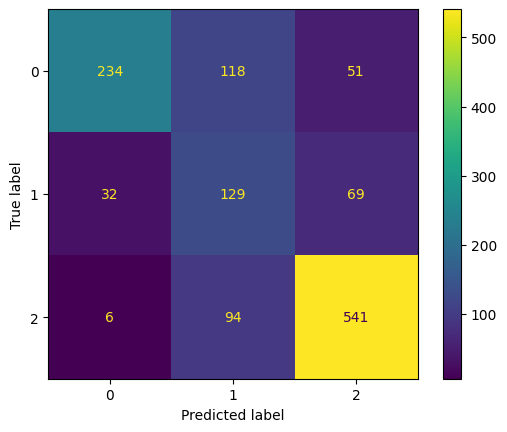

                                 Feature  Importance
4            CURR_UNITS_2ND_SEM_APPROVED    0.263719
3               CURR_UNITS_1ST_SEM_GRADE    0.128101
5           CURR_UNITS_TOTAL_EVALUATIONS    0.104838
24             TUITION_FEES_UP_TO_DATE_0    0.086428
25             TUITION_FEES_UP_TO_DATE_1    0.084492
26                  SCHOLARSHIP_HOLDER_0    0.027815
27                  SCHOLARSHIP_HOLDER_1    0.024423
43                   APPLICATION_MODE_39    0.023703
1                        ADMISSION_GRADE    0.022679
7                                    GDP    0.019928
2            CURR_UNITS_1ST_SEM_ENROLLED    0.019305
0           PREVIOUS_QUALIFICATION_GRADE    0.018291
6                      UNEMPLOYMENT_RATE    0.015804
54   AGE_GROUP_AT_ENROLLMENT_(28.0, inf]    0.015463
50                              DEBTOR_1    0.015110
51   AGE_GROUP_AT_ENROLLMENT_(0.0, 20.0]    0.015034
53  AGE_GROUP_AT_ENROLLMENT_(23.0, 28.0]    0.009733
49                              DEBTOR_0    0.

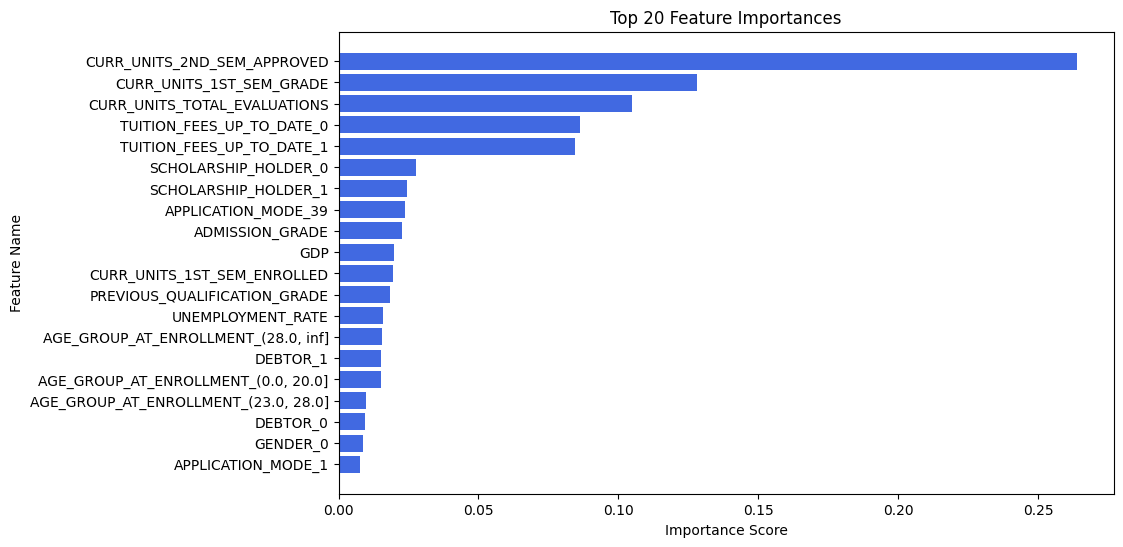

Training Accuracy: 0.7785
Test Accuracy: 0.7096
Training Balanced Accuracy: 0.7489
Test Balanced Accuracy: 0.6618


In [111]:
cm_display, fi_chart = hpt_random_forest(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, RandomUnderSampler(random_state=1))
save_figure(cm_display, "RQ1_HPT_RF_US_CM.png")
save_figure(fi_chart, "RQ1_HPT_RF_US_FI.png")

##### Hyperparameter Tune Gradient Boosting with SMOTE

In [112]:
def hpt_gradient_boosting(X_train, X_test, y_train, y_test, continuous_col_names, categorical_col_names, sampler=None):
    params = {
        'n_estimators': [100, 200],  # Number of trees
        'max_depth': [4, 5, 6],      # Tree depth
        'min_samples_split': [4, 5, 6],     # Minimum samples to split a node
        'max_features': ['sqrt'],    # Number of features per split
    }

    # initialise the model
    gb_clf = GradientBoostingClassifier(min_samples_leaf=2, random_state=1)
    X_train_resampled, y_train_resampled, X_train_preprocessed, X_test_preprocessed, encoder_cat, feature_names = preprocess_for_hyperparam_tuning(X_train, X_test, y_train, continuous_col_names, categorical_col_names, sampler)

    # Grid search
    gs_gb, gs_gb_fit, gs_gb_results, gs_gb_results_worst_score_diff = run_grid_search(gb_clf, params, X_train_resampled, y_train_resampled)
    
    print(f"Parameters used for best score: {gs_gb.best_params_}")
    print(f"Best test score during validation: {gs_gb_results.mean_test_score.values[0]}")
    print(f"Difference between training and validation scores: {gs_gb_results.score_difference.values[0]}")

    best_gb = gs_gb_fit.best_estimator_

    macro_avg_f1, cm_display = show_predictions(best_gb, X_test_preprocessed, y_test)
    fi_chart = report_feature_importances(best_gb, feature_names)

    show_difference_between_train_and_test(best_gb, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

    return (cm_display, fi_chart)

Parameters used for best score: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 200}
Best test score during validation: 0.8396313110335477
Difference between training and validation scores: 0.1571908879950522
              precision    recall  f1-score   support

     Dropout       0.83      0.75      0.79       403
    Enrolled       0.49      0.42      0.45       230
    Graduate       0.80      0.90      0.85       641

    accuracy                           0.76      1274
   macro avg       0.71      0.69      0.70      1274
weighted avg       0.76      0.76      0.76      1274



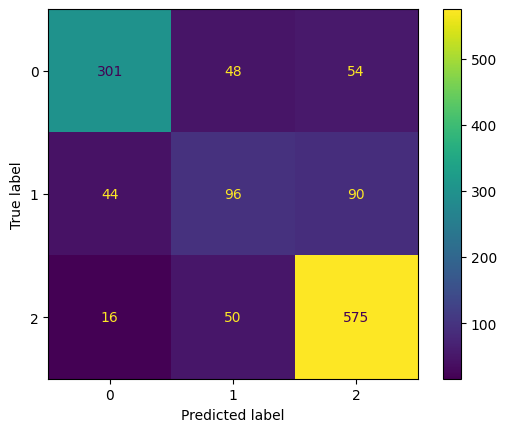

                                Feature  Importance
4           CURR_UNITS_2ND_SEM_APPROVED    0.243699
3              CURR_UNITS_1ST_SEM_GRADE    0.096973
5          CURR_UNITS_TOTAL_EVALUATIONS    0.057914
24            TUITION_FEES_UP_TO_DATE_0    0.057769
26                 SCHOLARSHIP_HOLDER_0    0.041966
2           CURR_UNITS_1ST_SEM_ENROLLED    0.038680
25            TUITION_FEES_UP_TO_DATE_1    0.037227
1                       ADMISSION_GRADE    0.028685
27                 SCHOLARSHIP_HOLDER_1    0.028610
0          PREVIOUS_QUALIFICATION_GRADE    0.024585
51  AGE_GROUP_AT_ENROLLMENT_(0.0, 20.0]    0.021678
7                                   GDP    0.020957
6                     UNEMPLOYMENT_RATE    0.019309
54  AGE_GROUP_AT_ENROLLMENT_(28.0, inf]    0.019025
48                             GENDER_1    0.017054
40                   APPLICATION_MODE_1    0.016199
18                          COURSE_9500    0.015223
32                  MOTHER_OCCUPATION_0    0.013874
47          

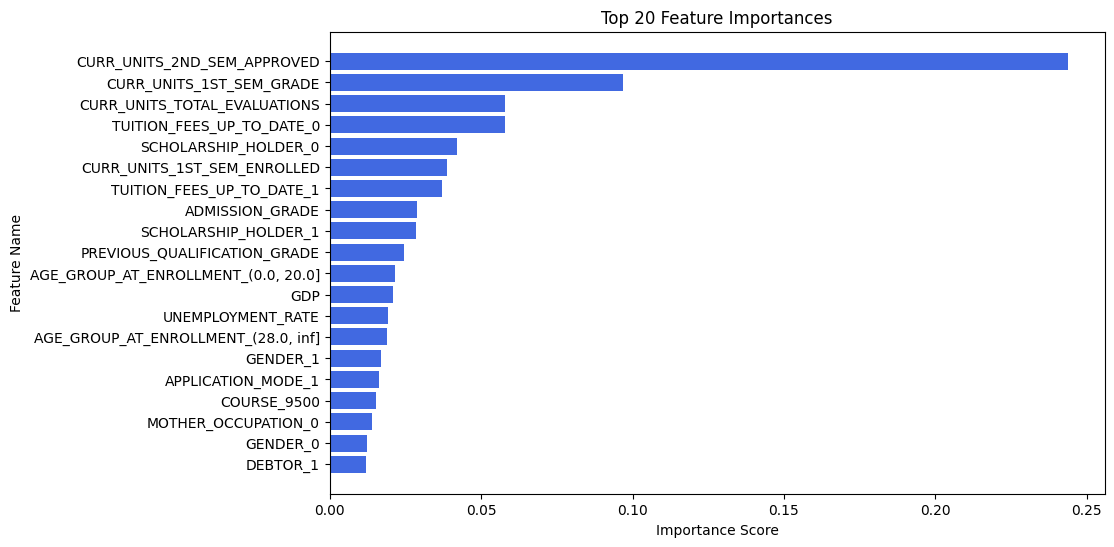

Training Accuracy: 0.9902
Test Accuracy: 0.7630
Training Balanced Accuracy: 0.9870
Test Balanced Accuracy: 0.6871


In [113]:
cm_display, fi_chart = hpt_gradient_boosting(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, SMOTE(random_state=1))
save_figure(cm_display, "RQ1_HPT_GB_SMOTE_CM.png")
save_figure(fi_chart, "RQ1_HPT_GB_SMOTE_FI.png")

#### Hyperparameter Tune against TARGET_IS_GRADUATE (RQ2)

##### Prepare data against TARGET_IS_GRADUATE

In [114]:
y_train, y_test = prepare_train_test_data_for_target(y_train_all_targets, y_test_all_targets, 'TARGET_IS_GRADUATE')

##### Hyperparameter Tune Gradient Boosting with SMOTE

Parameters used for best score: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best test score during validation: 0.86253941422652
Difference between training and validation scores: 0.09934257664803692
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       633
           1       0.82      0.90      0.86       641

    accuracy                           0.85      1274
   macro avg       0.85      0.85      0.85      1274
weighted avg       0.85      0.85      0.85      1274



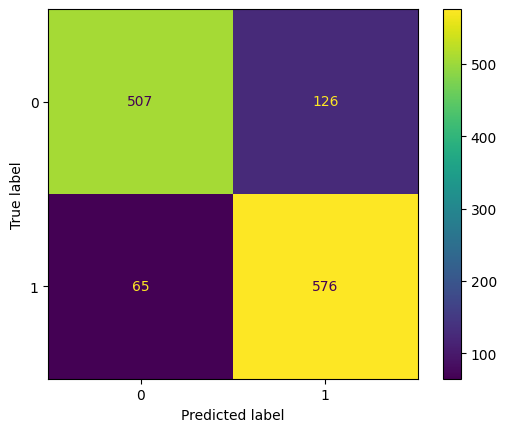

                                 Feature  Importance
4            CURR_UNITS_2ND_SEM_APPROVED    0.380973
3               CURR_UNITS_1ST_SEM_GRADE    0.121762
24             TUITION_FEES_UP_TO_DATE_0    0.056162
5           CURR_UNITS_TOTAL_EVALUATIONS    0.048445
26                  SCHOLARSHIP_HOLDER_0    0.037783
2            CURR_UNITS_1ST_SEM_ENROLLED    0.030416
25             TUITION_FEES_UP_TO_DATE_1    0.030055
51   AGE_GROUP_AT_ENROLLMENT_(0.0, 20.0]    0.029678
1                        ADMISSION_GRADE    0.027716
27                  SCHOLARSHIP_HOLDER_1    0.022121
0           PREVIOUS_QUALIFICATION_GRADE    0.019650
7                                    GDP    0.013420
13                           COURSE_9119    0.013297
21                           COURSE_9853    0.013146
6                      UNEMPLOYMENT_RATE    0.012988
49                              DEBTOR_0    0.012124
48                              GENDER_1    0.009929
53  AGE_GROUP_AT_ENROLLMENT_(23.0, 28.0]    0.

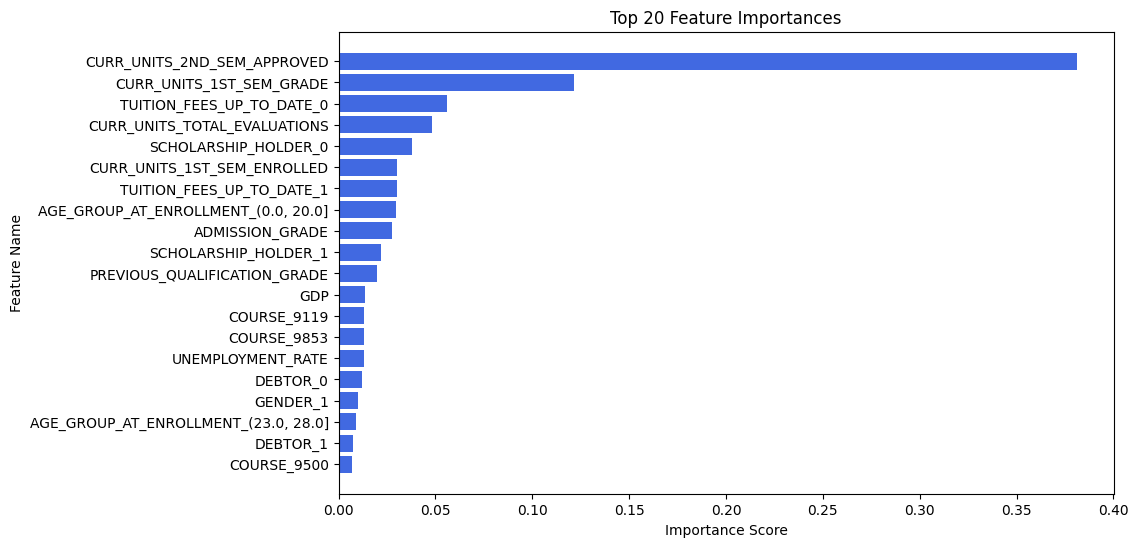

Training Accuracy: 0.9525
Test Accuracy: 0.8501
Training Balanced Accuracy: 0.9524
Test Balanced Accuracy: 0.8498


In [115]:
cm_display, fi_chart = hpt_gradient_boosting(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, SMOTE(random_state=1))
save_figure(cm_display, "RQ2_GRAD_HPT_GB_SMOTE_CM.png")
save_figure(fi_chart, "RQ2_GRAD_HPT_GB_SMOTE_FI.png")

##### Hyperparameter Tune Logistic Regression with SMOTE

Parameters used for best score: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best test score during validation: 0.854764755267124
Difference between training and validation scores: 0.009145642145155897
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       633
           1       0.83      0.90      0.86       641

    accuracy                           0.86      1274
   macro avg       0.86      0.86      0.86      1274
weighted avg       0.86      0.86      0.86      1274



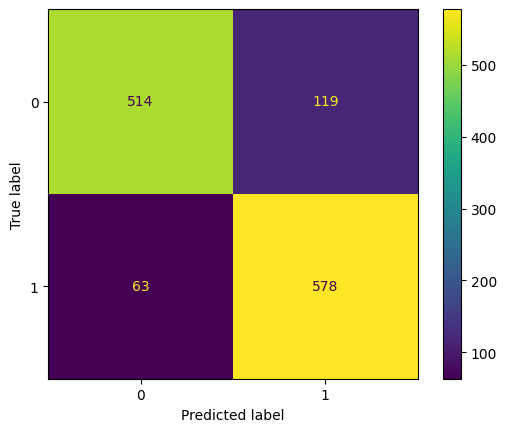

Training Accuracy: 0.8643
Test Accuracy: 0.8571
Training Balanced Accuracy: 0.8641
Test Balanced Accuracy: 0.8569


In [116]:
cm_display = hpt_logistic_regression(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, SMOTE(random_state=1))
save_figure(cm_display, "RQ2_GRAD_HPT_LR_SMOTE_CM.png")

#### Hyperparameter Tune against TARGET_IS_ENROLLED (RQ2)

##### Prepare data against TARGET_IS_ENROLLED

In [117]:
y_train, y_test = prepare_train_test_data_for_target(y_train_all_targets, y_test_all_targets, 'TARGET_IS_ENROLLED')

##### Hyperparameter Tune Gradient Boosting with SMOTE

Parameters used for best score: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100}
Best test score during validation: 0.8463583516334324
Difference between training and validation scores: 0.12606080130249608
              precision    recall  f1-score   support

           0       0.86      0.93      0.90      1044
           1       0.52      0.33      0.40       230

    accuracy                           0.82      1274
   macro avg       0.69      0.63      0.65      1274
weighted avg       0.80      0.82      0.81      1274



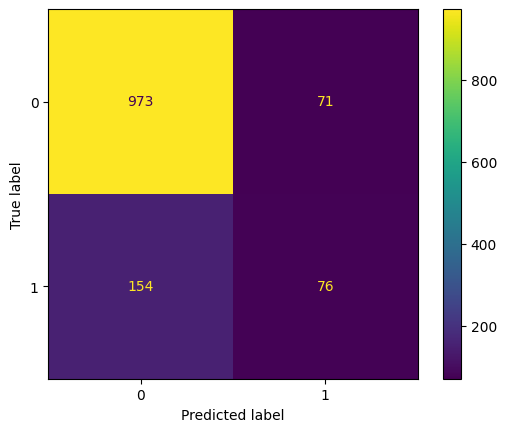

                                Feature  Importance
4           CURR_UNITS_2ND_SEM_APPROVED    0.132736
5          CURR_UNITS_TOTAL_EVALUATIONS    0.110333
2           CURR_UNITS_1ST_SEM_ENROLLED    0.107477
27                 SCHOLARSHIP_HOLDER_1    0.048294
24            TUITION_FEES_UP_TO_DATE_0    0.047574
26                 SCHOLARSHIP_HOLDER_0    0.043131
51  AGE_GROUP_AT_ENROLLMENT_(0.0, 20.0]    0.040120
3              CURR_UNITS_1ST_SEM_GRADE    0.036851
54  AGE_GROUP_AT_ENROLLMENT_(28.0, inf]    0.036429
38                  MOTHER_OCCUPATION_9    0.029911
42                  APPLICATION_MODE_17    0.024500
18                          COURSE_9500    0.022198
6                     UNEMPLOYMENT_RATE    0.021957
47                             GENDER_0    0.019137
1                       ADMISSION_GRADE    0.017867
7                                   GDP    0.017086
15                          COURSE_9147    0.017015
36                  MOTHER_OCCUPATION_5    0.016209
48          

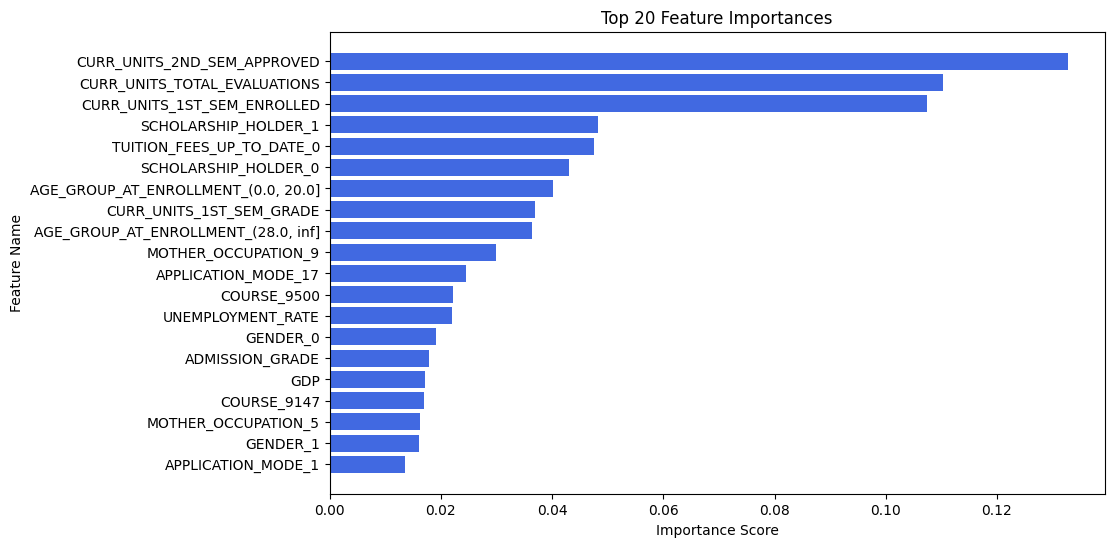

Training Accuracy: 0.9431
Test Accuracy: 0.8234
Training Balanced Accuracy: 0.8736
Test Balanced Accuracy: 0.6312


In [118]:
cm_display, fi_chart = hpt_gradient_boosting(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, SMOTE(random_state=1))
save_figure(cm_display, "RQ2_ENRL_HPT_GB_SMOTE_CM.png")
save_figure(fi_chart, "RQ2_ENRL_HPT_GB_SMOTE_FI.png")

##### Hyperparameter Tune Logistic Regression with SMOTE

Parameters used for best score: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best test score during validation: 0.7462308475374346
Difference between training and validation scores: 0.001761666746886048
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1044
           1       0.34      0.65      0.45       230

    accuracy                           0.71      1274
   macro avg       0.62      0.69      0.63      1274
weighted avg       0.80      0.71      0.74      1274



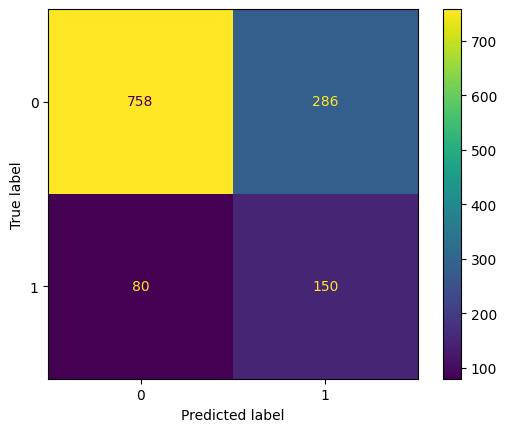

Training Accuracy: 0.7337
Test Accuracy: 0.7127
Training Balanced Accuracy: 0.7320
Test Balanced Accuracy: 0.6891


In [119]:
cm_display = hpt_logistic_regression(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, SMOTE(random_state=1))
save_figure(cm_display, "RQ2_ENRL_HPT_LR_SMOTE_CM.png")

#### Hyperparameter Tune against TARGET_IS_DROPOUT (RQ2)

##### Prepare data against TARGET_IS_DROPOUT

In [120]:
y_train, y_test = prepare_train_test_data_for_target(y_train_all_targets, y_test_all_targets, 'TARGET_IS_DROPOUT')

##### Hyperparameter Tune Gradient Boosting with SMOTE

Parameters used for best score: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 200}
Best test score during validation: 0.9068711379534745
Difference between training and validation scores: 0.05534741440837865
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       871
           1       0.86      0.72      0.78       403

    accuracy                           0.87      1274
   macro avg       0.87      0.83      0.85      1274
weighted avg       0.87      0.87      0.87      1274



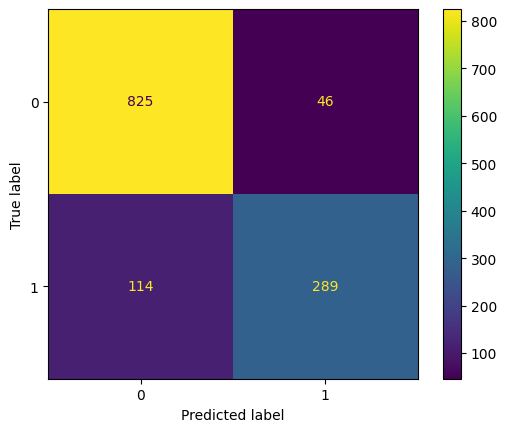

                                 Feature  Importance
4            CURR_UNITS_2ND_SEM_APPROVED    0.300166
24             TUITION_FEES_UP_TO_DATE_0    0.137735
3               CURR_UNITS_1ST_SEM_GRADE    0.069556
51   AGE_GROUP_AT_ENROLLMENT_(0.0, 20.0]    0.057627
25             TUITION_FEES_UP_TO_DATE_1    0.040739
26                  SCHOLARSHIP_HOLDER_0    0.038950
5           CURR_UNITS_TOTAL_EVALUATIONS    0.028282
48                              GENDER_1    0.027316
2            CURR_UNITS_1ST_SEM_ENROLLED    0.026550
40                    APPLICATION_MODE_1    0.020194
47                              GENDER_0    0.018958
49                              DEBTOR_0    0.018668
54   AGE_GROUP_AT_ENROLLMENT_(28.0, inf]    0.016770
50                              DEBTOR_1    0.015645
52  AGE_GROUP_AT_ENROLLMENT_(20.0, 23.0]    0.015512
53  AGE_GROUP_AT_ENROLLMENT_(23.0, 28.0]    0.012534
21                           COURSE_9853    0.010886
27                  SCHOLARSHIP_HOLDER_1    0.

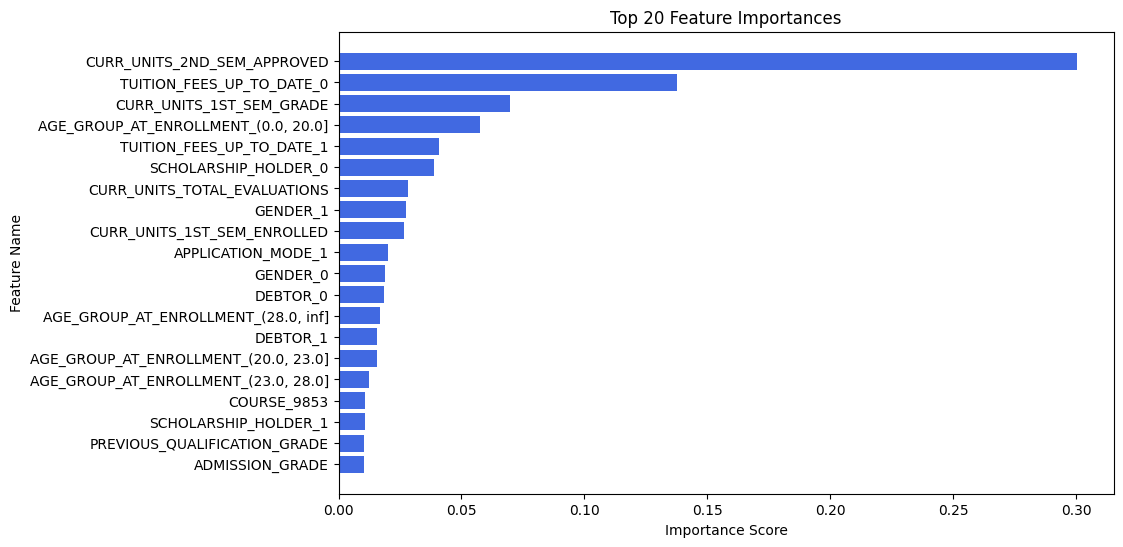

Training Accuracy: 0.9441
Test Accuracy: 0.8744
Training Balanced Accuracy: 0.9243
Test Balanced Accuracy: 0.8322


In [121]:
cm_display, fi_chart = hpt_gradient_boosting(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, SMOTE(random_state=1))
save_figure(cm_display, "RQ2_DROP_HPT_GB_SMOTE_CM.png")
save_figure(fi_chart, "RQ2_DROP_HPT_GB_SMOTE_FI.png")

##### Hyperparameter Tune Logistic Regression with SMOTE

Parameters used for best score: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best test score during validation: 0.8606914458058202
Difference between training and validation scores: 0.004245359739844079
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       871
           1       0.77      0.80      0.79       403

    accuracy                           0.86      1274
   macro avg       0.84      0.85      0.84      1274
weighted avg       0.86      0.86      0.86      1274



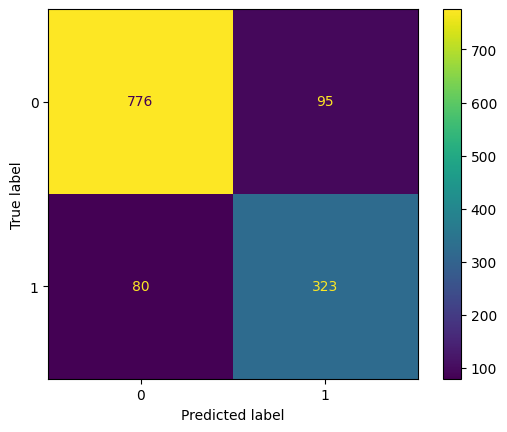

Training Accuracy: 0.8704
Test Accuracy: 0.8626
Training Balanced Accuracy: 0.8595
Test Balanced Accuracy: 0.8462


In [122]:
cm_display = hpt_logistic_regression(X_train, X_test, y_train, y_test, selected_continuous_columns, selected_categorical_columns, SMOTE(random_state=1))
save_figure(cm_display, "RQ2_DROP_HPT_LR_SMOTE_CM.png")

#### Conclusion After Hyperparameter Tuning
For RQ1:
- Gradient Boosting with SMOTE had the best accuracy and average scores
- Logistic Regression with SMOTE was a close second and had better results for the Enrolled minority class.
- Both of these models were taken forward to RQ2 tuning
- Both models were able to beat the published results of the Portuguese study proving RQ1 to be true

For RQ2:
- Gradient Boosting with SMOTE and Logistic Regression with SMOTE models were taken forward to RQ2.
- For the Graduate & Dropout class tests, the precision and overall accuracy and F1-score beat the RQ1 results.
- Logistic Regression with SMOTE was the best model for Graduate
- Gradient Boosting with SMOTE was best for Dropout.
- Enrolled is less clear
  - Gradient Boosting with SMOTE achieved higher precision than RQ1 but has a lower recall meaning that it missed many positive cases.
  - Logistic Regression with SMOTE gave better recall at the cost of lower precision, so which is best will depend on the priorities of the user.
- On an individual class basis RQ2 was proved true as comparing the confusion matrices it was more predictive than the models of RQ1
- The choice between models will depend on whether the user prefers to capture a higher number of true positives at the cost of more false positives. 

--- END ---